## Modeling
### Experiments with XGBoost for Forecasting Stocks

**Objetivo**: O objetivo deste notebook é fazer experimentos de modelagem com o modelo XGBoost, que será construido de forma iterativa (1 step-ahead forecast)



**Conclusões**:


### 1.0 Imports

In [1]:
%pip install xgboost
%pip install statsmodels
%pip install mlflow
%pip install hyperopt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import logging
from joblib import load, dump
#from pandas_profiling import ProfileReport

# Time Series Libraries
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  #Autocorrelação (MA), Autocorrelatcao parcial (AR)ve

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import xgboost as xgb
from hyperopt import fmin, tpe, Trials, hp, SparkTrials, space_eval, STATUS_OK, rand, Trials

from scipy.stats import shapiro, normaltest, kstest

import mlflow

### 2.0 Definindo Parâmetros

In [3]:
model_config = {
    "TEST_SIZE": 0.2,
    "TARGET_NAME": "Close",
    "VALIDATION_METRIC": "MAPE",
    "OPTIMIZATION_METRIC": "MSE",
    "FORECAST_HORIZON": 14,
    "REGISTER_MODEL_NAME": "Stock_Predictor"
}

features_list = ["day_of_month", "month", "quarter", "Close_lag_1"]
run_name = "Experiment_run"

# Define a ação para procurar
STOCK_NAME = 'BOVA11.SA'

In [4]:
xgboost_model_config = {
    'LEARNING_RATE': 0.01,
    'MAX_DEPTH': 100,
    'MIN_DATA': 100,
    'N_ESTIMATORS': 1000,
    'REG_LAMBDA': 100,
    'SCALE_POS_WEIGHT': 10,
    'SEED': 42,
    'SUBSAMPLE': 0.9,
    'COLSAMPLE_BYTREE': 0.9,
    'NUM_BOOST_ROUNDS': 200,
    'GAMMA': 0.01
}

xgboost_fixed_model_config = {
    'SEED': 42,
    'SUBSAMPLE': 1.0
}
xgboost_hyperparameter_config = {
    'max_depth': hp.choice('max_depth', [3, 5, 7, 9]),
    'learning_rate': hp.choice('learning_rate', [0.2, 0.3, 0.1]),
    'subsample': hp.choice('subsample', [0.8, 1.0]),
    'gamma': hp.choice('gamma', [0.25, 0.5, 1.0]),
    'reg_lambda': hp.choice('reg_lambda', [0.25, 0.5, 1.0, 5.0]),
    'reg_alpha': hp.choice('reg_alpha', [0.25, 0.5, 1.0, 5.0]),
    'n_estimators': hp.choice('n_estimators', [40, 100, 300]),
    'colsample_bytree': hp.choice('colsample_bytree', [1.0]),
}

param_grid = {
    "n_estimators": [40, 100, 300],
    "max_depth": [3, 5, 7, 9],
    "learning_rate": [0.2, 0.3, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [1.0],
    "gamma": [0.25, 0.5, 1.0],
    "reg_alpha": [0.25, 0.5, 1.0, 5.0],
    "reg_lambda": [0.25, 0.5, 1.0, 5.0],
}

In [5]:
log_format = "[%(name)s][%(levelname)-6s] %(message)s"
logging.basicConfig(format=log_format)
logger = logging.getLogger("describe")
logger.setLevel(logging.DEBUG)

### 3.0 Criando Funções

In [6]:
def build_features(raw_df: pd.DataFrame, features_list: list) -> pd.DataFrame:
    """
    This function creates the features for the dataset to be consumed by the
    model
    
    :param raw_df: Raw Pandas DataFrame to create the features of
    :param features_list: The list of features to create

    :return: Pandas DataFrame with the new features
    """

    logger.info("Building the features...")

    stock_df_featurized = raw_df.copy()
    for feature in features_list:
        
        # create "Time" features
        if feature == "day_of_month":
            stock_df_featurized['day_of_month'] = stock_df_featurized["Date"].apply(lambda x: float(x.day))
        elif feature == "month":
            stock_df_featurized['month'] = stock_df_featurized['Date'].apply(lambda x: float(x.month))
        elif feature == "quarter":
            stock_df_featurized['quarter'] = stock_df_featurized['Date'].apply(lambda x: float(x.quarter))

    # Create "Lag" features
    # The lag 1 feature will become the main regressor, and the regular "Close" will become the target.
    # As we saw that the lag 1 holds the most aucorrelation, it is reasonable to use it as the main regressor.
        elif feature == "Close_lag_1":
            stock_df_featurized['Close_lag_1'] = stock_df_featurized['Close'].shift()


    # Drop nan values because of the shift
    stock_df_featurized = stock_df_featurized.dropna()

    # Save the dataset
    stock_df_featurized.to_csv("../data/processed/processed_stock_prices.csv", index=False)

    return stock_df_featurized

In [7]:
def ts_train_test_split(data: pd.DataFrame, target:str, test_size: int):
    """
    Splits the Pandas DataFrame into training and tests sets
    based on a Forecast Horizon value.

    Paramteres:
        data (pandas dataframe): Complete dataframe with full data
        targer (string): the target column name
        test_size (int): the amount of periods to forecast

    Returns:
        X_train, X_test, y_train, y_test dataframes for training and testing
    """

    logger.info("Spliting the dataset...")

    train_df = data.iloc[:-test_size, :]
    test_df = data.iloc[-test_size:, :]
    X_train = train_df.drop(target, axis=1)
    y_train = train_df[target]
    X_test = test_df.drop(target, axis=1)
    y_test = test_df[target]

    return X_train, X_test, y_train, y_test

In [8]:
def visualize_validation_results(pred_df: pd.DataFrame, model_mape: float, model_rmse: float):
    """
    Creates visualizations of the model validation

    Paramters:
        pred_df: DataFrame with true values, predictions and the date column
        model_mape: The validation MAPE
        model_rmse: The validation RMSE

    Returns:
        None
    """

    logger.info("Vizualizing the results...")

    fig, axs = plt.subplots(figsize=(12, 5))
    # Plot the Actuals
    sns.lineplot(
        data=pred_df,
        x="Date",
        y="Actual",
        label="Testing values",
        ax=axs
    )
    sns.scatterplot(
        data=pred_df,
        x="Date",
        y="Actual",
        ax=axs,
        size="Actual",
        sizes=(80, 80), legend=False
    )

    # Plot the Forecasts
    sns.lineplot(
        data=pred_df,
        x="Date",
        y="Forecast",
        label="Forecast values",
        ax=axs
    )
    sns.scatterplot(
        data=pred_df,
        x="Date",
        y="Forecast",
        ax=axs,
        size="Forecast",
        sizes=(80, 80), legend=False
    )

    axs.set_title(f"Default XGBoost {model_config['FORECAST_HORIZON']} days Forecast for {STOCK_NAME}\nMAPE: {round(model_mape*100, 2)}% | RMSE: R${model_rmse}")
    axs.set_xlabel("Date")
    axs.set_ylabel("R$")

    #plt.savefig(f"./reports/figures/XGBoost_predictions_{dt.datetime.now().date()}.png")
    plt.show()

In [9]:
def visualize_forecast(pred_df: pd.DataFrame, historical_df: pd.DataFrame, stock_name: str):
    """
    Creates visualizations of the model forecast

    Paramters:
        pred_df: DataFrame with true values, predictions and the date column
        historical_df: DataFrame with historical values

    Returns:
        None
    """

    logger.info("Vizualizing the results...")

    fig, axs = plt.subplots(figsize=(12, 5), dpi = 2000)
    # Plot the Actuals
    sns.lineplot(
        data=historical_df,
        x="Date",
        y="Close",
        label="Historical values",
        ax=axs
    )
    sns.scatterplot(
        data=historical_df,
        x="Date",
        y="Close",
        ax=axs,
        size="Close",
        sizes=(80, 80),
        legend=False
    )

    # Plot the Forecasts
    sns.lineplot(
        data=pred_df,
        x="Date",
        y="Forecast",
        label="Forecast values",
        ax=axs
    )
    sns.scatterplot(
        data=pred_df,
        x="Date",
        y="Forecast",
        ax=axs,
        size="Forecast",
        sizes=(80, 80),
        legend=False
    )

    axs.set_title(f"Default XGBoost {model_config['FORECAST_HORIZON']-4} days Forecast for {stock_name}")
    axs.set_xlabel("Date")
    axs.set_ylabel("R$")

    plt.show()
    return fig

In [10]:
def train_model(X_train, y_train, random_state=42):
    """
    Trains a XGBoost model for Forecasting
    
    :param X_train: Training Features
    :param y_train: Training Target

    :return: Fitted model
    """
    

    with mlflow.start_run(run_name=run_name) as run:
        # create the model
        xgboost_model = xgb.XGBRegressor(
            random_state=random_state,
            )

        # train the model
        xgboost_model.fit(
            X_train,
            y_train, 
            )

         # get the run id
        model_uri = f"runs:/{run.info.run_id}/{model_config['REGISTER_MODEL_NAME']}_{run_name}"

        # log the model
        model_signature = mlflow.models.signature.infer_signature(X_train, pd.DataFrame(y_train))

        mlflow.sklearn.log_model(
            xgboost_model,
            "first_xgboost",
            input_example=X_train.head(),
            signature=model_signature
        )

        # register the model
        model_details = mlflow.register_model(
            model_uri = model_uri,
            name = model_config['REGISTER_MODEL_NAME']
        )


        # set model to staging version to be tested
        client = mlflow.MlflowClient()

        client.transition_model_version_stage(
            name=model_config["REGISTER_MODEL_NAME"],
            version=model_details.version,
            stage="Staging"
        )


        
    return xgboost_model


In [29]:
def train_model(X_train: pd.DataFrame,  y_train: pd.DataFrame, random_state:int=42):
    """
    Trains a XGBoost model for Forecasting
    
    :param X_train: Training Features
    :param y_train: Training Target

    :return: Fitted model
    """
    logger.info("Training the model...")

    
    params = {'colsample_bytree': 1.0,
     'gamma': 1.0,
     'learning_rate': 0.3,
     'max_depth': 9,
     'n_estimators': 300,
     'reg_alpha': 1.0,
     'reg_lambda': 0.25,
     'subsample': 1.0}
    params = {'colsample_bytree': 1.0, 'gamma': 0.25, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 40, 'reg_alpha': 5.0, 'reg_lambda': 1.0, 'subsample': 1.0}
    # create the model
    xgboost_model = xgb.XGBRegressor(
        random_state=random_state,
        **params
        )

    # train the model
    xgboost_model.fit(
        X_train,
        y_train,
        )

    # save model
    dump(xgboost_model, f"./{model_config['REGISTER_MODEL_NAME']}_nb.joblib")

    return xgboost_model

In [12]:
def validate_model(X:pd.DataFrame, y:pd.Series, forecast_horizon: int) -> pd.DataFrame:
    """
    Make predictions for the next `forecast_horizon` days using a XGBoost model.
    This function performs the validation on the last days using stepwise predictions:
    The model is trained every new day.
    
    Parameters:
        X (pandas dataframe): The input data
        y (pandas dataframe): The target data
        forecast_horizon (int): Number of days to forecast
        
    Returns:
        None
    """

    logger.info("Starting the pipeline..")


    # Create empty list for storing each prediction
    predictions = []
    actuals = []
    dates = []


    # Iterate over the dataset to perform predictions over the forecast horizon, one by one.
    # So we need to start at training = training until the total forecast horizon, then, perform the next step
    # After forecasting the next step, we need to append the new line to the training dataset and so on

    for day in range(forecast_horizon, 0, -1):

        # update the training and testing sets
        X_train = X.iloc[:-day, :]
        y_train = y.iloc[:-day]
 
        if day != 1:
            # the testing set will be the next day after the training
            X_test = X.iloc[-day:-day+1,:]
            y_test = y.iloc[-day:-day+1]

        else:
            # need to change the syntax for the last day (for -1:-2 will not work)
            X_test = X.iloc[-day:,:]
            y_test = y.iloc[-day:]


        # only the first iteration will use the true value of y_train
        # because the following ones will use the last predicted value as true value
        # so we simulate the process of predicting out-of-sample
        if len(predictions) != 0:
            # update the y_train with the last predictions
            y_train.iloc[-len(predictions):] = predictions[-len(predictions):]

            # now update the Close_lag_1 feature
            X_train.iloc[-len(predictions):, -1] = y_train.shift(1).iloc[-len(predictions):]
            X_train = X_train.dropna()

        else:
            pass
        
        
        # train the model
        xgboost_model = train_model(X_train.drop("Date", axis=1), y_train)

        # make prediction
        prediction = xgboost_model.predict(X_test.drop("Date", axis=1))

        # store the results
        predictions.append(prediction[0])
        actuals.append(y_test.values[0])
        dates.append(X_test["Date"].max())

    # Calculate the resulting metric
    model_mape = round(mean_absolute_percentage_error(actuals, predictions), 4)
    model_rmse = round(np.sqrt(mean_squared_error(actuals, predictions)), 2)
 
    pred_df = pd.DataFrame(list(zip(dates, actuals, predictions)), columns=["Date", 'Actual', 'Forecast'])
    pred_df["Forecast"] = pred_df["Forecast"].astype("float64")
    visualize_validation_results(pred_df, model_mape, model_rmse)
    
    return pred_df

In [13]:
def validade_model_one_shot(X:pd.DataFrame, y:pd.Series, forecast_horizon: int) -> pd.DataFrame:
    """
    Make predictions for the next `forecast_horizon` days using a XGBoost model.
    This model is validated using One Shot Training, it means that we train the model
    once, and them perform the `forecast_horizon` predictions only loading the mdoel.
    
    Parameters:
        X (pandas dataframe): The input data
        y (pandas dataframe): The target data
        forecast_horizon (int): Number of days to forecast
        
    Returns:
        pred_df: Pandas DataFrame with the forecasted values
    """

    logger.info("Starting the pipeline..")

    # Create empty list for storing each prediction
    predictions = []
    actuals = []
    dates = []
    
    # get the one-shot training set
    X_train = X.iloc[:-forecast_horizon, :]
    y_train = y.iloc[:-forecast_horizon]
    
    # train the model once
    xgboost_model = train_model(
        X_train.drop("Date", axis=1),
        y_train
    )

    # Iterate over the dataset to perform predictions over the forecast horizon, one by one.
    # After forecasting the next step, we need to update the "lag" features with the last forecasted
    # value
    for day in range(forecast_horizon-4, 0, -1):
        
        if day != 1:
            # the testing set will be the next day after the training and we use the complete dataset
            X_test = X.iloc[-day:-day+1,:]
            y_test = y.iloc[-day:-day+1]

        else:
            # need to change the syntax for the last day (for -1:-2 will not work)
            X_test = X.iloc[-day:,:]
            y_test = y.iloc[-day:]

        # only the first iteration will use the true value of Close_lag_1
        # because the following ones will use the last predicted value as true value
        # so we simulate the process of predicting out-of-sample
        if len(predictions) != 0:
            
            # we need to update the X_test["Close_lag_1"] value, because
            # it should be equal to the last prediction (the "yesterday" value)
            X_test.iloc[:, -1] = predictions[-1]            

        else:
            pass
    
        # make prediction
        prediction = xgboost_model.predict(X_test.drop("Date", axis=1))
        print(f"Day: {X_test['Date'].max()} | Prediction: {prediction[0]} | Close_Lag_1: {X_test['Close_lag_1'].values[0]}")

        # store the results
        predictions.append(prediction[0])
        actuals.append(y_test.values[0])
        dates.append(X_test["Date"].max())

    # Calculate the resulting metric
    model_mape = round(mean_absolute_percentage_error(actuals, predictions), 4)
    model_rmse = round(np.sqrt(mean_squared_error(actuals, predictions)), 2)
 
    pred_df = pd.DataFrame(list(zip(dates, actuals, predictions)), columns=["Date", 'Actual', 'Forecast'])
    pred_df["Forecast"] = pred_df["Forecast"].astype("float64")
    visualize_validation_results(pred_df, model_mape, model_rmse)
    
    return pred_df

## 4.0 Executando

### 4.1 Prepare data

In [14]:
# Load the raw dataset
stock_df = pd.read_csv('../data/raw/raw_stock_prices.csv', parse_dates=["Date"])

# Perform featurization
features_list = ["day_of_month", "month", "quarter", "Close_lag_1"]

stock_df_feat = build_features(stock_df, features_list)

stock_df_feat = stock_df_feat[stock_df_feat["Stock"] == 'BOVA11.SA'].drop("Stock", axis=1)

# train test split
X_train, X_test, y_train, y_test = ts_train_test_split(stock_df_feat, model_config["TARGET_NAME"], model_config["FORECAST_HORIZON"])
#X_train = X_train.drop("Date", axis=1)
#X_test = X_test.drop("Date", axis=1)

[describe][INFO  ] Building the features...
[describe][INFO  ] Spliting the dataset...


### 4.1 Definindo o HyperOpt

In [15]:
def objective(search_space):
    
    model = xgb.XGBRegressor(
        **search_space,
        verbose=2
    )
    
    model.fit(
        X_train.drop("Date", axis=1),
        y_train,
        early_stopping_rounds = 50,
        eval_metric = ['mae'],
        eval_set=[[X_train.drop("Date", axis=1), y_train]]
    )
    
    y_pred = model.predict(X_test.drop("Date", axis=1))
    mse = mean_squared_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    return {'loss': mae, 'status': STATUS_OK}

In [16]:
# define search space
search_space = xgboost_hyperparameter_config
# define algo
algorithm = tpe.suggest
# define trials
#spark_trials = SparkTrials(parallelism=1)
trials = Trials()

In [17]:
best_params = fmin(
        fn=objective,
        space=search_space,
        algo=algorithm,
        trials=trials,
        max_evals=10240,
    )
  
xgboost_best_param_names = space_eval(search_space, best_params)
xgboost_best_param_names

[15:20:01] WARNING: ../src/learner.cc:767:                                                                              
Parameters: { "verbose" } are not used.

[0]	validation_0-mae:103.41317                                                                                          
[1]	validation_0-mae:103.31038                                                                                          
[2]	validation_0-mae:103.20755                                                                                          
[3]	validation_0-mae:103.10498                                                                                          
[4]	validation_0-mae:103.00233                                                                                          
[5]	validation_0-mae:102.89982                                                                                          
[6]	validation_0-mae:102.79727                                                                                  

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[9]	validation_0-mae:102.49092                                                                                          
[10]	validation_0-mae:102.38898                                                                                         
[11]	validation_0-mae:102.28695                                                                                         
[12]	validation_0-mae:102.18525                                                                                         
[13]	validation_0-mae:102.08347                                                                                         
[14]	validation_0-mae:101.98185                                                                                         
[15]	validation_0-mae:101.88048                                                                                         
[16]	validation_0-mae:101.77934                                                                                         
[17]	validation_0-mae:101.67796 

[76]	validation_0-mae:95.87446                                                                                          
[77]	validation_0-mae:95.77908                                                                                          
[78]	validation_0-mae:95.68377                                                                                          
[79]	validation_0-mae:95.58861                                                                                          
[80]	validation_0-mae:95.49337                                                                                          
[81]	validation_0-mae:95.39831                                                                                          
[82]	validation_0-mae:95.30336                                                                                          
[83]	validation_0-mae:95.20854                                                                                          
[84]	validation_0-mae:95.11394  

[143]	validation_0-mae:89.68708                                                                                         
[144]	validation_0-mae:89.59780                                                                                         
[145]	validation_0-mae:89.50874                                                                                         
[146]	validation_0-mae:89.41949                                                                                         
[147]	validation_0-mae:89.33059                                                                                         
[148]	validation_0-mae:89.24151                                                                                         
[149]	validation_0-mae:89.15281                                                                                         
[150]	validation_0-mae:89.06411                                                                                         
[151]	validation_0-mae:88.97570 

[210]	validation_0-mae:83.89921                                                                                         
[211]	validation_0-mae:83.81581                                                                                         
[212]	validation_0-mae:83.73232                                                                                         
[213]	validation_0-mae:83.64904                                                                                         
[214]	validation_0-mae:83.56599                                                                                         
[215]	validation_0-mae:83.48291                                                                                         
[216]	validation_0-mae:83.39984                                                                                         
[217]	validation_0-mae:83.31700                                                                                         
[218]	validation_0-mae:83.23421 

[277]	validation_0-mae:78.48677                                                                                         
[278]	validation_0-mae:78.40864                                                                                         
[279]	validation_0-mae:78.33058                                                                                         
[280]	validation_0-mae:78.25259                                                                                         
[281]	validation_0-mae:78.17481                                                                                         
[282]	validation_0-mae:78.09688                                                                                         
[283]	validation_0-mae:78.01934                                                                                         
[284]	validation_0-mae:77.94166                                                                                         
[285]	validation_0-mae:77.86407 

[344]	validation_0-mae:73.42238                                                                                         
[345]	validation_0-mae:73.34932                                                                                         
[346]	validation_0-mae:73.27633                                                                                         
[347]	validation_0-mae:73.20344                                                                                         
[348]	validation_0-mae:73.13056                                                                                         
[349]	validation_0-mae:73.05769                                                                                         
[350]	validation_0-mae:72.98510                                                                                         
[351]	validation_0-mae:72.91259                                                                                         
[352]	validation_0-mae:72.83999 

[411]	validation_0-mae:68.68491                                                                                         
[412]	validation_0-mae:68.61671                                                                                         
[413]	validation_0-mae:68.54836                                                                                         
[414]	validation_0-mae:68.47994                                                                                         
[415]	validation_0-mae:68.41189                                                                                         
[416]	validation_0-mae:68.34378                                                                                         
[417]	validation_0-mae:68.27587                                                                                         
[418]	validation_0-mae:68.20783                                                                                         
[419]	validation_0-mae:68.14004 

[478]	validation_0-mae:64.25379                                                                                         
[479]	validation_0-mae:64.18991                                                                                         
[480]	validation_0-mae:64.12597                                                                                         
[481]	validation_0-mae:64.06226                                                                                         
[482]	validation_0-mae:63.99856                                                                                         
[483]	validation_0-mae:63.93498                                                                                         
[484]	validation_0-mae:63.87141                                                                                         
[485]	validation_0-mae:63.80767                                                                                         
[486]	validation_0-mae:63.74421 

[545]	validation_0-mae:60.10910                                                                                         
[546]	validation_0-mae:60.04939                                                                                         
[547]	validation_0-mae:59.98953                                                                                         
[548]	validation_0-mae:59.92993                                                                                         
[549]	validation_0-mae:59.87044                                                                                         
[550]	validation_0-mae:59.81086                                                                                         
[551]	validation_0-mae:59.75138                                                                                         
[552]	validation_0-mae:59.69208                                                                                         
[553]	validation_0-mae:59.63271 

[612]	validation_0-mae:56.23171                                                                                         
[613]	validation_0-mae:56.17585                                                                                         
[614]	validation_0-mae:56.12002                                                                                         
[615]	validation_0-mae:56.06433                                                                                         
[616]	validation_0-mae:56.00842                                                                                         
[617]	validation_0-mae:55.95275                                                                                         
[618]	validation_0-mae:55.89708                                                                                         
[619]	validation_0-mae:55.84162                                                                                         
[620]	validation_0-mae:55.78598 

[679]	validation_0-mae:52.60620                                                                                         
[680]	validation_0-mae:52.55391                                                                                         
[681]	validation_0-mae:52.50164                                                                                         
[682]	validation_0-mae:52.44932                                                                                         
[683]	validation_0-mae:52.39722                                                                                         
[684]	validation_0-mae:52.34504                                                                                         
[685]	validation_0-mae:52.29291                                                                                         
[686]	validation_0-mae:52.24097                                                                                         
[687]	validation_0-mae:52.18902 

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[17]	validation_0-mae:2.04926                                                                                           
[18]	validation_0-mae:1.74155                                                                                           
[19]	validation_0-mae:1.52375                                                                                           
[20]	validation_0-mae:1.36521                                                                                           
[21]	validation_0-mae:1.25036                                                                                           
[22]	validation_0-mae:1.17231                                                                                           
[23]	validation_0-mae:1.11261                                                                                           
[24]	validation_0-mae:1.07000                                                                                           
[25]	validation_0-mae:1.04031   

[84]	validation_0-mae:0.64715                                                                                           
[85]	validation_0-mae:0.64487                                                                                           
[86]	validation_0-mae:0.63780                                                                                           
[87]	validation_0-mae:0.63304                                                                                           
[88]	validation_0-mae:0.62851                                                                                           
[89]	validation_0-mae:0.62123                                                                                           
[90]	validation_0-mae:0.61837                                                                                           
[91]	validation_0-mae:0.61640                                                                                           
[92]	validation_0-mae:0.60981   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[11]	validation_0-mae:1.78398                                                                                           
[12]	validation_0-mae:1.48083                                                                                           
[13]	validation_0-mae:1.29465                                                                                           
[14]	validation_0-mae:1.18576                                                                                           
[15]	validation_0-mae:1.11289                                                                                           
[16]	validation_0-mae:1.06519                                                                                           
[17]	validation_0-mae:1.04237                                                                                           
[18]	validation_0-mae:1.02442                                                                                           
[19]	validation_0-mae:1.00529   

[78]	validation_0-mae:0.56653                                                                                           
[79]	validation_0-mae:0.56653                                                                                           
[80]	validation_0-mae:0.56653                                                                                           
[81]	validation_0-mae:0.56653                                                                                           
[82]	validation_0-mae:0.56653                                                                                           
[83]	validation_0-mae:0.56653                                                                                           
[84]	validation_0-mae:0.56653                                                                                           
[85]	validation_0-mae:0.56653                                                                                           
[86]	validation_0-mae:0.56654   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[9]	validation_0-mae:11.11496                                                                                           
[10]	validation_0-mae:8.89197                                                                                           
[11]	validation_0-mae:7.11388                                                                                           
[12]	validation_0-mae:5.69207                                                                                           
[13]	validation_0-mae:4.55930                                                                                           
[14]	validation_0-mae:3.65476                                                                                           
[15]	validation_0-mae:2.93663                                                                                           
[16]	validation_0-mae:2.37579                                                                                           
[17]	validation_0-mae:1.94942   

[76]	validation_0-mae:0.62228                                                                                           
[77]	validation_0-mae:0.62228                                                                                           
[78]	validation_0-mae:0.62228                                                                                           
[79]	validation_0-mae:0.62228                                                                                           
[80]	validation_0-mae:0.62228                                                                                           
[81]	validation_0-mae:0.62228                                                                                           
[82]	validation_0-mae:0.62228                                                                                           
[83]	validation_0-mae:0.62228                                                                                           
[84]	validation_0-mae:0.62228   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[22]	validation_0-mae:82.24587                                                                                          
[23]	validation_0-mae:81.42593                                                                                          
[24]	validation_0-mae:80.61587                                                                                          
[25]	validation_0-mae:79.81343                                                                                          
[26]	validation_0-mae:79.02050                                                                                          
[27]	validation_0-mae:78.23418                                                                                          
[28]	validation_0-mae:77.45603                                                                                          
[29]	validation_0-mae:76.68603                                                                                          
[30]	validation_0-mae:75.92382  

[89]	validation_0-mae:42.09013                                                                                          
[90]	validation_0-mae:41.67184                                                                                          
[91]	validation_0-mae:41.25777                                                                                          
[92]	validation_0-mae:40.84727                                                                                          
[93]	validation_0-mae:40.44097                                                                                          
[94]	validation_0-mae:40.03916                                                                                          
[95]	validation_0-mae:39.64057                                                                                          
[96]	validation_0-mae:39.24650                                                                                          
[97]	validation_0-mae:38.85665  

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[32]	validation_0-mae:74.37477                                                                                          
[33]	validation_0-mae:73.63282                                                                                          
[34]	validation_0-mae:72.89876                                                                                          
[35]	validation_0-mae:72.17183                                                                                          
[36]	validation_0-mae:71.45225                                                                                          
[37]	validation_0-mae:70.73904                                                                                          
[38]	validation_0-mae:70.03379                                                                                          
[39]	validation_0-mae:69.33531                                                                                          
[40]	validation_0-mae:68.64464  

[99]	validation_0-mae:38.00842                                                                                          
[100]	validation_0-mae:37.62945                                                                                         
[101]	validation_0-mae:37.25457                                                                                         
[102]	validation_0-mae:36.88357                                                                                         
[103]	validation_0-mae:36.51578                                                                                         
[104]	validation_0-mae:36.15216                                                                                         
[105]	validation_0-mae:35.79240                                                                                         
[106]	validation_0-mae:35.43600                                                                                         
[107]	validation_0-mae:35.08321 

[166]	validation_0-mae:19.43589                                                                                         
[167]	validation_0-mae:19.24257                                                                                         
[168]	validation_0-mae:19.05132                                                                                         
[169]	validation_0-mae:18.86110                                                                                         
[170]	validation_0-mae:18.67327                                                                                         
[171]	validation_0-mae:18.48720                                                                                         
[172]	validation_0-mae:18.30295                                                                                         
[173]	validation_0-mae:18.12107                                                                                         
[174]	validation_0-mae:17.94072 

[233]	validation_0-mae:9.94519                                                                                          
[234]	validation_0-mae:9.84600                                                                                          
[235]	validation_0-mae:9.74884                                                                                          
[236]	validation_0-mae:9.65164                                                                                          
[237]	validation_0-mae:9.55586                                                                                          
[238]	validation_0-mae:9.46044                                                                                          
[239]	validation_0-mae:9.36660                                                                                          
[240]	validation_0-mae:9.27418                                                                                          
[241]	validation_0-mae:9.18250  

[15:20:24] WARNING: ../src/learner.cc:767:                                                                              
Parameters: { "verbose" } are not used.

[0]	validation_0-mae:93.19261                                                                                           
[1]	validation_0-mae:83.90678                                                                                           
[2]	validation_0-mae:75.54112                                                                                           
[3]	validation_0-mae:68.00726                                                                                           
[4]	validation_0-mae:61.22558                                                                                           
[5]	validation_0-mae:55.12588                                                                                           
[6]	validation_0-mae:49.63042                                                                                   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[25]	validation_0-mae:6.77267                                                                                           
[26]	validation_0-mae:6.10941                                                                                           
[27]	validation_0-mae:5.50816                                                                                           
[28]	validation_0-mae:4.96832                                                                                           
[29]	validation_0-mae:4.48655                                                                                           
[30]	validation_0-mae:4.05248                                                                                           
[31]	validation_0-mae:3.65889                                                                                           
[32]	validation_0-mae:3.31286                                                                                           
[33]	validation_0-mae:3.00553   

[92]	validation_0-mae:0.85762                                                                                           
[93]	validation_0-mae:0.85673                                                                                           
[94]	validation_0-mae:0.85207                                                                                           
[95]	validation_0-mae:0.84754                                                                                           
[96]	validation_0-mae:0.84404                                                                                           
[97]	validation_0-mae:0.83843                                                                                           
[98]	validation_0-mae:0.83549                                                                                           
[99]	validation_0-mae:0.83284                                                                                           
[100]	validation_0-mae:0.83030  

[159]	validation_0-mae:0.66731                                                                                          
[160]	validation_0-mae:0.66470                                                                                          
[161]	validation_0-mae:0.66266                                                                                          
[162]	validation_0-mae:0.66014                                                                                          
[163]	validation_0-mae:0.65768                                                                                          
[164]	validation_0-mae:0.65659                                                                                          
[165]	validation_0-mae:0.65448                                                                                          
[166]	validation_0-mae:0.65204                                                                                          
[167]	validation_0-mae:0.64913  

[226]	validation_0-mae:0.54527                                                                                          
[227]	validation_0-mae:0.54368                                                                                          
[228]	validation_0-mae:0.54255                                                                                          
[229]	validation_0-mae:0.54143                                                                                          
[230]	validation_0-mae:0.53976                                                                                          
[231]	validation_0-mae:0.53931                                                                                          
[232]	validation_0-mae:0.53764                                                                                          
[233]	validation_0-mae:0.53532                                                                                          
[234]	validation_0-mae:0.53453  

[293]	validation_0-mae:0.47195                                                                                          
[294]	validation_0-mae:0.47062                                                                                          
[295]	validation_0-mae:0.46918                                                                                          
[296]	validation_0-mae:0.46863                                                                                          
[297]	validation_0-mae:0.46838                                                                                          
[298]	validation_0-mae:0.46754                                                                                          
[299]	validation_0-mae:0.46563                                                                                          
[15:20:26] WARNING: ../src/learner.cc:767:                                                                              
Parameters: { "verbose" } are no

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[20]	validation_0-mae:101.37452                                                                                         
[21]	validation_0-mae:101.27367                                                                                         
[22]	validation_0-mae:101.17294                                                                                         
[23]	validation_0-mae:101.07199                                                                                         
[24]	validation_0-mae:100.97142                                                                                         
[25]	validation_0-mae:100.87089                                                                                         
[26]	validation_0-mae:100.77057                                                                                         
[27]	validation_0-mae:100.67025                                                                                         
[28]	validation_0-mae:100.57009 

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[25]	validation_0-mae:6.78274                                                                                           
[26]	validation_0-mae:6.11956                                                                                           
[27]	validation_0-mae:5.51873                                                                                           
[28]	validation_0-mae:4.97957                                                                                           
[29]	validation_0-mae:4.49968                                                                                           
[30]	validation_0-mae:4.07021                                                                                           
[31]	validation_0-mae:3.67844                                                                                           
[32]	validation_0-mae:3.33632                                                                                           
[33]	validation_0-mae:3.02922   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[28]	validation_0-mae:77.38368
[29]	validation_0-mae:76.61138                                                                                          
[30]	validation_0-mae:75.84672                                                                                          
[31]	validation_0-mae:75.08851                                                                                          
[32]	validation_0-mae:74.33872                                                                                          
[33]	validation_0-mae:73.59599                                                                                          
[34]	validation_0-mae:72.86097                                                                                          
[35]	validation_0-mae:72.13432                                                                                          
[36]	validation_0-mae:71.41414                                                                                          
[

[96]	validation_0-mae:39.12004                                                                                          
[97]	validation_0-mae:38.73045                                                                                          
[98]	validation_0-mae:38.34344                                                                                          
[99]	validation_0-mae:37.96069                                                                                          
[15:20:29] WARNING: ../src/learner.cc:767:                                                                              
Parameters: { "verbose" } are not used.

[0]	validation_0-mae:82.86379                                                                                           
[1]	validation_0-mae:66.33147                                                                                           
[2]	validation_0-mae:53.09885                                                                                   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[11]	validation_0-mae:7.19129                                                                                           
[12]	validation_0-mae:5.76934                                                                                           
[13]	validation_0-mae:4.63179                                                                                           
[14]	validation_0-mae:3.73964                                                                                           
[15]	validation_0-mae:3.03626                                                                                           
[16]	validation_0-mae:2.49949                                                                                           
[17]	validation_0-mae:2.08904                                                                                           
[18]	validation_0-mae:1.77358                                                                                           
[19]	validation_0-mae:1.54706   

[78]	validation_0-mae:0.58367                                                                                           
[79]	validation_0-mae:0.58367                                                                                           
[80]	validation_0-mae:0.58367                                                                                           
[81]	validation_0-mae:0.58367                                                                                           
[82]	validation_0-mae:0.58367                                                                                           
[83]	validation_0-mae:0.58367                                                                                           
[84]	validation_0-mae:0.58367                                                                                           
[85]	validation_0-mae:0.58367                                                                                           
[86]	validation_0-mae:0.58367   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[35]	validation_0-mae:2.50766                                                                                           
[36]	validation_0-mae:2.29808                                                                                           
[37]	validation_0-mae:2.11364                                                                                           
[38]	validation_0-mae:1.95275                                                                                           
[39]	validation_0-mae:1.80605                                                                                           
[40]	validation_0-mae:1.67919                                                                                           
[41]	validation_0-mae:1.57223                                                                                           
[42]	validation_0-mae:1.47830                                                                                           
[43]	validation_0-mae:1.39419   

[102]	validation_0-mae:0.68010                                                                                          
[103]	validation_0-mae:0.67251                                                                                          
[104]	validation_0-mae:0.67108                                                                                          
[105]	validation_0-mae:0.66981                                                                                          
[106]	validation_0-mae:0.66689                                                                                          
[107]	validation_0-mae:0.66396                                                                                          
[108]	validation_0-mae:0.65745                                                                                          
[109]	validation_0-mae:0.65484                                                                                          
[110]	validation_0-mae:0.65020  

[169]	validation_0-mae:0.51241                                                                                          
[170]	validation_0-mae:0.51154                                                                                          
[171]	validation_0-mae:0.50938                                                                                          
[172]	validation_0-mae:0.50905                                                                                          
[173]	validation_0-mae:0.50856                                                                                          
[174]	validation_0-mae:0.50857                                                                                          
[175]	validation_0-mae:0.50689                                                                                          
[176]	validation_0-mae:0.50555                                                                                          
[177]	validation_0-mae:0.50235  

[236]	validation_0-mae:0.44664                                                                                          
[237]	validation_0-mae:0.44637                                                                                          
[238]	validation_0-mae:0.44524                                                                                          
[239]	validation_0-mae:0.44434                                                                                          
[240]	validation_0-mae:0.44436                                                                                          
[241]	validation_0-mae:0.44361                                                                                          
[242]	validation_0-mae:0.44361                                                                                          
[243]	validation_0-mae:0.44356                                                                                          
[244]	validation_0-mae:0.44303  

[303]	validation_0-mae:0.42020                                                                                          
[304]	validation_0-mae:0.41998                                                                                          
[305]	validation_0-mae:0.41998                                                                                          
[306]	validation_0-mae:0.41997                                                                                          
[307]	validation_0-mae:0.41959                                                                                          
[308]	validation_0-mae:0.41939                                                                                          
[309]	validation_0-mae:0.41881                                                                                          
[310]	validation_0-mae:0.41881                                                                                          
[311]	validation_0-mae:0.41882  

[370]	validation_0-mae:0.40970                                                                                          
[371]	validation_0-mae:0.40970                                                                                          
[372]	validation_0-mae:0.40970                                                                                          
[373]	validation_0-mae:0.40935                                                                                          
[374]	validation_0-mae:0.40936                                                                                          
[375]	validation_0-mae:0.40897                                                                                          
[376]	validation_0-mae:0.40897                                                                                          
[377]	validation_0-mae:0.40896                                                                                          
[378]	validation_0-mae:0.40896  

[437]	validation_0-mae:0.40061                                                                                          
[438]	validation_0-mae:0.40061                                                                                          
[439]	validation_0-mae:0.40046                                                                                          
[440]	validation_0-mae:0.40046                                                                                          
[441]	validation_0-mae:0.40045                                                                                          
[442]	validation_0-mae:0.40044                                                                                          
[443]	validation_0-mae:0.39959                                                                                          
[444]	validation_0-mae:0.39959                                                                                          
[445]	validation_0-mae:0.39959  

[504]	validation_0-mae:0.39385                                                                                          
[505]	validation_0-mae:0.39386                                                                                          
[506]	validation_0-mae:0.39384                                                                                          
[507]	validation_0-mae:0.39353                                                                                          
[508]	validation_0-mae:0.39353                                                                                          
[509]	validation_0-mae:0.39354                                                                                          
[510]	validation_0-mae:0.39354                                                                                          
[511]	validation_0-mae:0.39354                                                                                          
[512]	validation_0-mae:0.39319  

[571]	validation_0-mae:0.39065                                                                                          
[572]	validation_0-mae:0.39065                                                                                          
[573]	validation_0-mae:0.39065                                                                                          
[574]	validation_0-mae:0.39066                                                                                          
[575]	validation_0-mae:0.39065                                                                                          
[576]	validation_0-mae:0.39065                                                                                          
[577]	validation_0-mae:0.39066                                                                                          
[578]	validation_0-mae:0.39066                                                                                          
[579]	validation_0-mae:0.39067  

[638]	validation_0-mae:0.38753                                                                                          
[639]	validation_0-mae:0.38752                                                                                          
[640]	validation_0-mae:0.38752                                                                                          
[641]	validation_0-mae:0.38752                                                                                          
[642]	validation_0-mae:0.38752                                                                                          
[643]	validation_0-mae:0.38753                                                                                          
[644]	validation_0-mae:0.38752                                                                                          
[645]	validation_0-mae:0.38752                                                                                          
[646]	validation_0-mae:0.38753  

[4]	validation_0-mae:103.00084                                                                                          
[5]	validation_0-mae:102.89809                                                                                          
[6]	validation_0-mae:102.79544                                                                                          
[7]	validation_0-mae:102.69289                                                                                          
[8]	validation_0-mae:102.59045                                                                                          
[9]	validation_0-mae:102.48811                                                                                          
[10]	validation_0-mae:102.38587                                                                                         
[11]	validation_0-mae:102.28373                                                                                         
[12]	validation_0-mae:102.18170 

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[28]	validation_0-mae:100.56291
[29]	validation_0-mae:100.46259                                                                                         
[30]	validation_0-mae:100.36237                                                                                         
[31]	validation_0-mae:100.26226                                                                                         
[32]	validation_0-mae:100.16224                                                                                         
[33]	validation_0-mae:100.06232                                                                                         
[34]	validation_0-mae:99.96250                                                                                          
[35]	validation_0-mae:99.86278                                                                                          
[36]	validation_0-mae:99.76316                                                                                          


/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[25]	validation_0-mae:79.71188                                                                                          
[26]	validation_0-mae:78.91477                                                                                          
[27]	validation_0-mae:78.12562                                                                                          
[28]	validation_0-mae:77.34436                                                                                          
[29]	validation_0-mae:76.57092                                                                                          
[30]	validation_0-mae:75.80521                                                                                          
[31]	validation_0-mae:75.04716                                                                                          
[32]	validation_0-mae:74.29669                                                                                          
[33]	validation_0-mae:73.55372  

[92]	validation_0-mae:40.65192                                                                                          
[93]	validation_0-mae:40.24540                                                                                          
[94]	validation_0-mae:39.84295                                                                                          
[95]	validation_0-mae:39.44452                                                                                          
[96]	validation_0-mae:39.05007                                                                                          
[97]	validation_0-mae:38.65957                                                                                          
[98]	validation_0-mae:38.27298                                                                                          
[99]	validation_0-mae:37.89025                                                                                          
[100]	validation_0-mae:37.51135 

[159]	validation_0-mae:20.73191                                                                                         
[160]	validation_0-mae:20.52459                                                                                         
[161]	validation_0-mae:20.31934                                                                                         
[162]	validation_0-mae:20.11615                                                                                         
[163]	validation_0-mae:19.91499                                                                                         
[164]	validation_0-mae:19.71584                                                                                         
[165]	validation_0-mae:19.51868                                                                                         
[166]	validation_0-mae:19.32349                                                                                         
[167]	validation_0-mae:19.13026 

[226]	validation_0-mae:10.57298                                                                                         
[227]	validation_0-mae:10.46725                                                                                         
[228]	validation_0-mae:10.36258                                                                                         
[229]	validation_0-mae:10.25895                                                                                         
[230]	validation_0-mae:10.15636                                                                                         
[231]	validation_0-mae:10.05480                                                                                         
[232]	validation_0-mae:9.95425                                                                                          
[233]	validation_0-mae:9.85471                                                                                          
[234]	validation_0-mae:9.75616  

[293]	validation_0-mae:5.39464                                                                                          
[294]	validation_0-mae:5.34096                                                                                          
[295]	validation_0-mae:5.28771                                                                                          
[296]	validation_0-mae:5.23510                                                                                          
[297]	validation_0-mae:5.18299                                                                                          
[298]	validation_0-mae:5.13142                                                                                          
[299]	validation_0-mae:5.08032                                                                                          
[15:20:39] WARNING: ../src/learner.cc:767:                                                                              
Parameters: { "verbose" } are no

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[27]	validation_0-mae:5.48884                                                                                           
[28]	validation_0-mae:4.94929                                                                                           
[29]	validation_0-mae:4.46270                                                                                           
[30]	validation_0-mae:4.02597                                                                                           
[31]	validation_0-mae:3.63709                                                                                           
[32]	validation_0-mae:3.28758                                                                                           
[33]	validation_0-mae:2.97677                                                                                           
[34]	validation_0-mae:2.70516                                                                                           
[35]	validation_0-mae:2.46602   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[10]	validation_0-mae:2.31711                                                                                           
[11]	validation_0-mae:1.82357                                                                                           
[12]	validation_0-mae:1.52358                                                                                           
[13]	validation_0-mae:1.35061                                                                                           
[14]	validation_0-mae:1.24774                                                                                           
[15]	validation_0-mae:1.16444                                                                                           
[16]	validation_0-mae:1.11323                                                                                           
[17]	validation_0-mae:1.07295                                                                                           
[18]	validation_0-mae:1.05259   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[18]	validation_0-mae:101.57038                                                                                         
[19]	validation_0-mae:101.46890                                                                                         
[20]	validation_0-mae:101.36759                                                                                         
[21]	validation_0-mae:101.26634                                                                                         
[22]	validation_0-mae:101.16521                                                                                         
[23]	validation_0-mae:101.06406                                                                                         
[24]	validation_0-mae:100.96319                                                                                         
[25]	validation_0-mae:100.86245                                                                                         
[26]	validation_0-mae:100.76183 

[85]	validation_0-mae:94.99427                                                                                          
[86]	validation_0-mae:94.89944                                                                                          
[87]	validation_0-mae:94.80464                                                                                          
[88]	validation_0-mae:94.70997                                                                                          
[89]	validation_0-mae:94.61541                                                                                          
[90]	validation_0-mae:94.52095                                                                                          
[91]	validation_0-mae:94.42651                                                                                          
[92]	validation_0-mae:94.33219                                                                                          
[93]	validation_0-mae:94.23809  

[152]	validation_0-mae:88.84409                                                                                         
[153]	validation_0-mae:88.75538                                                                                         
[154]	validation_0-mae:88.66673                                                                                         
[155]	validation_0-mae:88.57813                                                                                         
[156]	validation_0-mae:88.48966                                                                                         
[157]	validation_0-mae:88.40136                                                                                         
[158]	validation_0-mae:88.31307                                                                                         
[159]	validation_0-mae:88.22493                                                                                         
[160]	validation_0-mae:88.13684 

[219]	validation_0-mae:83.09295                                                                                         
[220]	validation_0-mae:83.01003                                                                                         
[221]	validation_0-mae:82.92712                                                                                         
[222]	validation_0-mae:82.84438                                                                                         
[223]	validation_0-mae:82.76168                                                                                         
[224]	validation_0-mae:82.67912                                                                                         
[225]	validation_0-mae:82.59662                                                                                         
[226]	validation_0-mae:82.51417                                                                                         
[227]	validation_0-mae:82.43182 

[286]	validation_0-mae:77.71493                                                                                         
[287]	validation_0-mae:77.63743                                                                                         
[288]	validation_0-mae:77.55994                                                                                         
[289]	validation_0-mae:77.48249                                                                                         
[290]	validation_0-mae:77.40503                                                                                         
[291]	validation_0-mae:77.32778                                                                                         
[292]	validation_0-mae:77.25056                                                                                         
[293]	validation_0-mae:77.17362                                                                                         
[294]	validation_0-mae:77.09656 

[353]	validation_0-mae:72.68471                                                                                         
[354]	validation_0-mae:72.61199                                                                                         
[355]	validation_0-mae:72.53954                                                                                         
[356]	validation_0-mae:72.46720                                                                                         
[357]	validation_0-mae:72.39494                                                                                         
[358]	validation_0-mae:72.32267                                                                                         
[359]	validation_0-mae:72.25055                                                                                         
[360]	validation_0-mae:72.17837                                                                                         
[361]	validation_0-mae:72.10630 

[420]	validation_0-mae:67.98089                                                                                         
[421]	validation_0-mae:67.91308                                                                                         
[422]	validation_0-mae:67.84533                                                                                         
[423]	validation_0-mae:67.77758                                                                                         
[424]	validation_0-mae:67.70998                                                                                         
[425]	validation_0-mae:67.64229                                                                                         
[426]	validation_0-mae:67.57469                                                                                         
[427]	validation_0-mae:67.50726                                                                                         
[428]	validation_0-mae:67.43996 

[487]	validation_0-mae:63.58088                                                                                         
[488]	validation_0-mae:63.51746                                                                                         
[489]	validation_0-mae:63.45406                                                                                         
[490]	validation_0-mae:63.39071                                                                                         
[491]	validation_0-mae:63.32745                                                                                         
[492]	validation_0-mae:63.26421                                                                                         
[493]	validation_0-mae:63.20109                                                                                         
[494]	validation_0-mae:63.13801                                                                                         
[495]	validation_0-mae:63.07491 

[554]	validation_0-mae:59.46604                                                                                         
[555]	validation_0-mae:59.40671                                                                                         
[556]	validation_0-mae:59.34737                                                                                         
[557]	validation_0-mae:59.28822                                                                                         
[558]	validation_0-mae:59.22909                                                                                         
[559]	validation_0-mae:59.16996                                                                                         
[560]	validation_0-mae:59.11083                                                                                         
[561]	validation_0-mae:59.05177                                                                                         
[562]	validation_0-mae:58.99288 

[621]	validation_0-mae:55.61761                                                                                         
[622]	validation_0-mae:55.56217                                                                                         
[623]	validation_0-mae:55.50669                                                                                         
[624]	validation_0-mae:55.45137                                                                                         
[625]	validation_0-mae:55.39599                                                                                         
[626]	validation_0-mae:55.34066                                                                                         
[627]	validation_0-mae:55.28544                                                                                         
[628]	validation_0-mae:55.23016                                                                                         
[629]	validation_0-mae:55.17500 

[688]	validation_0-mae:52.01874                                                                                         
[689]	validation_0-mae:51.96684                                                                                         
[690]	validation_0-mae:51.91500                                                                                         
[691]	validation_0-mae:51.86318                                                                                         
[692]	validation_0-mae:51.81147                                                                                         
[693]	validation_0-mae:51.75980                                                                                         
[694]	validation_0-mae:51.70801                                                                                         
[695]	validation_0-mae:51.65648                                                                                         
[696]	validation_0-mae:51.60496 

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[27]	validation_0-mae:0.57958                                                                                           
[28]	validation_0-mae:0.55033                                                                                           
[29]	validation_0-mae:0.52775                                                                                           
[30]	validation_0-mae:0.51545                                                                                           
[31]	validation_0-mae:0.50764                                                                                           
[32]	validation_0-mae:0.49209                                                                                           
[33]	validation_0-mae:0.47379                                                                                           
[34]	validation_0-mae:0.45459                                                                                           
[35]	validation_0-mae:0.43766   

[94]	validation_0-mae:0.23936                                                                                           
[95]	validation_0-mae:0.23937                                                                                           
[96]	validation_0-mae:0.23938                                                                                           
[97]	validation_0-mae:0.23945                                                                                           
[98]	validation_0-mae:0.23831                                                                                           
[99]	validation_0-mae:0.23750                                                                                           
[15:20:54] WARNING: ../src/learner.cc:767:                                                                              
Parameters: { "verbose" } are not used.

[0]	validation_0-mae:102.48208                                                                                  

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[29]	validation_0-mae:76.61047                                                                                          
[30]	validation_0-mae:75.84584                                                                                          
[31]	validation_0-mae:75.08766                                                                                          
[32]	validation_0-mae:74.33789                                                                                          
[33]	validation_0-mae:73.59519                                                                                          
[34]	validation_0-mae:72.86057                                                                                          
[35]	validation_0-mae:72.13395                                                                                          
[36]	validation_0-mae:71.41380                                                                                          
[37]	validation_0-mae:70.70020  

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[33]	validation_0-mae:3.00958                                                                                           
[34]	validation_0-mae:2.73693                                                                                           
[35]	validation_0-mae:2.50005                                                                                           
[36]	validation_0-mae:2.29248                                                                                           
[37]	validation_0-mae:2.11104                                                                                           
[38]	validation_0-mae:1.95127                                                                                           
[39]	validation_0-mae:1.81072                                                                                           
[40]	validation_0-mae:1.68858                                                                                           
[41]	validation_0-mae:1.58583   

[15:20:55] WARNING: ../src/learner.cc:767:                                                                              
Parameters: { "verbose" } are not used.

[0]	validation_0-mae:72.54605                                                                                           
[1]	validation_0-mae:50.86029                                                                                           
[2]	validation_0-mae:35.68021                                                                                           
[3]	validation_0-mae:25.02589                                                                                           
[4]	validation_0-mae:17.54202                                                                                           
[5]	validation_0-mae:12.31160                                                                                           
[6]	validation_0-mae:8.64392                                                                                    

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[33]	validation_0-mae:0.83790                                                                                           
[34]	validation_0-mae:0.82672                                                                                           
[35]	validation_0-mae:0.81304                                                                                           
[36]	validation_0-mae:0.80441                                                                                           
[37]	validation_0-mae:0.79950                                                                                           
[38]	validation_0-mae:0.78985                                                                                           
[39]	validation_0-mae:0.78307                                                                                           
[15:20:55] WARNING: ../src/learner.cc:767:                                                                              
Parameters: { "verbose" } are no

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[27]	validation_0-mae:0.74963
[28]	validation_0-mae:0.72859                                                                                           
[29]	validation_0-mae:0.71977                                                                                           
[30]	validation_0-mae:0.70609                                                                                           
[31]	validation_0-mae:0.69316                                                                                           
[32]	validation_0-mae:0.68016                                                                                           
[33]	validation_0-mae:0.66211                                                                                           
[34]	validation_0-mae:0.64067                                                                                           
[35]	validation_0-mae:0.61907                                                                                           
[3

[95]	validation_0-mae:0.37652                                                                                           
[96]	validation_0-mae:0.37333                                                                                           
[97]	validation_0-mae:0.37343                                                                                           
[98]	validation_0-mae:0.37199                                                                                           
[99]	validation_0-mae:0.37140                                                                                           
[15:20:56] WARNING: ../src/learner.cc:767:                                                                              
Parameters: { "verbose" } are not used.

[0]	validation_0-mae:72.62859                                                                                           
[1]	validation_0-mae:50.95590                                                                                   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[30]	validation_0-mae:0.71412                                                                                           
[31]	validation_0-mae:0.69581                                                                                           
[32]	validation_0-mae:0.66690                                                                                           
[33]	validation_0-mae:0.64755                                                                                           
[34]	validation_0-mae:0.62745                                                                                           
[35]	validation_0-mae:0.60670                                                                                           
[36]	validation_0-mae:0.59805                                                                                           
[37]	validation_0-mae:0.59360                                                                                           
[38]	validation_0-mae:0.58197   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[15]	validation_0-mae:1.09858                                                                                           
[16]	validation_0-mae:1.04420                                                                                           
[17]	validation_0-mae:0.99861                                                                                           
[18]	validation_0-mae:0.95747                                                                                           
[19]	validation_0-mae:0.92440                                                                                           
[20]	validation_0-mae:0.89257                                                                                           
[21]	validation_0-mae:0.86108                                                                                           
[22]	validation_0-mae:0.84219                                                                                           
[23]	validation_0-mae:0.82598   

[82]	validation_0-mae:0.39493                                                                                           
[83]	validation_0-mae:0.39344                                                                                           
[84]	validation_0-mae:0.39309                                                                                           
[85]	validation_0-mae:0.38992                                                                                           
[86]	validation_0-mae:0.38857                                                                                           
[87]	validation_0-mae:0.38787                                                                                           
[88]	validation_0-mae:0.38485                                                                                           
[89]	validation_0-mae:0.38389                                                                                           
[90]	validation_0-mae:0.38276   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[6]	validation_0-mae:8.69345                                                                                            
[7]	validation_0-mae:6.11933                                                                                            
[8]	validation_0-mae:4.34768                                                                                            
[9]	validation_0-mae:3.11449                                                                                            
[10]	validation_0-mae:2.31697                                                                                           
[11]	validation_0-mae:1.80822                                                                                           
[12]	validation_0-mae:1.49245                                                                                           
[13]	validation_0-mae:1.28375                                                                                           
[14]	validation_0-mae:1.16893   

[73]	validation_0-mae:0.35247                                                                                           
[74]	validation_0-mae:0.35051                                                                                           
[75]	validation_0-mae:0.34706                                                                                           
[76]	validation_0-mae:0.34558                                                                                           
[77]	validation_0-mae:0.34148                                                                                           
[78]	validation_0-mae:0.34039                                                                                           
[79]	validation_0-mae:0.33748                                                                                           
[80]	validation_0-mae:0.33677                                                                                           
[81]	validation_0-mae:0.33350   

[140]	validation_0-mae:0.27585                                                                                          
[141]	validation_0-mae:0.27483                                                                                          
[142]	validation_0-mae:0.27484                                                                                          
[143]	validation_0-mae:0.27447                                                                                          
[144]	validation_0-mae:0.27389                                                                                          
[145]	validation_0-mae:0.27338                                                                                          
[146]	validation_0-mae:0.27218                                                                                          
[147]	validation_0-mae:0.27225                                                                                          
[148]	validation_0-mae:0.27209  

[207]	validation_0-mae:0.25855                                                                                          
[208]	validation_0-mae:0.25856                                                                                          
[209]	validation_0-mae:0.25856                                                                                          
[210]	validation_0-mae:0.25862                                                                                          
[211]	validation_0-mae:0.25867                                                                                          
[212]	validation_0-mae:0.25867                                                                                          
[213]	validation_0-mae:0.25859                                                                                          
[214]	validation_0-mae:0.25858                                                                                          
[215]	validation_0-mae:0.25861  

[274]	validation_0-mae:0.24998                                                                                          
[275]	validation_0-mae:0.24998                                                                                          
[276]	validation_0-mae:0.24880                                                                                          
[277]	validation_0-mae:0.24880                                                                                          
[278]	validation_0-mae:0.24881                                                                                          
[279]	validation_0-mae:0.24853                                                                                          
[280]	validation_0-mae:0.24853                                                                                          
[281]	validation_0-mae:0.24754                                                                                          
[282]	validation_0-mae:0.24768  

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[25]	validation_0-mae:0.73842                                                                                           
[26]	validation_0-mae:0.71477                                                                                           
[27]	validation_0-mae:0.70166                                                                                           
[28]	validation_0-mae:0.68701                                                                                           
[29]	validation_0-mae:0.66187                                                                                           
[30]	validation_0-mae:0.65374                                                                                           
[31]	validation_0-mae:0.64471                                                                                           
[32]	validation_0-mae:0.62663                                                                                           
[33]	validation_0-mae:0.62114   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[29]	validation_0-mae:0.64648                                                                                           
[30]	validation_0-mae:0.62453                                                                                           
[31]	validation_0-mae:0.61589                                                                                           
[32]	validation_0-mae:0.60252                                                                                           
[33]	validation_0-mae:0.59598                                                                                           
[34]	validation_0-mae:0.57319                                                                                           
[35]	validation_0-mae:0.55424                                                                                           
[36]	validation_0-mae:0.53806                                                                                           
[37]	validation_0-mae:0.52836   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[25]	validation_0-mae:0.49249                                                                                           
[26]	validation_0-mae:0.47634                                                                                           
[27]	validation_0-mae:0.46127                                                                                           
[28]	validation_0-mae:0.45776                                                                                           
[29]	validation_0-mae:0.45120                                                                                           
[30]	validation_0-mae:0.44019                                                                                           
[31]	validation_0-mae:0.43199                                                                                           
[32]	validation_0-mae:0.42550                                                                                           
[33]	validation_0-mae:0.42023   

[92]	validation_0-mae:0.32054                                                                                           
[93]	validation_0-mae:0.32020                                                                                           
[94]	validation_0-mae:0.32021                                                                                           
[95]	validation_0-mae:0.32022                                                                                           
[96]	validation_0-mae:0.32022                                                                                           
[97]	validation_0-mae:0.32021                                                                                           
[98]	validation_0-mae:0.32020                                                                                           
[99]	validation_0-mae:0.32021                                                                                           
[15:21:11] WARNING: ../src/learn

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[28]	validation_0-mae:0.67182                                                                                           
[29]	validation_0-mae:0.64648                                                                                           
[30]	validation_0-mae:0.62453                                                                                           
[31]	validation_0-mae:0.61589                                                                                           
[32]	validation_0-mae:0.60252                                                                                           
[33]	validation_0-mae:0.59598                                                                                           
[34]	validation_0-mae:0.57319                                                                                           
[35]	validation_0-mae:0.55424                                                                                           
[36]	validation_0-mae:0.53806   

[95]	validation_0-mae:0.24240                                                                                           
[96]	validation_0-mae:0.23941                                                                                           
[97]	validation_0-mae:0.23953                                                                                           
[98]	validation_0-mae:0.23885                                                                                           
[99]	validation_0-mae:0.23752                                                                                           
[100]	validation_0-mae:0.23700                                                                                          
[101]	validation_0-mae:0.23607                                                                                          
[102]	validation_0-mae:0.23392                                                                                          
[103]	validation_0-mae:0.23335  

[162]	validation_0-mae:0.20500                                                                                          
[163]	validation_0-mae:0.20502                                                                                          
[164]	validation_0-mae:0.20469                                                                                          
[165]	validation_0-mae:0.20443                                                                                          
[166]	validation_0-mae:0.20455                                                                                          
[167]	validation_0-mae:0.20454                                                                                          
[168]	validation_0-mae:0.20450                                                                                          
[169]	validation_0-mae:0.20420                                                                                          
[170]	validation_0-mae:0.20418  

[229]	validation_0-mae:0.19667                                                                                          
[230]	validation_0-mae:0.19658                                                                                          
[231]	validation_0-mae:0.19661                                                                                          
[232]	validation_0-mae:0.19661                                                                                          
[233]	validation_0-mae:0.19671                                                                                          
[234]	validation_0-mae:0.19630                                                                                          
[235]	validation_0-mae:0.19637                                                                                          
[236]	validation_0-mae:0.19490                                                                                          
[237]	validation_0-mae:0.19496  

[296]	validation_0-mae:0.19007                                                                                          
[297]	validation_0-mae:0.19001                                                                                          
[298]	validation_0-mae:0.19003                                                                                          
[299]	validation_0-mae:0.19007                                                                                          
[300]	validation_0-mae:0.19015                                                                                          
[301]	validation_0-mae:0.19000                                                                                          
[302]	validation_0-mae:0.18896                                                                                          
[303]	validation_0-mae:0.18882                                                                                          
[304]	validation_0-mae:0.18876  

[363]	validation_0-mae:0.18317                                                                                          
[364]	validation_0-mae:0.18290                                                                                          
[365]	validation_0-mae:0.18297                                                                                          
[366]	validation_0-mae:0.18298                                                                                          
[367]	validation_0-mae:0.18263                                                                                          
[368]	validation_0-mae:0.18256                                                                                          
[369]	validation_0-mae:0.18256                                                                                          
[370]	validation_0-mae:0.18189                                                                                          
[371]	validation_0-mae:0.18167  

[430]	validation_0-mae:0.18111                                                                                          
[431]	validation_0-mae:0.18106                                                                                          
[432]	validation_0-mae:0.18113                                                                                          
[433]	validation_0-mae:0.18066                                                                                          
[434]	validation_0-mae:0.18063                                                                                          
[435]	validation_0-mae:0.18065                                                                                          
[436]	validation_0-mae:0.18065                                                                                          
[437]	validation_0-mae:0.18066                                                                                          
[438]	validation_0-mae:0.18061  

[497]	validation_0-mae:0.17843                                                                                          
[498]	validation_0-mae:0.17840                                                                                          
[499]	validation_0-mae:0.17841                                                                                          
[500]	validation_0-mae:0.17839                                                                                          
[501]	validation_0-mae:0.17841                                                                                          
[502]	validation_0-mae:0.17839                                                                                          
[503]	validation_0-mae:0.17839                                                                                          
[504]	validation_0-mae:0.17837                                                                                          
[505]	validation_0-mae:0.17836  

[564]	validation_0-mae:0.17675                                                                                          
[565]	validation_0-mae:0.17675                                                                                          
[566]	validation_0-mae:0.17675                                                                                          
[567]	validation_0-mae:0.17675                                                                                          
[568]	validation_0-mae:0.17675                                                                                          
[569]	validation_0-mae:0.17675                                                                                          
[570]	validation_0-mae:0.17678                                                                                          
[571]	validation_0-mae:0.17677                                                                                          
[572]	validation_0-mae:0.17678  

[631]	validation_0-mae:0.17632                                                                                          
[632]	validation_0-mae:0.17633                                                                                          
[633]	validation_0-mae:0.17633                                                                                          
[634]	validation_0-mae:0.17634                                                                                          
[635]	validation_0-mae:0.17645                                                                                          
[636]	validation_0-mae:0.17645                                                                                          
[637]	validation_0-mae:0.17645                                                                                          
[638]	validation_0-mae:0.17644                                                                                          
[639]	validation_0-mae:0.17645  

[698]	validation_0-mae:0.17493                                                                                          
[699]	validation_0-mae:0.17494                                                                                          
[15:21:22] WARNING: ../src/learner.cc:767:                                                                              
Parameters: { "verbose" } are not used.

[0]	validation_0-mae:72.49622                                                                                           
[1]	validation_0-mae:50.80504                                                                                           
[2]	validation_0-mae:35.60462                                                                                           
[3]	validation_0-mae:24.94835                                                                                           
[4]	validation_0-mae:17.48487                                                                                   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[27]	validation_0-mae:0.54336                                                                                           
[28]	validation_0-mae:0.52024                                                                                           
[29]	validation_0-mae:0.50764                                                                                           
[30]	validation_0-mae:0.48628                                                                                           
[31]	validation_0-mae:0.47637                                                                                           
[32]	validation_0-mae:0.46701                                                                                           
[33]	validation_0-mae:0.45639                                                                                           
[34]	validation_0-mae:0.44066                                                                                           
[35]	validation_0-mae:0.43106   

[94]	validation_0-mae:0.26527                                                                                           
[95]	validation_0-mae:0.26474                                                                                           
[96]	validation_0-mae:0.26344                                                                                           
[97]	validation_0-mae:0.26331                                                                                           
[98]	validation_0-mae:0.26286                                                                                           
[99]	validation_0-mae:0.26155                                                                                           
[100]	validation_0-mae:0.26122                                                                                          
[101]	validation_0-mae:0.26026                                                                                          
[102]	validation_0-mae:0.25943  

[161]	validation_0-mae:0.23970                                                                                          
[162]	validation_0-mae:0.23904                                                                                          
[163]	validation_0-mae:0.23910                                                                                          
[164]	validation_0-mae:0.23889                                                                                          
[165]	validation_0-mae:0.23894                                                                                          
[166]	validation_0-mae:0.23905                                                                                          
[167]	validation_0-mae:0.23856                                                                                          
[168]	validation_0-mae:0.23825                                                                                          
[169]	validation_0-mae:0.23793  

[228]	validation_0-mae:0.22877                                                                                          
[229]	validation_0-mae:0.22870                                                                                          
[230]	validation_0-mae:0.22857                                                                                          
[231]	validation_0-mae:0.22857                                                                                          
[232]	validation_0-mae:0.22780                                                                                          
[233]	validation_0-mae:0.22764                                                                                          
[234]	validation_0-mae:0.22773                                                                                          
[235]	validation_0-mae:0.22771                                                                                          
[236]	validation_0-mae:0.22770  

[295]	validation_0-mae:0.22200                                                                                          
[296]	validation_0-mae:0.22201                                                                                          
[297]	validation_0-mae:0.22196                                                                                          
[298]	validation_0-mae:0.22195                                                                                          
[299]	validation_0-mae:0.22195                                                                                          
[15:21:27] WARNING: ../src/learner.cc:767:                                                                              
Parameters: { "verbose" } are not used.

[0]	validation_0-mae:82.92444                                                                                           
[1]	validation_0-mae:66.42717                                                                                   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[17]	validation_0-mae:2.13642                                                                                           
[18]	validation_0-mae:1.82023                                                                                           
[19]	validation_0-mae:1.58936                                                                                           
[20]	validation_0-mae:1.41262                                                                                           
[21]	validation_0-mae:1.28324                                                                                           
[22]	validation_0-mae:1.19585                                                                                           
[23]	validation_0-mae:1.12705                                                                                           
[24]	validation_0-mae:1.07266                                                                                           
[25]	validation_0-mae:1.03521   

[84]	validation_0-mae:0.44595                                                                                           
[85]	validation_0-mae:0.44317                                                                                           
[86]	validation_0-mae:0.43936                                                                                           
[87]	validation_0-mae:0.43538                                                                                           
[88]	validation_0-mae:0.43232                                                                                           
[89]	validation_0-mae:0.42667                                                                                           
[90]	validation_0-mae:0.42312                                                                                           
[91]	validation_0-mae:0.41795                                                                                           
[92]	validation_0-mae:0.41516   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[19]	validation_0-mae:1.02481
[20]	validation_0-mae:1.00599                                                                                           
[21]	validation_0-mae:0.99386                                                                                           
[22]	validation_0-mae:0.98156                                                                                           
[23]	validation_0-mae:0.97092                                                                                           
[24]	validation_0-mae:0.95541                                                                                           
[25]	validation_0-mae:0.94836                                                                                           
[26]	validation_0-mae:0.94523                                                                                           
[27]	validation_0-mae:0.93265                                                                                           
[2

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[17]	validation_0-mae:101.66891                                                                                         
[18]	validation_0-mae:101.56725                                                                                         
[19]	validation_0-mae:101.46568                                                                                         
[20]	validation_0-mae:101.36422                                                                                         
[21]	validation_0-mae:101.26285                                                                                         
[22]	validation_0-mae:101.16157                                                                                         
[23]	validation_0-mae:101.06039                                                                                         
[24]	validation_0-mae:100.95935                                                                                         
[25]	validation_0-mae:100.85840 

[84]	validation_0-mae:95.07724                                                                                          
[85]	validation_0-mae:94.98217                                                                                          
[86]	validation_0-mae:94.88723                                                                                          
[87]	validation_0-mae:94.79234                                                                                          
[88]	validation_0-mae:94.69755                                                                                          
[89]	validation_0-mae:94.60286                                                                                          
[90]	validation_0-mae:94.50823                                                                                          
[91]	validation_0-mae:94.41374                                                                                          
[92]	validation_0-mae:94.31927  

[151]	validation_0-mae:88.91303                                                                                         
[152]	validation_0-mae:88.82414                                                                                         
[153]	validation_0-mae:88.73536                                                                                         
[154]	validation_0-mae:88.64661                                                                                         
[155]	validation_0-mae:88.55795                                                                                         
[156]	validation_0-mae:88.46938                                                                                         
[157]	validation_0-mae:88.38094                                                                                         
[158]	validation_0-mae:88.29255                                                                                         
[159]	validation_0-mae:88.20428 

[218]	validation_0-mae:83.14881                                                                                         
[219]	validation_0-mae:83.06571                                                                                         
[220]	validation_0-mae:82.98265                                                                                         
[221]	validation_0-mae:82.89965                                                                                         
[222]	validation_0-mae:82.81677                                                                                         
[223]	validation_0-mae:82.73392                                                                                         
[224]	validation_0-mae:82.65122                                                                                         
[225]	validation_0-mae:82.56855                                                                                         
[226]	validation_0-mae:82.48599 

[285]	validation_0-mae:77.75808                                                                                         
[286]	validation_0-mae:77.68032                                                                                         
[287]	validation_0-mae:77.60271                                                                                         
[288]	validation_0-mae:77.52514                                                                                         
[289]	validation_0-mae:77.44760                                                                                         
[290]	validation_0-mae:77.37016                                                                                         
[291]	validation_0-mae:77.29284                                                                                         
[292]	validation_0-mae:77.21557                                                                                         
[293]	validation_0-mae:77.13845 

[352]	validation_0-mae:72.71693                                                                                         
[353]	validation_0-mae:72.64424                                                                                         
[354]	validation_0-mae:72.57153                                                                                         
[355]	validation_0-mae:72.49894                                                                                         
[356]	validation_0-mae:72.42650                                                                                         
[357]	validation_0-mae:72.35412                                                                                         
[358]	validation_0-mae:72.28175                                                                                         
[359]	validation_0-mae:72.20949                                                                                         
[360]	validation_0-mae:72.13723 

[419]	validation_0-mae:68.00244                                                                                         
[420]	validation_0-mae:67.93446                                                                                         
[421]	validation_0-mae:67.86652                                                                                         
[422]	validation_0-mae:67.79867                                                                                         
[423]	validation_0-mae:67.73090                                                                                         
[424]	validation_0-mae:67.66317                                                                                         
[425]	validation_0-mae:67.59547                                                                                         
[426]	validation_0-mae:67.52784                                                                                         
[427]	validation_0-mae:67.46031 

[486]	validation_0-mae:63.59344                                                                                         
[487]	validation_0-mae:63.52985                                                                                         
[488]	validation_0-mae:63.46636                                                                                         
[489]	validation_0-mae:63.40288                                                                                         
[490]	validation_0-mae:63.33947                                                                                         
[491]	validation_0-mae:63.27615                                                                                         
[492]	validation_0-mae:63.21282                                                                                         
[493]	validation_0-mae:63.14960                                                                                         
[494]	validation_0-mae:63.08645 

[553]	validation_0-mae:59.47061                                                                                         
[554]	validation_0-mae:59.41113                                                                                         
[555]	validation_0-mae:59.35173                                                                                         
[556]	validation_0-mae:59.29236                                                                                         
[557]	validation_0-mae:59.23309                                                                                         
[558]	validation_0-mae:59.17390                                                                                         
[559]	validation_0-mae:59.11473                                                                                         
[560]	validation_0-mae:59.05558                                                                                         
[561]	validation_0-mae:58.99651 

[620]	validation_0-mae:55.61495                                                                                         
[621]	validation_0-mae:55.55937                                                                                         
[622]	validation_0-mae:55.50383                                                                                         
[623]	validation_0-mae:55.44829                                                                                         
[624]	validation_0-mae:55.39288                                                                                         
[625]	validation_0-mae:55.33750                                                                                         
[626]	validation_0-mae:55.28213                                                                                         
[627]	validation_0-mae:55.22687                                                                                         
[628]	validation_0-mae:55.17156 

[687]	validation_0-mae:52.00944                                                                                         
[688]	validation_0-mae:51.95748                                                                                         
[689]	validation_0-mae:51.90552                                                                                         
[690]	validation_0-mae:51.85363                                                                                         
[691]	validation_0-mae:51.80177                                                                                         
[692]	validation_0-mae:51.74998                                                                                         
[693]	validation_0-mae:51.69822                                                                                         
[694]	validation_0-mae:51.64647                                                                                         
[695]	validation_0-mae:51.59486 

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[12]	validation_0-mae:5.80995
[13]	validation_0-mae:4.66963                                                                                           
[14]	validation_0-mae:3.76409                                                                                           
[15]	validation_0-mae:3.05783                                                                                           
[16]	validation_0-mae:2.51226                                                                                           
[17]	validation_0-mae:2.08839                                                                                           
[18]	validation_0-mae:1.77568                                                                                           
[19]	validation_0-mae:1.54063                                                                                           
[20]	validation_0-mae:1.36870                                                                                           
[2

[80]	validation_0-mae:0.42853                                                                                           
[81]	validation_0-mae:0.42425                                                                                           
[82]	validation_0-mae:0.42055                                                                                           
[83]	validation_0-mae:0.41885                                                                                           
[84]	validation_0-mae:0.41650                                                                                           
[85]	validation_0-mae:0.41507                                                                                           
[86]	validation_0-mae:0.40764                                                                                           
[87]	validation_0-mae:0.40440                                                                                           
[88]	validation_0-mae:0.39737   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[19]	validation_0-mae:1.07174
[20]	validation_0-mae:1.06356                                                                                           
[21]	validation_0-mae:1.05149                                                                                           
[22]	validation_0-mae:1.03687                                                                                           
[23]	validation_0-mae:1.02256                                                                                           
[24]	validation_0-mae:1.00137                                                                                           
[25]	validation_0-mae:0.99249                                                                                           
[26]	validation_0-mae:0.97332                                                                                           
[27]	validation_0-mae:0.95826                                                                                           
[2

[87]	validation_0-mae:0.65301                                                                                           
[88]	validation_0-mae:0.65199                                                                                           
[89]	validation_0-mae:0.65132                                                                                           
[90]	validation_0-mae:0.65009                                                                                           
[91]	validation_0-mae:0.64891                                                                                           
[92]	validation_0-mae:0.64645                                                                                           
[93]	validation_0-mae:0.64645                                                                                           
[94]	validation_0-mae:0.64643                                                                                           
[95]	validation_0-mae:0.64441   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[15]	validation_0-mae:1.09334                                                                                           
[16]	validation_0-mae:1.05692                                                                                           
[17]	validation_0-mae:1.02630                                                                                           
[18]	validation_0-mae:0.99681                                                                                           
[19]	validation_0-mae:0.97460                                                                                           
[20]	validation_0-mae:0.95868                                                                                           
[21]	validation_0-mae:0.94543                                                                                           
[22]	validation_0-mae:0.92883                                                                                           
[23]	validation_0-mae:0.91775   

[82]	validation_0-mae:0.60192                                                                                           
[83]	validation_0-mae:0.59991                                                                                           
[84]	validation_0-mae:0.59840                                                                                           
[85]	validation_0-mae:0.59686                                                                                           
[86]	validation_0-mae:0.59689                                                                                           
[87]	validation_0-mae:0.59204                                                                                           
[88]	validation_0-mae:0.58920                                                                                           
[89]	validation_0-mae:0.58498                                                                                           
[90]	validation_0-mae:0.58499   

[149]	validation_0-mae:0.52458                                                                                          
[150]	validation_0-mae:0.52470                                                                                          
[151]	validation_0-mae:0.52471                                                                                          
[152]	validation_0-mae:0.52478                                                                                          
[153]	validation_0-mae:0.52471                                                                                          
[154]	validation_0-mae:0.52463                                                                                          
[155]	validation_0-mae:0.52414                                                                                          
[156]	validation_0-mae:0.52452                                                                                          
[157]	validation_0-mae:0.52367  

[216]	validation_0-mae:0.50253                                                                                          
[217]	validation_0-mae:0.50253                                                                                          
[218]	validation_0-mae:0.50254                                                                                          
[219]	validation_0-mae:0.50254                                                                                          
[220]	validation_0-mae:0.50159                                                                                          
[221]	validation_0-mae:0.50162                                                                                          
[222]	validation_0-mae:0.50111                                                                                          
[223]	validation_0-mae:0.50039                                                                                          
[224]	validation_0-mae:0.49951  

[283]	validation_0-mae:0.48227                                                                                          
[284]	validation_0-mae:0.48210                                                                                          
[285]	validation_0-mae:0.48210                                                                                          
[286]	validation_0-mae:0.48165                                                                                          
[287]	validation_0-mae:0.48165                                                                                          
[288]	validation_0-mae:0.48166                                                                                          
[289]	validation_0-mae:0.48167                                                                                          
[290]	validation_0-mae:0.48166                                                                                          
[291]	validation_0-mae:0.48169  

[350]	validation_0-mae:0.47184                                                                                          
[351]	validation_0-mae:0.47184                                                                                          
[352]	validation_0-mae:0.47184                                                                                          
[353]	validation_0-mae:0.47186                                                                                          
[354]	validation_0-mae:0.47184                                                                                          
[355]	validation_0-mae:0.47095                                                                                          
[356]	validation_0-mae:0.47059                                                                                          
[357]	validation_0-mae:0.47059                                                                                          
[358]	validation_0-mae:0.46970  

[417]	validation_0-mae:0.46344                                                                                          
[418]	validation_0-mae:0.46341                                                                                          
[419]	validation_0-mae:0.46342                                                                                          
[420]	validation_0-mae:0.46280                                                                                          
[421]	validation_0-mae:0.46279                                                                                          
[422]	validation_0-mae:0.46282                                                                                          
[423]	validation_0-mae:0.46285                                                                                          
[424]	validation_0-mae:0.46291                                                                                          
[425]	validation_0-mae:0.46283  

[484]	validation_0-mae:0.46040                                                                                          
[485]	validation_0-mae:0.46041                                                                                          
[486]	validation_0-mae:0.46040                                                                                          
[487]	validation_0-mae:0.46040                                                                                          
[488]	validation_0-mae:0.45930                                                                                          
[489]	validation_0-mae:0.45929                                                                                          
[490]	validation_0-mae:0.45865                                                                                          
[491]	validation_0-mae:0.45864                                                                                          
[492]	validation_0-mae:0.45864  

[551]	validation_0-mae:0.45486                                                                                          
[552]	validation_0-mae:0.45411                                                                                          
[553]	validation_0-mae:0.45416                                                                                          
[554]	validation_0-mae:0.45409                                                                                          
[555]	validation_0-mae:0.45408                                                                                          
[556]	validation_0-mae:0.45404                                                                                          
[557]	validation_0-mae:0.45404                                                                                          
[558]	validation_0-mae:0.45359                                                                                          
[559]	validation_0-mae:0.45356  

[618]	validation_0-mae:0.45002                                                                                          
[619]	validation_0-mae:0.45002                                                                                          
[620]	validation_0-mae:0.45002                                                                                          
[621]	validation_0-mae:0.45002                                                                                          
[622]	validation_0-mae:0.45002                                                                                          
[623]	validation_0-mae:0.45001                                                                                          
[624]	validation_0-mae:0.45001                                                                                          
[625]	validation_0-mae:0.45001                                                                                          
[626]	validation_0-mae:0.44894  

[685]	validation_0-mae:0.44293                                                                                          
[686]	validation_0-mae:0.44294                                                                                          
[687]	validation_0-mae:0.44294                                                                                          
[688]	validation_0-mae:0.44294                                                                                          
[689]	validation_0-mae:0.44294                                                                                          
[690]	validation_0-mae:0.44294                                                                                          
[691]	validation_0-mae:0.44294                                                                                          
[692]	validation_0-mae:0.44294                                                                                          
[693]	validation_0-mae:0.44294  

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[16]	validation_0-mae:2.53327                                                                                           
[17]	validation_0-mae:2.12094                                                                                           
[18]	validation_0-mae:1.82067                                                                                           
[19]	validation_0-mae:1.59889                                                                                           
[20]	validation_0-mae:1.44521                                                                                           
[21]	validation_0-mae:1.32977                                                                                           
[22]	validation_0-mae:1.25018                                                                                           
[23]	validation_0-mae:1.19306                                                                                           
[24]	validation_0-mae:1.14703   

[83]	validation_0-mae:0.79087                                                                                           
[84]	validation_0-mae:0.78971                                                                                           
[85]	validation_0-mae:0.78276                                                                                           
[86]	validation_0-mae:0.78051                                                                                           
[87]	validation_0-mae:0.77754                                                                                           
[88]	validation_0-mae:0.77417                                                                                           
[89]	validation_0-mae:0.77203                                                                                           
[90]	validation_0-mae:0.76833                                                                                           
[91]	validation_0-mae:0.76599   

[2]	validation_0-mae:35.60462                                                                                           
[3]	validation_0-mae:24.94835                                                                                           
[4]	validation_0-mae:17.48487                                                                                           
[5]	validation_0-mae:12.26319                                                                                           
[6]	validation_0-mae:8.60739                                                                                            
[7]	validation_0-mae:6.06066                                                                                            
[8]	validation_0-mae:4.29326                                                                                            
[9]	validation_0-mae:3.05888                                                                                            
[10]	validation_0-mae:2.26764   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[17]	validation_0-mae:1.05377                                                                                           
[18]	validation_0-mae:1.01279                                                                                           
[19]	validation_0-mae:0.98986                                                                                           
[20]	validation_0-mae:0.97046                                                                                           
[21]	validation_0-mae:0.95352                                                                                           
[22]	validation_0-mae:0.94417                                                                                           
[23]	validation_0-mae:0.93617                                                                                           
[24]	validation_0-mae:0.92555                                                                                           
[25]	validation_0-mae:0.91448   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[19]	validation_0-mae:101.47568                                                                                         
[20]	validation_0-mae:101.37464                                                                                         
[21]	validation_0-mae:101.27379                                                                                         
[22]	validation_0-mae:101.17306                                                                                         
[23]	validation_0-mae:101.07212                                                                                         
[24]	validation_0-mae:100.97156                                                                                         
[25]	validation_0-mae:100.87102                                                                                         
[26]	validation_0-mae:100.77070                                                                                         
[27]	validation_0-mae:100.67039 

[86]	validation_0-mae:94.92534                                                                                          
[87]	validation_0-mae:94.83101                                                                                          
[88]	validation_0-mae:94.73662                                                                                          
[89]	validation_0-mae:94.64247                                                                                          
[90]	validation_0-mae:94.54818                                                                                          
[91]	validation_0-mae:94.45413                                                                                          
[92]	validation_0-mae:94.36019                                                                                          
[93]	validation_0-mae:94.26652                                                                                          
[94]	validation_0-mae:94.17277  

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[12]	validation_0-mae:90.84313                                                                                          
[13]	validation_0-mae:89.93492                                                                                          
[14]	validation_0-mae:89.03496                                                                                          
[15]	validation_0-mae:88.14474                                                                                          
[16]	validation_0-mae:87.26391                                                                                          
[17]	validation_0-mae:86.39128                                                                                          
[18]	validation_0-mae:85.52759                                                                                          
[19]	validation_0-mae:84.67188                                                                                          
[20]	validation_0-mae:83.82528  

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[17]	validation_0-mae:1.08120                                                                                           
[18]	validation_0-mae:1.04359                                                                                           
[19]	validation_0-mae:1.01885                                                                                           
[20]	validation_0-mae:1.01253                                                                                           
[21]	validation_0-mae:0.99395                                                                                           
[22]	validation_0-mae:0.98010                                                                                           
[23]	validation_0-mae:0.96784                                                                                           
[24]	validation_0-mae:0.96088                                                                                           
[25]	validation_0-mae:0.95151   

[84]	validation_0-mae:0.78324                                                                                           
[85]	validation_0-mae:0.78324                                                                                           
[86]	validation_0-mae:0.78324                                                                                           
[87]	validation_0-mae:0.78324                                                                                           
[88]	validation_0-mae:0.78324                                                                                           
[89]	validation_0-mae:0.78324                                                                                           
[90]	validation_0-mae:0.78324                                                                                           
[91]	validation_0-mae:0.78324                                                                                           
[92]	validation_0-mae:0.78324   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[11]	validation_0-mae:29.44422                                                                                          
[12]	validation_0-mae:26.52674                                                                                          
[13]	validation_0-mae:23.88419                                                                                          
[14]	validation_0-mae:21.50614                                                                                          
[15]	validation_0-mae:19.37049                                                                                          
[16]	validation_0-mae:17.45301                                                                                          
[17]	validation_0-mae:15.71581                                                                                          
[18]	validation_0-mae:14.15905                                                                                          
[19]	validation_0-mae:12.75323  

[78]	validation_0-mae:0.92729                                                                                           
[79]	validation_0-mae:0.92485                                                                                           
[80]	validation_0-mae:0.92085                                                                                           
[81]	validation_0-mae:0.91579                                                                                           
[82]	validation_0-mae:0.91029                                                                                           
[83]	validation_0-mae:0.90612                                                                                           
[84]	validation_0-mae:0.90407                                                                                           
[85]	validation_0-mae:0.89960                                                                                           
[86]	validation_0-mae:0.89740   

[145]	validation_0-mae:0.70108                                                                                          
[146]	validation_0-mae:0.69904                                                                                          
[147]	validation_0-mae:0.69758                                                                                          
[148]	validation_0-mae:0.69290                                                                                          
[149]	validation_0-mae:0.69055                                                                                          
[150]	validation_0-mae:0.68887                                                                                          
[151]	validation_0-mae:0.68820                                                                                          
[152]	validation_0-mae:0.68654                                                                                          
[153]	validation_0-mae:0.68383  

[212]	validation_0-mae:0.56226                                                                                          
[213]	validation_0-mae:0.56147                                                                                          
[214]	validation_0-mae:0.56006                                                                                          
[215]	validation_0-mae:0.55822                                                                                          
[216]	validation_0-mae:0.55654                                                                                          
[217]	validation_0-mae:0.55418                                                                                          
[218]	validation_0-mae:0.55179                                                                                          
[219]	validation_0-mae:0.55001                                                                                          
[220]	validation_0-mae:0.54732  

[279]	validation_0-mae:0.45954                                                                                          
[280]	validation_0-mae:0.45839                                                                                          
[281]	validation_0-mae:0.45643                                                                                          
[282]	validation_0-mae:0.45441                                                                                          
[283]	validation_0-mae:0.45325                                                                                          
[284]	validation_0-mae:0.45209                                                                                          
[285]	validation_0-mae:0.45085                                                                                          
[286]	validation_0-mae:0.45006                                                                                          
[287]	validation_0-mae:0.44838  

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[17]	validation_0-mae:86.41580
[18]	validation_0-mae:85.55279                                                                                          
[19]	validation_0-mae:84.69778                                                                                          
[20]	validation_0-mae:83.85188                                                                                          
[21]	validation_0-mae:83.01461                                                                                          
[22]	validation_0-mae:82.18560                                                                                          
[23]	validation_0-mae:81.36459                                                                                          
[24]	validation_0-mae:80.55183                                                                                          
[25]	validation_0-mae:79.74825                                                                                          
[

[85]	validation_0-mae:43.68602                                                                                          
[86]	validation_0-mae:43.25074                                                                                          
[87]	validation_0-mae:42.81886                                                                                          
[88]	validation_0-mae:42.39187                                                                                          
[89]	validation_0-mae:41.96896                                                                                          
[90]	validation_0-mae:41.54992                                                                                          
[91]	validation_0-mae:41.13566                                                                                          
[92]	validation_0-mae:40.72491                                                                                          
[93]	validation_0-mae:40.31903  

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[11]	validation_0-mae:7.23910                                                                                           
[12]	validation_0-mae:5.81673                                                                                           
[13]	validation_0-mae:4.67903                                                                                           
[14]	validation_0-mae:3.77608                                                                                           
[15]	validation_0-mae:3.06354                                                                                           
[16]	validation_0-mae:2.50815                                                                                           
[17]	validation_0-mae:2.09662                                                                                           
[18]	validation_0-mae:1.78321                                                                                           
[19]	validation_0-mae:1.54515   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[15]	validation_0-mae:1.16839                                                                                           
[16]	validation_0-mae:1.13923                                                                                           
[17]	validation_0-mae:1.11271                                                                                           
[18]	validation_0-mae:1.09910                                                                                           
[19]	validation_0-mae:1.09311                                                                                           
[20]	validation_0-mae:1.08793                                                                                           
[21]	validation_0-mae:1.08405                                                                                           
[22]	validation_0-mae:1.07551                                                                                           
[23]	validation_0-mae:1.07099   

[82]	validation_0-mae:0.84894                                                                                           
[83]	validation_0-mae:0.84527                                                                                           
[84]	validation_0-mae:0.84254                                                                                           
[85]	validation_0-mae:0.83848                                                                                           
[86]	validation_0-mae:0.83647                                                                                           
[87]	validation_0-mae:0.83359                                                                                           
[88]	validation_0-mae:0.82770                                                                                           
[89]	validation_0-mae:0.82364                                                                                           
[90]	validation_0-mae:0.81892   

[149]	validation_0-mae:0.66675                                                                                          
[150]	validation_0-mae:0.66631                                                                                          
[151]	validation_0-mae:0.66293                                                                                          
[152]	validation_0-mae:0.66234                                                                                          
[153]	validation_0-mae:0.66061                                                                                          
[154]	validation_0-mae:0.65751                                                                                          
[155]	validation_0-mae:0.65656                                                                                          
[156]	validation_0-mae:0.65469                                                                                          
[157]	validation_0-mae:0.65252  

[216]	validation_0-mae:0.56672                                                                                          
[217]	validation_0-mae:0.56506                                                                                          
[218]	validation_0-mae:0.56419                                                                                          
[219]	validation_0-mae:0.56391                                                                                          
[220]	validation_0-mae:0.56294                                                                                          
[221]	validation_0-mae:0.56190                                                                                          
[222]	validation_0-mae:0.55984                                                                                          
[223]	validation_0-mae:0.55904                                                                                          
[224]	validation_0-mae:0.55835  

[283]	validation_0-mae:0.50700                                                                                          
[284]	validation_0-mae:0.50531                                                                                          
[285]	validation_0-mae:0.50533                                                                                          
[286]	validation_0-mae:0.50552                                                                                          
[287]	validation_0-mae:0.50478                                                                                          
[288]	validation_0-mae:0.50448                                                                                          
[289]	validation_0-mae:0.50460                                                                                          
[290]	validation_0-mae:0.50461                                                                                          
[291]	validation_0-mae:0.50460  

[350]	validation_0-mae:0.47671                                                                                          
[351]	validation_0-mae:0.47672                                                                                          
[352]	validation_0-mae:0.47611                                                                                          
[353]	validation_0-mae:0.47497                                                                                          
[354]	validation_0-mae:0.47397                                                                                          
[355]	validation_0-mae:0.47393                                                                                          
[356]	validation_0-mae:0.47391                                                                                          
[357]	validation_0-mae:0.47332                                                                                          
[358]	validation_0-mae:0.47333  

[417]	validation_0-mae:0.45378                                                                                          
[418]	validation_0-mae:0.45256                                                                                          
[419]	validation_0-mae:0.45252                                                                                          
[420]	validation_0-mae:0.45250                                                                                          
[421]	validation_0-mae:0.45247                                                                                          
[422]	validation_0-mae:0.45247                                                                                          
[423]	validation_0-mae:0.45246                                                                                          
[424]	validation_0-mae:0.45061                                                                                          
[425]	validation_0-mae:0.45060  

[484]	validation_0-mae:0.43711                                                                                          
[485]	validation_0-mae:0.43719                                                                                          
[486]	validation_0-mae:0.43713                                                                                          
[487]	validation_0-mae:0.43713                                                                                          
[488]	validation_0-mae:0.43711                                                                                          
[489]	validation_0-mae:0.43711                                                                                          
[490]	validation_0-mae:0.43713                                                                                          
[491]	validation_0-mae:0.43709                                                                                          
[492]	validation_0-mae:0.43710  

[551]	validation_0-mae:0.42322                                                                                          
[552]	validation_0-mae:0.42326                                                                                          
[553]	validation_0-mae:0.42328                                                                                          
[554]	validation_0-mae:0.42325                                                                                          
[555]	validation_0-mae:0.42324                                                                                          
[556]	validation_0-mae:0.42322                                                                                          
[557]	validation_0-mae:0.42325                                                                                          
[558]	validation_0-mae:0.42270                                                                                          
[559]	validation_0-mae:0.42268  

[618]	validation_0-mae:0.41433                                                                                          
[619]	validation_0-mae:0.41435                                                                                          
[620]	validation_0-mae:0.41440                                                                                          
[621]	validation_0-mae:0.41367                                                                                          
[622]	validation_0-mae:0.41365                                                                                          
[623]	validation_0-mae:0.41360                                                                                          
[624]	validation_0-mae:0.41360                                                                                          
[625]	validation_0-mae:0.41360                                                                                          
[626]	validation_0-mae:0.41359  

[685]	validation_0-mae:0.40737                                                                                          
[686]	validation_0-mae:0.40730                                                                                          
[687]	validation_0-mae:0.40732                                                                                          
[688]	validation_0-mae:0.40731                                                                                          
[689]	validation_0-mae:0.40729                                                                                          
[690]	validation_0-mae:0.40726                                                                                          
[691]	validation_0-mae:0.40790                                                                                          
[692]	validation_0-mae:0.40791                                                                                          
[693]	validation_0-mae:0.40712  

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[19]	validation_0-mae:101.47568                                                                                         
[20]	validation_0-mae:101.37464                                                                                         
[21]	validation_0-mae:101.27379                                                                                         
[22]	validation_0-mae:101.17306                                                                                         
[23]	validation_0-mae:101.07212                                                                                         
[24]	validation_0-mae:100.97156                                                                                         
[25]	validation_0-mae:100.87102                                                                                         
[26]	validation_0-mae:100.77070                                                                                         
[27]	validation_0-mae:100.67039 

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[16]	validation_0-mae:17.35590                                                                                          
[17]	validation_0-mae:15.62642                                                                                          
[18]	validation_0-mae:14.07041                                                                                          
[19]	validation_0-mae:12.66851                                                                                          
[20]	validation_0-mae:11.40755                                                                                          
[21]	validation_0-mae:10.27125                                                                                          
[22]	validation_0-mae:9.24820                                                                                           
[23]	validation_0-mae:8.32842                                                                                           
[24]	validation_0-mae:7.50113   

[83]	validation_0-mae:0.89521                                                                                           
[84]	validation_0-mae:0.89323                                                                                           
[85]	validation_0-mae:0.89221                                                                                           
[86]	validation_0-mae:0.88817                                                                                           
[87]	validation_0-mae:0.88633                                                                                           
[88]	validation_0-mae:0.88190                                                                                           
[89]	validation_0-mae:0.87771                                                                                           
[90]	validation_0-mae:0.87421                                                                                           
[91]	validation_0-mae:0.87111   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[22]	validation_0-mae:82.18456
[23]	validation_0-mae:81.36351                                                                                          
[24]	validation_0-mae:80.55072                                                                                          
[25]	validation_0-mae:79.74710                                                                                          
[26]	validation_0-mae:78.95197                                                                                          
[27]	validation_0-mae:78.16316                                                                                          
[28]	validation_0-mae:77.38275                                                                                          
[29]	validation_0-mae:76.61047                                                                                          
[30]	validation_0-mae:75.84584                                                                                          
[

[90]	validation_0-mae:41.54709                                                                                          
[91]	validation_0-mae:41.13265                                                                                          
[92]	validation_0-mae:40.72176                                                                                          
[93]	validation_0-mae:40.31582                                                                                          
[94]	validation_0-mae:39.91289                                                                                          
[95]	validation_0-mae:39.51355                                                                                          
[96]	validation_0-mae:39.11905                                                                                          
[97]	validation_0-mae:38.72948                                                                                          
[98]	validation_0-mae:38.34250  

[157]	validation_0-mae:21.22111                                                                                         
[158]	validation_0-mae:21.00940                                                                                         
[159]	validation_0-mae:20.80014                                                                                         
[160]	validation_0-mae:20.59232                                                                                         
[161]	validation_0-mae:20.38667                                                                                         
[162]	validation_0-mae:20.18311                                                                                         
[163]	validation_0-mae:19.98247                                                                                         
[164]	validation_0-mae:19.78349                                                                                         
[165]	validation_0-mae:19.58626 

[224]	validation_0-mae:10.84579                                                                                         
[225]	validation_0-mae:10.73761                                                                                         
[226]	validation_0-mae:10.63057                                                                                         
[227]	validation_0-mae:10.52528                                                                                         
[228]	validation_0-mae:10.42025                                                                                         
[229]	validation_0-mae:10.31598                                                                                         
[230]	validation_0-mae:10.21348                                                                                         
[231]	validation_0-mae:10.11204                                                                                         
[232]	validation_0-mae:10.01139 

[291]	validation_0-mae:5.56947                                                                                          
[292]	validation_0-mae:5.51498                                                                                          
[293]	validation_0-mae:5.46180                                                                                          
[294]	validation_0-mae:5.40844                                                                                          
[295]	validation_0-mae:5.35517                                                                                          
[296]	validation_0-mae:5.30265                                                                                          
[297]	validation_0-mae:5.25036                                                                                          
[298]	validation_0-mae:5.19884                                                                                          
[299]	validation_0-mae:5.14790  

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[17]	validation_0-mae:0.81640                                                                                           
[18]	validation_0-mae:0.74978                                                                                           
[19]	validation_0-mae:0.70530                                                                                           
[20]	validation_0-mae:0.68493                                                                                           
[21]	validation_0-mae:0.65780                                                                                           
[22]	validation_0-mae:0.61368                                                                                           
[23]	validation_0-mae:0.59636                                                                                           
[24]	validation_0-mae:0.57268                                                                                           
[25]	validation_0-mae:0.54962   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[17]	validation_0-mae:101.67477                                                                                         
[18]	validation_0-mae:101.57338                                                                                         
[19]	validation_0-mae:101.47207                                                                                         
[20]	validation_0-mae:101.37093                                                                                         
[21]	validation_0-mae:101.26982                                                                                         
[22]	validation_0-mae:101.16879                                                                                         
[23]	validation_0-mae:101.06783                                                                                         
[24]	validation_0-mae:100.96702                                                                                         
[25]	validation_0-mae:100.86644 

[84]	validation_0-mae:95.10155                                                                                          
[85]	validation_0-mae:95.00675                                                                                          
[86]	validation_0-mae:94.91208                                                                                          
[87]	validation_0-mae:94.81746                                                                                          
[88]	validation_0-mae:94.72293                                                                                          
[89]	validation_0-mae:94.62851                                                                                          
[90]	validation_0-mae:94.53418                                                                                          
[91]	validation_0-mae:94.43989                                                                                          
[92]	validation_0-mae:94.34567  

[151]	validation_0-mae:88.95334                                                                                         
[152]	validation_0-mae:88.86465                                                                                         
[153]	validation_0-mae:88.77607                                                                                         
[154]	validation_0-mae:88.68753                                                                                         
[155]	validation_0-mae:88.59905                                                                                         
[156]	validation_0-mae:88.51070                                                                                         
[157]	validation_0-mae:88.42243                                                                                         
[158]	validation_0-mae:88.33426                                                                                         
[159]	validation_0-mae:88.24624 

[218]	validation_0-mae:83.20305                                                                                         
[219]	validation_0-mae:83.12012                                                                                         
[220]	validation_0-mae:83.03730                                                                                         
[221]	validation_0-mae:82.95449                                                                                         
[222]	validation_0-mae:82.87185                                                                                         
[223]	validation_0-mae:82.78924                                                                                         
[224]	validation_0-mae:82.70677                                                                                         
[225]	validation_0-mae:82.62437                                                                                         
[226]	validation_0-mae:82.54195 

[285]	validation_0-mae:77.82500                                                                                         
[286]	validation_0-mae:77.74741                                                                                         
[287]	validation_0-mae:77.66987                                                                                         
[288]	validation_0-mae:77.59245                                                                                         
[289]	validation_0-mae:77.51509                                                                                         
[290]	validation_0-mae:77.43772                                                                                         
[291]	validation_0-mae:77.36054                                                                                         
[292]	validation_0-mae:77.28341                                                                                         
[293]	validation_0-mae:77.20660 

[352]	validation_0-mae:72.79371                                                                                         
[353]	validation_0-mae:72.72117                                                                                         
[354]	validation_0-mae:72.64853                                                                                         
[355]	validation_0-mae:72.57612                                                                                         
[356]	validation_0-mae:72.50386                                                                                         
[357]	validation_0-mae:72.43162                                                                                         
[358]	validation_0-mae:72.35938                                                                                         
[359]	validation_0-mae:72.28730                                                                                         
[360]	validation_0-mae:72.21519 

[419]	validation_0-mae:68.08810                                                                                         
[420]	validation_0-mae:68.02027                                                                                         
[421]	validation_0-mae:67.95248                                                                                         
[422]	validation_0-mae:67.88479                                                                                         
[423]	validation_0-mae:67.81707                                                                                         
[424]	validation_0-mae:67.74956                                                                                         
[425]	validation_0-mae:67.68193                                                                                         
[426]	validation_0-mae:67.61436                                                                                         
[427]	validation_0-mae:67.54703 

[486]	validation_0-mae:63.68700                                                                                         
[487]	validation_0-mae:63.62354                                                                                         
[488]	validation_0-mae:63.56018                                                                                         
[489]	validation_0-mae:63.49678                                                                                         
[490]	validation_0-mae:63.43343                                                                                         
[491]	validation_0-mae:63.37023                                                                                         
[492]	validation_0-mae:63.30703                                                                                         
[493]	validation_0-mae:63.24391                                                                                         
[494]	validation_0-mae:63.18085 

[553]	validation_0-mae:59.57055                                                                                         
[554]	validation_0-mae:59.51112                                                                                         
[555]	validation_0-mae:59.45181                                                                                         
[556]	validation_0-mae:59.39250                                                                                         
[557]	validation_0-mae:59.33326                                                                                         
[558]	validation_0-mae:59.27414                                                                                         
[559]	validation_0-mae:59.21502                                                                                         
[560]	validation_0-mae:59.15603                                                                                         
[561]	validation_0-mae:59.09692 

[620]	validation_0-mae:55.72004                                                                                         
[621]	validation_0-mae:55.66462                                                                                         
[622]	validation_0-mae:55.60919                                                                                         
[623]	validation_0-mae:55.55376                                                                                         
[624]	validation_0-mae:55.49843                                                                                         
[625]	validation_0-mae:55.44307                                                                                         
[626]	validation_0-mae:55.38783                                                                                         
[627]	validation_0-mae:55.33264                                                                                         
[628]	validation_0-mae:55.27734 

[687]	validation_0-mae:52.11910                                                                                         
[688]	validation_0-mae:52.06716                                                                                         
[689]	validation_0-mae:52.01527                                                                                         
[690]	validation_0-mae:51.96342                                                                                         
[691]	validation_0-mae:51.91165                                                                                         
[692]	validation_0-mae:51.85997                                                                                         
[693]	validation_0-mae:51.80828                                                                                         
[694]	validation_0-mae:51.75647                                                                                         
[695]	validation_0-mae:51.70491 

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[17]	validation_0-mae:15.69147                                                                                          
[18]	validation_0-mae:14.13153                                                                                          
[19]	validation_0-mae:12.72571                                                                                          
[20]	validation_0-mae:11.46091                                                                                          
[21]	validation_0-mae:10.32314                                                                                          
[22]	validation_0-mae:9.29995                                                                                           
[23]	validation_0-mae:8.37743                                                                                           
[24]	validation_0-mae:7.54764                                                                                           
[25]	validation_0-mae:6.80324   

[84]	validation_0-mae:0.92066                                                                                           
[85]	validation_0-mae:0.91694                                                                                           
[86]	validation_0-mae:0.91287                                                                                           
[87]	validation_0-mae:0.90857                                                                                           
[88]	validation_0-mae:0.90497                                                                                           
[89]	validation_0-mae:0.90324                                                                                           
[90]	validation_0-mae:0.90059                                                                                           
[91]	validation_0-mae:0.89613                                                                                           
[92]	validation_0-mae:0.89379   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[18]	validation_0-mae:1.78633
[19]	validation_0-mae:1.57434                                                                                           
[20]	validation_0-mae:1.42652                                                                                           
[21]	validation_0-mae:1.32045                                                                                           
[22]	validation_0-mae:1.24953                                                                                           
[23]	validation_0-mae:1.20264                                                                                           
[24]	validation_0-mae:1.16740                                                                                           
[25]	validation_0-mae:1.14435                                                                                           
[26]	validation_0-mae:1.12874                                                                                           
[2

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[18]	validation_0-mae:1.01207                                                                                           
[19]	validation_0-mae:0.98547                                                                                           
[20]	validation_0-mae:0.96928                                                                                           
[21]	validation_0-mae:0.95063                                                                                           
[22]	validation_0-mae:0.94090                                                                                           
[23]	validation_0-mae:0.93198                                                                                           
[24]	validation_0-mae:0.91829                                                                                           
[25]	validation_0-mae:0.90735                                                                                           
[26]	validation_0-mae:0.89239   

[85]	validation_0-mae:0.53721                                                                                           
[86]	validation_0-mae:0.53475                                                                                           
[87]	validation_0-mae:0.53035                                                                                           
[88]	validation_0-mae:0.52644                                                                                           
[89]	validation_0-mae:0.52400                                                                                           
[90]	validation_0-mae:0.52019                                                                                           
[91]	validation_0-mae:0.51853                                                                                           
[92]	validation_0-mae:0.51446                                                                                           
[93]	validation_0-mae:0.51333   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[16]	validation_0-mae:0.91524                                                                                           
[17]	validation_0-mae:0.84961                                                                                           
[18]	validation_0-mae:0.79131                                                                                           
[19]	validation_0-mae:0.75552                                                                                           
[20]	validation_0-mae:0.72733                                                                                           
[21]	validation_0-mae:0.70179                                                                                           
[22]	validation_0-mae:0.67867                                                                                           
[23]	validation_0-mae:0.66114                                                                                           
[24]	validation_0-mae:0.64858   

[83]	validation_0-mae:0.38390                                                                                           
[84]	validation_0-mae:0.38387                                                                                           
[85]	validation_0-mae:0.38385                                                                                           
[86]	validation_0-mae:0.38385                                                                                           
[87]	validation_0-mae:0.38243                                                                                           
[88]	validation_0-mae:0.38145                                                                                           
[89]	validation_0-mae:0.38151                                                                                           
[90]	validation_0-mae:0.38148                                                                                           
[91]	validation_0-mae:0.38013   

[150]	validation_0-mae:0.36208                                                                                          
[151]	validation_0-mae:0.36211                                                                                          
[152]	validation_0-mae:0.36212                                                                                          
[153]	validation_0-mae:0.36103                                                                                          
[154]	validation_0-mae:0.36102                                                                                          
[155]	validation_0-mae:0.35921                                                                                          
[156]	validation_0-mae:0.35919                                                                                          
[157]	validation_0-mae:0.35920                                                                                          
[158]	validation_0-mae:0.35919  

[217]	validation_0-mae:0.34689                                                                                          
[218]	validation_0-mae:0.34688                                                                                          
[219]	validation_0-mae:0.34689                                                                                          
[220]	validation_0-mae:0.34688                                                                                          
[221]	validation_0-mae:0.34688                                                                                          
[222]	validation_0-mae:0.34688                                                                                          
[223]	validation_0-mae:0.34688                                                                                          
[224]	validation_0-mae:0.34688                                                                                          
[225]	validation_0-mae:0.34688  

[284]	validation_0-mae:0.33986                                                                                          
[285]	validation_0-mae:0.33986                                                                                          
[286]	validation_0-mae:0.33984                                                                                          
[287]	validation_0-mae:0.33986                                                                                          
[288]	validation_0-mae:0.33988                                                                                          
[289]	validation_0-mae:0.33987                                                                                          
[290]	validation_0-mae:0.33985                                                                                          
[291]	validation_0-mae:0.33991                                                                                          
[292]	validation_0-mae:0.33779  

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[14]	validation_0-mae:89.07399                                                                                          
[15]	validation_0-mae:88.18682                                                                                          
[16]	validation_0-mae:87.30884                                                                                          
[17]	validation_0-mae:86.43776                                                                                          
[18]	validation_0-mae:85.57573                                                                                          
[19]	validation_0-mae:84.72173                                                                                          
[20]	validation_0-mae:83.87684                                                                                          
[21]	validation_0-mae:83.04018                                                                                          
[22]	validation_0-mae:82.21221  

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[12]	validation_0-mae:1.55252
[13]	validation_0-mae:1.39155                                                                                           
[14]	validation_0-mae:1.30196                                                                                           
[15]	validation_0-mae:1.24407                                                                                           
[16]	validation_0-mae:1.21781                                                                                           
[17]	validation_0-mae:1.20099                                                                                           
[18]	validation_0-mae:1.18000                                                                                           
[19]	validation_0-mae:1.16737                                                                                           
[20]	validation_0-mae:1.15519                                                                                           
[2

[80]	validation_0-mae:0.89299                                                                                           
[81]	validation_0-mae:0.89019                                                                                           
[82]	validation_0-mae:0.88667                                                                                           
[83]	validation_0-mae:0.88378                                                                                           
[84]	validation_0-mae:0.88210                                                                                           
[85]	validation_0-mae:0.87892                                                                                           
[86]	validation_0-mae:0.87548                                                                                           
[87]	validation_0-mae:0.87478                                                                                           
[88]	validation_0-mae:0.87354   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[18]	validation_0-mae:14.16167                                                                                          
[19]	validation_0-mae:12.75359                                                                                          
[20]	validation_0-mae:11.48774                                                                                          
[21]	validation_0-mae:10.34960                                                                                          
[22]	validation_0-mae:9.32517                                                                                           
[23]	validation_0-mae:8.40199                                                                                           
[24]	validation_0-mae:7.57552                                                                                           
[25]	validation_0-mae:6.83207                                                                                           
[26]	validation_0-mae:6.16344   

[85]	validation_0-mae:0.92618                                                                                           
[86]	validation_0-mae:0.92283                                                                                           
[87]	validation_0-mae:0.91637                                                                                           
[88]	validation_0-mae:0.91195                                                                                           
[89]	validation_0-mae:0.90909                                                                                           
[90]	validation_0-mae:0.90691                                                                                           
[91]	validation_0-mae:0.90579                                                                                           
[92]	validation_0-mae:0.90168                                                                                           
[93]	validation_0-mae:0.89958   

[152]	validation_0-mae:0.73942                                                                                          
[153]	validation_0-mae:0.73566                                                                                          
[154]	validation_0-mae:0.73313                                                                                          
[155]	validation_0-mae:0.72902                                                                                          
[156]	validation_0-mae:0.72718                                                                                          
[157]	validation_0-mae:0.72595                                                                                          
[158]	validation_0-mae:0.72423                                                                                          
[159]	validation_0-mae:0.71978                                                                                          
[160]	validation_0-mae:0.71701  

[219]	validation_0-mae:0.63219                                                                                          
[220]	validation_0-mae:0.63024                                                                                          
[221]	validation_0-mae:0.62939                                                                                          
[222]	validation_0-mae:0.62831                                                                                          
[223]	validation_0-mae:0.62721                                                                                          
[224]	validation_0-mae:0.62482                                                                                          
[225]	validation_0-mae:0.62336                                                                                          
[226]	validation_0-mae:0.62258                                                                                          
[227]	validation_0-mae:0.62056  

[286]	validation_0-mae:0.56927                                                                                          
[287]	validation_0-mae:0.56871                                                                                          
[288]	validation_0-mae:0.56748                                                                                          
[289]	validation_0-mae:0.56620                                                                                          
[290]	validation_0-mae:0.56591                                                                                          
[291]	validation_0-mae:0.56497                                                                                          
[292]	validation_0-mae:0.56503                                                                                          
[293]	validation_0-mae:0.56473                                                                                          
[294]	validation_0-mae:0.56398  

[353]	validation_0-mae:0.52796                                                                                          
[354]	validation_0-mae:0.52758                                                                                          
[355]	validation_0-mae:0.52696                                                                                          
[356]	validation_0-mae:0.52697                                                                                          
[357]	validation_0-mae:0.52698                                                                                          
[358]	validation_0-mae:0.52690                                                                                          
[359]	validation_0-mae:0.52630                                                                                          
[360]	validation_0-mae:0.52575                                                                                          
[361]	validation_0-mae:0.52541  

[420]	validation_0-mae:0.50519                                                                                          
[421]	validation_0-mae:0.50462                                                                                          
[422]	validation_0-mae:0.50463                                                                                          
[423]	validation_0-mae:0.50439                                                                                          
[424]	validation_0-mae:0.50441                                                                                          
[425]	validation_0-mae:0.50439                                                                                          
[426]	validation_0-mae:0.50359                                                                                          
[427]	validation_0-mae:0.50311                                                                                          
[428]	validation_0-mae:0.50282  

[487]	validation_0-mae:0.48764                                                                                          
[488]	validation_0-mae:0.48734                                                                                          
[489]	validation_0-mae:0.48649                                                                                          
[490]	validation_0-mae:0.48604                                                                                          
[491]	validation_0-mae:0.48606                                                                                          
[492]	validation_0-mae:0.48514                                                                                          
[493]	validation_0-mae:0.48496                                                                                          
[494]	validation_0-mae:0.48497                                                                                          
[495]	validation_0-mae:0.48465  

[554]	validation_0-mae:0.47601                                                                                          
[555]	validation_0-mae:0.47601                                                                                          
[556]	validation_0-mae:0.47600                                                                                          
[557]	validation_0-mae:0.47601                                                                                          
[558]	validation_0-mae:0.47601                                                                                          
[559]	validation_0-mae:0.47598                                                                                          
[560]	validation_0-mae:0.47595                                                                                          
[561]	validation_0-mae:0.47583                                                                                          
[562]	validation_0-mae:0.47553  

[621]	validation_0-mae:0.46911                                                                                          
[622]	validation_0-mae:0.46873                                                                                          
[623]	validation_0-mae:0.46871                                                                                          
[624]	validation_0-mae:0.46858                                                                                          
[625]	validation_0-mae:0.46794                                                                                          
[626]	validation_0-mae:0.46792                                                                                          
[627]	validation_0-mae:0.46803                                                                                          
[628]	validation_0-mae:0.46802                                                                                          
[629]	validation_0-mae:0.46769  

[688]	validation_0-mae:0.46223                                                                                          
[689]	validation_0-mae:0.46223                                                                                          
[690]	validation_0-mae:0.46223                                                                                          
[691]	validation_0-mae:0.46182                                                                                          
[692]	validation_0-mae:0.46172                                                                                          
[693]	validation_0-mae:0.46142                                                                                          
[694]	validation_0-mae:0.46139                                                                                          
[695]	validation_0-mae:0.46141                                                                                          
[696]	validation_0-mae:0.46142  

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[15]	validation_0-mae:101.87766                                                                                         
[16]	validation_0-mae:101.77616                                                                                         
[17]	validation_0-mae:101.67477                                                                                         
[18]	validation_0-mae:101.57338                                                                                         
[19]	validation_0-mae:101.47207                                                                                         
[20]	validation_0-mae:101.37093                                                                                         
[21]	validation_0-mae:101.26982                                                                                         
[22]	validation_0-mae:101.16879                                                                                         
[23]	validation_0-mae:101.06783 

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[16]	validation_0-mae:0.86960                                                                                           
[17]	validation_0-mae:0.81640                                                                                           
[18]	validation_0-mae:0.74978                                                                                           
[19]	validation_0-mae:0.70530                                                                                           
[20]	validation_0-mae:0.68493                                                                                           
[21]	validation_0-mae:0.65780                                                                                           
[22]	validation_0-mae:0.61368                                                                                           
[23]	validation_0-mae:0.59636                                                                                           
[24]	validation_0-mae:0.57268   

[83]	validation_0-mae:0.20445                                                                                           
[84]	validation_0-mae:0.20448                                                                                           
[85]	validation_0-mae:0.20425                                                                                           
[86]	validation_0-mae:0.20419                                                                                           
[87]	validation_0-mae:0.20319                                                                                           
[88]	validation_0-mae:0.20206                                                                                           
[89]	validation_0-mae:0.20138                                                                                           
[90]	validation_0-mae:0.20139                                                                                           
[91]	validation_0-mae:0.20022   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[17]	validation_0-mae:1.05034                                                                                           
[18]	validation_0-mae:1.02944                                                                                           
[19]	validation_0-mae:1.00091                                                                                           
[20]	validation_0-mae:0.98464                                                                                           
[21]	validation_0-mae:0.96392                                                                                           
[22]	validation_0-mae:0.95228                                                                                           
[23]	validation_0-mae:0.94498                                                                                           
[24]	validation_0-mae:0.93251                                                                                           
[25]	validation_0-mae:0.92284   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[15]	validation_0-mae:3.02168                                                                                           
[16]	validation_0-mae:2.48581                                                                                           
[17]	validation_0-mae:2.08926                                                                                           
[18]	validation_0-mae:1.79194                                                                                           
[19]	validation_0-mae:1.57064                                                                                           
[20]	validation_0-mae:1.42235                                                                                           
[21]	validation_0-mae:1.32069                                                                                           
[22]	validation_0-mae:1.24864                                                                                           
[23]	validation_0-mae:1.19797   

[82]	validation_0-mae:0.92681                                                                                           
[83]	validation_0-mae:0.92509                                                                                           
[84]	validation_0-mae:0.92112                                                                                           
[85]	validation_0-mae:0.92030                                                                                           
[86]	validation_0-mae:0.91828                                                                                           
[87]	validation_0-mae:0.91545                                                                                           
[88]	validation_0-mae:0.91377                                                                                           
[89]	validation_0-mae:0.91199                                                                                           
[90]	validation_0-mae:0.90874   

[149]	validation_0-mae:0.78358                                                                                          
[150]	validation_0-mae:0.78311                                                                                          
[151]	validation_0-mae:0.78093                                                                                          
[152]	validation_0-mae:0.77940                                                                                          
[153]	validation_0-mae:0.77706                                                                                          
[154]	validation_0-mae:0.77579                                                                                          
[155]	validation_0-mae:0.77403                                                                                          
[156]	validation_0-mae:0.77077                                                                                          
[157]	validation_0-mae:0.76946  

[216]	validation_0-mae:0.67965                                                                                          
[217]	validation_0-mae:0.67757                                                                                          
[218]	validation_0-mae:0.67711                                                                                          
[219]	validation_0-mae:0.67607                                                                                          
[220]	validation_0-mae:0.67532                                                                                          
[221]	validation_0-mae:0.67354                                                                                          
[222]	validation_0-mae:0.67189                                                                                          
[223]	validation_0-mae:0.67081                                                                                          
[224]	validation_0-mae:0.66977  

[283]	validation_0-mae:0.58705                                                                                          
[284]	validation_0-mae:0.58630                                                                                          
[285]	validation_0-mae:0.58449                                                                                          
[286]	validation_0-mae:0.58318                                                                                          
[287]	validation_0-mae:0.58212                                                                                          
[288]	validation_0-mae:0.58152                                                                                          
[289]	validation_0-mae:0.58078                                                                                          
[290]	validation_0-mae:0.58009                                                                                          
[291]	validation_0-mae:0.57921  

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[15]	validation_0-mae:88.21170
[16]	validation_0-mae:87.33545                                                                                          
[17]	validation_0-mae:86.46555                                                                                          
[18]	validation_0-mae:85.60406                                                                                          
[19]	validation_0-mae:84.75068                                                                                          
[20]	validation_0-mae:83.90661                                                                                          
[21]	validation_0-mae:83.07179                                                                                          
[22]	validation_0-mae:82.24399                                                                                          
[23]	validation_0-mae:81.42408                                                                                          
[

[83]	validation_0-mae:44.69131                                                                                          
[84]	validation_0-mae:44.24794                                                                                          
[85]	validation_0-mae:43.80776                                                                                          
[86]	validation_0-mae:43.37227                                                                                          
[87]	validation_0-mae:42.94183                                                                                          
[88]	validation_0-mae:42.51474                                                                                          
[89]	validation_0-mae:42.09201                                                                                          
[90]	validation_0-mae:41.67371                                                                                          
[91]	validation_0-mae:41.25964  

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[17]	validation_0-mae:0.93300                                                                                           
[18]	validation_0-mae:0.87004                                                                                           
[19]	validation_0-mae:0.81776                                                                                           
[20]	validation_0-mae:0.77859                                                                                           
[21]	validation_0-mae:0.75868                                                                                           
[22]	validation_0-mae:0.72254                                                                                           
[23]	validation_0-mae:0.69757                                                                                           
[24]	validation_0-mae:0.66669                                                                                           
[25]	validation_0-mae:0.63912   

[84]	validation_0-mae:0.28259                                                                                           
[85]	validation_0-mae:0.28147                                                                                           
[86]	validation_0-mae:0.28148                                                                                           
[87]	validation_0-mae:0.27970                                                                                           
[88]	validation_0-mae:0.27878                                                                                           
[89]	validation_0-mae:0.27885                                                                                           
[90]	validation_0-mae:0.27755                                                                                           
[91]	validation_0-mae:0.27738                                                                                           
[92]	validation_0-mae:0.27674   

[151]	validation_0-mae:0.25453                                                                                          
[152]	validation_0-mae:0.25365                                                                                          
[153]	validation_0-mae:0.25362                                                                                          
[154]	validation_0-mae:0.25318                                                                                          
[155]	validation_0-mae:0.25261                                                                                          
[156]	validation_0-mae:0.25256                                                                                          
[157]	validation_0-mae:0.25263                                                                                          
[158]	validation_0-mae:0.25259                                                                                          
[159]	validation_0-mae:0.25259  

[218]	validation_0-mae:0.24370                                                                                          
[219]	validation_0-mae:0.24370                                                                                          
[220]	validation_0-mae:0.24328                                                                                          
[221]	validation_0-mae:0.24327                                                                                          
[222]	validation_0-mae:0.24327                                                                                          
[223]	validation_0-mae:0.24327                                                                                          
[224]	validation_0-mae:0.24279                                                                                          
[225]	validation_0-mae:0.24279                                                                                          
[226]	validation_0-mae:0.24279  

[285]	validation_0-mae:0.23850                                                                                          
[286]	validation_0-mae:0.23850                                                                                          
[287]	validation_0-mae:0.23850                                                                                          
[288]	validation_0-mae:0.23850                                                                                          
[289]	validation_0-mae:0.23850                                                                                          
[290]	validation_0-mae:0.23850                                                                                          
[291]	validation_0-mae:0.23850                                                                                          
[292]	validation_0-mae:0.23850                                                                                          
[293]	validation_0-mae:0.23830  

[352]	validation_0-mae:0.23419                                                                                          
[353]	validation_0-mae:0.23417                                                                                          
[354]	validation_0-mae:0.23349                                                                                          
[355]	validation_0-mae:0.23349                                                                                          
[356]	validation_0-mae:0.23350                                                                                          
[357]	validation_0-mae:0.23350                                                                                          
[358]	validation_0-mae:0.23349                                                                                          
[359]	validation_0-mae:0.23349                                                                                          
[360]	validation_0-mae:0.23349  

[419]	validation_0-mae:0.23165                                                                                          
[420]	validation_0-mae:0.23165                                                                                          
[421]	validation_0-mae:0.23166                                                                                          
[422]	validation_0-mae:0.23165                                                                                          
[423]	validation_0-mae:0.23165                                                                                          
[424]	validation_0-mae:0.23165                                                                                          
[425]	validation_0-mae:0.23165                                                                                          
[426]	validation_0-mae:0.23166                                                                                          
[427]	validation_0-mae:0.23166  

[486]	validation_0-mae:0.22898                                                                                          
[487]	validation_0-mae:0.22899                                                                                          
[488]	validation_0-mae:0.22896                                                                                          
[489]	validation_0-mae:0.22872                                                                                          
[490]	validation_0-mae:0.22873                                                                                          
[491]	validation_0-mae:0.22871                                                                                          
[492]	validation_0-mae:0.22873                                                                                          
[493]	validation_0-mae:0.22873                                                                                          
[494]	validation_0-mae:0.22871  

[553]	validation_0-mae:0.22691                                                                                          
[554]	validation_0-mae:0.22689                                                                                          
[555]	validation_0-mae:0.22689                                                                                          
[556]	validation_0-mae:0.22688                                                                                          
[557]	validation_0-mae:0.22688                                                                                          
[558]	validation_0-mae:0.22688                                                                                          
[559]	validation_0-mae:0.22687                                                                                          
[560]	validation_0-mae:0.22688                                                                                          
[561]	validation_0-mae:0.22689  

[620]	validation_0-mae:0.22554                                                                                          
[621]	validation_0-mae:0.22554                                                                                          
[622]	validation_0-mae:0.22554                                                                                          
[623]	validation_0-mae:0.22555                                                                                          
[624]	validation_0-mae:0.22556                                                                                          
[625]	validation_0-mae:0.22555                                                                                          
[626]	validation_0-mae:0.22557                                                                                          
[627]	validation_0-mae:0.22558                                                                                          
[628]	validation_0-mae:0.22553  

[687]	validation_0-mae:0.22476                                                                                          
[688]	validation_0-mae:0.22477                                                                                          
[689]	validation_0-mae:0.22476                                                                                          
[690]	validation_0-mae:0.22476                                                                                          
[691]	validation_0-mae:0.22476                                                                                          
[692]	validation_0-mae:0.22476                                                                                          
[693]	validation_0-mae:0.22476                                                                                          
[694]	validation_0-mae:0.22477                                                                                          
[695]	validation_0-mae:0.22477  

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[15]	validation_0-mae:19.30834                                                                                          
[16]	validation_0-mae:17.39253                                                                                          
[17]	validation_0-mae:15.65824                                                                                          
[18]	validation_0-mae:14.09711                                                                                          
[19]	validation_0-mae:12.69428                                                                                          
[20]	validation_0-mae:11.43454                                                                                          
[21]	validation_0-mae:10.29567                                                                                          
[22]	validation_0-mae:9.26935                                                                                           
[23]	validation_0-mae:8.34643   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[18]	validation_0-mae:0.97548                                                                                           
[19]	validation_0-mae:0.95556                                                                                           
[20]	validation_0-mae:0.93435                                                                                           
[21]	validation_0-mae:0.89717                                                                                           
[22]	validation_0-mae:0.88067                                                                                           
[23]	validation_0-mae:0.85544                                                                                           
[24]	validation_0-mae:0.84931                                                                                           
[25]	validation_0-mae:0.84599                                                                                           
[26]	validation_0-mae:0.82751   

[85]	validation_0-mae:0.63136                                                                                           
[86]	validation_0-mae:0.63136                                                                                           
[87]	validation_0-mae:0.63136                                                                                           
[88]	validation_0-mae:0.63136                                                                                           
[89]	validation_0-mae:0.63136                                                                                           
[90]	validation_0-mae:0.63136                                                                                           
[91]	validation_0-mae:0.63136                                                                                           
[92]	validation_0-mae:0.63136                                                                                           
[93]	validation_0-mae:0.63136   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[18]	validation_0-mae:0.95747
[19]	validation_0-mae:0.92440                                                                                           
[20]	validation_0-mae:0.89257                                                                                           
[21]	validation_0-mae:0.86108                                                                                           
[22]	validation_0-mae:0.84219                                                                                           
[23]	validation_0-mae:0.82598                                                                                           
[24]	validation_0-mae:0.80465                                                                                           
[25]	validation_0-mae:0.79139                                                                                           
[26]	validation_0-mae:0.76334                                                                                           
[2

[86]	validation_0-mae:0.38857                                                                                           
[87]	validation_0-mae:0.38787                                                                                           
[88]	validation_0-mae:0.38485                                                                                           
[89]	validation_0-mae:0.38389                                                                                           
[90]	validation_0-mae:0.38276                                                                                           
[91]	validation_0-mae:0.38214                                                                                           
[92]	validation_0-mae:0.38115                                                                                           
[93]	validation_0-mae:0.38041                                                                                           
[94]	validation_0-mae:0.37743   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[13]	validation_0-mae:1.28477                                                                                           
[14]	validation_0-mae:1.16875                                                                                           
[15]	validation_0-mae:1.09858                                                                                           
[16]	validation_0-mae:1.04420                                                                                           
[17]	validation_0-mae:0.99861                                                                                           
[18]	validation_0-mae:0.95747                                                                                           
[19]	validation_0-mae:0.92440                                                                                           
[20]	validation_0-mae:0.89257                                                                                           
[21]	validation_0-mae:0.86108   

[80]	validation_0-mae:0.39923                                                                                           
[81]	validation_0-mae:0.39633                                                                                           
[82]	validation_0-mae:0.39493                                                                                           
[83]	validation_0-mae:0.39344                                                                                           
[84]	validation_0-mae:0.39309                                                                                           
[85]	validation_0-mae:0.38992                                                                                           
[86]	validation_0-mae:0.38857                                                                                           
[87]	validation_0-mae:0.38787                                                                                           
[88]	validation_0-mae:0.38485   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[7]	validation_0-mae:6.11933                                                                                            
[8]	validation_0-mae:4.34768                                                                                            
[9]	validation_0-mae:3.11449                                                                                            
[10]	validation_0-mae:2.31713                                                                                           
[11]	validation_0-mae:1.80821                                                                                           
[12]	validation_0-mae:1.49275                                                                                           
[13]	validation_0-mae:1.28477                                                                                           
[14]	validation_0-mae:1.16875                                                                                           
[15]	validation_0-mae:1.09858   

[74]	validation_0-mae:0.40931                                                                                           
[75]	validation_0-mae:0.40776                                                                                           
[76]	validation_0-mae:0.40550                                                                                           
[77]	validation_0-mae:0.40443                                                                                           
[78]	validation_0-mae:0.40436                                                                                           
[79]	validation_0-mae:0.40239                                                                                           
[80]	validation_0-mae:0.39923                                                                                           
[81]	validation_0-mae:0.39633                                                                                           
[82]	validation_0-mae:0.39493   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[15]	validation_0-mae:1.09858                                                                                           
[16]	validation_0-mae:1.04420                                                                                           
[17]	validation_0-mae:0.99861                                                                                           
[18]	validation_0-mae:0.95747                                                                                           
[19]	validation_0-mae:0.92440                                                                                           
[20]	validation_0-mae:0.89257                                                                                           
[21]	validation_0-mae:0.86108                                                                                           
[22]	validation_0-mae:0.84219                                                                                           
[23]	validation_0-mae:0.82598   

[82]	validation_0-mae:0.39493                                                                                           
[83]	validation_0-mae:0.39344                                                                                           
[84]	validation_0-mae:0.39309                                                                                           
[85]	validation_0-mae:0.38992                                                                                           
[86]	validation_0-mae:0.38857                                                                                           
[87]	validation_0-mae:0.38787                                                                                           
[88]	validation_0-mae:0.38485                                                                                           
[89]	validation_0-mae:0.38389                                                                                           
[90]	validation_0-mae:0.38276   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[16]	validation_0-mae:1.04420                                                                                           
[17]	validation_0-mae:0.99861                                                                                           
[18]	validation_0-mae:0.95747                                                                                           
[19]	validation_0-mae:0.92440                                                                                           
[20]	validation_0-mae:0.89257                                                                                           
[21]	validation_0-mae:0.86108                                                                                           
[22]	validation_0-mae:0.84219                                                                                           
[23]	validation_0-mae:0.82598                                                                                           
[24]	validation_0-mae:0.80465   

[83]	validation_0-mae:0.39344                                                                                           
[84]	validation_0-mae:0.39309                                                                                           
[85]	validation_0-mae:0.38992                                                                                           
[86]	validation_0-mae:0.38857                                                                                           
[87]	validation_0-mae:0.38787                                                                                           
[88]	validation_0-mae:0.38485                                                                                           
[89]	validation_0-mae:0.38389                                                                                           
[90]	validation_0-mae:0.38276                                                                                           
[91]	validation_0-mae:0.38214   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[16]	validation_0-mae:1.04420                                                                                           
[17]	validation_0-mae:0.99861                                                                                           
[18]	validation_0-mae:0.95747                                                                                           
[19]	validation_0-mae:0.92440                                                                                           
[20]	validation_0-mae:0.89257                                                                                           
[21]	validation_0-mae:0.86108                                                                                           
[22]	validation_0-mae:0.84219                                                                                           
[23]	validation_0-mae:0.82598                                                                                           
[24]	validation_0-mae:0.80465   

[83]	validation_0-mae:0.39344                                                                                           
[84]	validation_0-mae:0.39309                                                                                           
[85]	validation_0-mae:0.38992                                                                                           
[86]	validation_0-mae:0.38857                                                                                           
[87]	validation_0-mae:0.38787                                                                                           
[88]	validation_0-mae:0.38485                                                                                           
[89]	validation_0-mae:0.38389                                                                                           
[90]	validation_0-mae:0.38276                                                                                           
[91]	validation_0-mae:0.38214   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[17]	validation_0-mae:0.99861                                                                                           
[18]	validation_0-mae:0.95747                                                                                           
[19]	validation_0-mae:0.92440                                                                                           
[20]	validation_0-mae:0.89257                                                                                           
[21]	validation_0-mae:0.86108                                                                                           
[22]	validation_0-mae:0.84219                    | 71/10240 [03:02<4:29:49,  1.59s/trial, best loss: 0.8225506373814154]
[23]	validation_0-mae:0.82598                                                                                           
[24]	validation_0-mae:0.80465                                                                                           
[25]	validation_0-mae:0.79139   

[84]	validation_0-mae:0.39309                                                                                           
[85]	validation_0-mae:0.38992                                                                                           
[86]	validation_0-mae:0.38857                                                                                           
[87]	validation_0-mae:0.38787                                                                                           
[88]	validation_0-mae:0.38485                                                                                           
[89]	validation_0-mae:0.38389                                                                                           
[90]	validation_0-mae:0.38276                                                                                           
[91]	validation_0-mae:0.38214                                                                                           
[92]	validation_0-mae:0.38115   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[28]	validation_0-mae:0.72859                                                                                           
[29]	validation_0-mae:0.71977                                                                                           
[30]	validation_0-mae:0.70609                                                                                           
[31]	validation_0-mae:0.69316                                                                                           
[32]	validation_0-mae:0.68016                                                                                           
[33]	validation_0-mae:0.66211                                                                                           
[34]	validation_0-mae:0.64067                                                                                           
[35]	validation_0-mae:0.61907                                                                                           
[36]	validation_0-mae:0.60877   

[95]	validation_0-mae:0.37652                                                                                           
[96]	validation_0-mae:0.37333                                                                                           
[97]	validation_0-mae:0.37343                                                                                           
[98]	validation_0-mae:0.37199                                                                                           
[99]	validation_0-mae:0.37140                                                                                           
[15:23:05] WARNING: ../src/learner.cc:767:                                                                              
Parameters: { "verbose" } are not used.

[0]	validation_0-mae:103.41317                                                                                          
[1]	validation_0-mae:103.31038                                                                                  

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[38]	validation_0-mae:99.57319                                                                                          
[39]	validation_0-mae:99.47400                                                                                          
[15:23:05] WARNING: ../src/learner.cc:767:                                                                              
Parameters: { "verbose" } are not used.

[0]	validation_0-mae:82.80879                                                                                           
[1]	validation_0-mae:66.25744                                                                                           
[2]	validation_0-mae:53.01563                                                                                           
[3]	validation_0-mae:42.42228                                                                                           
[4]	validation_0-mae:33.93916                                                                                   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[33]	validation_0-mae:1.08777                                                                                           
[34]	validation_0-mae:1.08286                                                                                           
[35]	validation_0-mae:1.07740                                                                                           
[36]	validation_0-mae:1.07473                                                                                           
[37]	validation_0-mae:1.07197                                                                                           
[38]	validation_0-mae:1.06882                                                                                           
[39]	validation_0-mae:1.06384                                                                                           
[40]	validation_0-mae:1.06069                                                                                           
[41]	validation_0-mae:1.05702   

[100]	validation_0-mae:0.92120                                                                                          
[101]	validation_0-mae:0.91889                                                                                          
[102]	validation_0-mae:0.91756                                                                                          
[103]	validation_0-mae:0.91643                                                                                          
[104]	validation_0-mae:0.91450                                                                                          
[105]	validation_0-mae:0.91453                                                                                          
[106]	validation_0-mae:0.91243                                                                                          
[107]	validation_0-mae:0.90940                                                                                          
[108]	validation_0-mae:0.90892  

[167]	validation_0-mae:0.80795                                                                                          
[168]	validation_0-mae:0.80634                                                                                          
[169]	validation_0-mae:0.80532                                                                                          
[170]	validation_0-mae:0.80263                                                                                          
[171]	validation_0-mae:0.80159                                                                                          
[172]	validation_0-mae:0.80044                                                                                          
[173]	validation_0-mae:0.79990                                                                                          
[174]	validation_0-mae:0.79899                                                                                          
[175]	validation_0-mae:0.79824  

[234]	validation_0-mae:0.73504                                                                                          
[235]	validation_0-mae:0.73347                                                                                          
[236]	validation_0-mae:0.73228                                                                                          
[237]	validation_0-mae:0.73100                                                                                          
[238]	validation_0-mae:0.72855                                                                                          
[239]	validation_0-mae:0.72574                                                                                          
[240]	validation_0-mae:0.72469                                                                                          
[241]	validation_0-mae:0.72346                                                                                          
[242]	validation_0-mae:0.72182  

[0]	validation_0-mae:72.49434                                                                                           
[1]	validation_0-mae:50.80141                                                                                           
[2]	validation_0-mae:35.60417                                                                                           
[3]	validation_0-mae:24.94476                                                                                           
[4]	validation_0-mae:17.48224                                                                                           
[5]	validation_0-mae:12.25933                                                                                           
[6]	validation_0-mae:8.59540                                                                                            
[7]	validation_0-mae:6.04879                                                                                            
[8]	validation_0-mae:4.27144    

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[34]	validation_0-mae:0.54925                                                                                           
[35]	validation_0-mae:0.53864                                                                                           
[36]	validation_0-mae:0.52952                                                                                           
[37]	validation_0-mae:0.51274                                                                                           
[38]	validation_0-mae:0.50934                                                                                           
[39]	validation_0-mae:0.50594                                                                                           
[40]	validation_0-mae:0.49707                                                                                           
[41]	validation_0-mae:0.49405                                                                                           
[42]	validation_0-mae:0.49408   

[0]	validation_0-mae:72.62859                                                                                           
[1]	validation_0-mae:50.95590                                                                                           
[2]	validation_0-mae:35.78134                                                                                           
[3]	validation_0-mae:25.12305                                                                                           
[4]	validation_0-mae:17.62348                                                                                           
[5]	validation_0-mae:12.38209                                                                                           
[6]	validation_0-mae:8.69345                                                                                            
[7]	validation_0-mae:6.11933                                                                                            
[8]	validation_0-mae:4.34768    

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[33]	validation_0-mae:0.85235                                                                                           
[34]	validation_0-mae:0.84282                                                                                           
[35]	validation_0-mae:0.82855                                                                                           
[36]	validation_0-mae:0.81774                                                                                           
[37]	validation_0-mae:0.81331                                                                                           
[38]	validation_0-mae:0.80289                                                                                           
[39]	validation_0-mae:0.79489                                                                                           
[40]	validation_0-mae:0.79027                                                                                           
[41]	validation_0-mae:0.77794   

[15:23:08] WARNING: ../src/learner.cc:767:                                                                              
Parameters: { "verbose" } are not used.

[0]	validation_0-mae:102.48653                                                                                          
[1]	validation_0-mae:101.46789                                                                                          
[2]	validation_0-mae:100.45790                                                                                          
[3]	validation_0-mae:99.45959                                                                                           
[4]	validation_0-mae:98.46940                                                                                           
[5]	validation_0-mae:97.48937                                                                                           
[6]	validation_0-mae:96.51760                                                                                   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[13]	validation_0-mae:89.99270
[14]	validation_0-mae:89.09709                                                                                          
[15]	validation_0-mae:88.21170                                                                                          
[16]	validation_0-mae:87.33545                                                                                          
[17]	validation_0-mae:86.46555                                                                                          
[18]	validation_0-mae:85.60406                                                                                          
[19]	validation_0-mae:84.75068                                                                                          
[20]	validation_0-mae:83.90661                                                                                          
[21]	validation_0-mae:83.07179                                                                                          
[

[81]	validation_0-mae:45.59368                                                                                          
[82]	validation_0-mae:45.13990                                                                                          
[83]	validation_0-mae:44.69131                                                                                          
[84]	validation_0-mae:44.24794                                                                                          
[85]	validation_0-mae:43.80776                                                                                          
[86]	validation_0-mae:43.37227                                                                                          
[87]	validation_0-mae:42.94183                                                                                          
[88]	validation_0-mae:42.51474                                                                                          
[89]	validation_0-mae:42.09201  

[148]	validation_0-mae:23.35246                                                                                         
[149]	validation_0-mae:23.12006                                                                                         
[150]	validation_0-mae:22.89103                                                                                         
[151]	validation_0-mae:22.66410                                                                                         
[152]	validation_0-mae:22.43960                                                                                         
[153]	validation_0-mae:22.21758                                                                                         
[154]	validation_0-mae:21.99721                                                                                         
[155]	validation_0-mae:21.77927                                                                                         
[156]	validation_0-mae:21.56252 

[215]	validation_0-mae:11.97224                                                                                         
[216]	validation_0-mae:11.85340                                                                                         
[217]	validation_0-mae:11.73585                                                                                         
[218]	validation_0-mae:11.61966                                                                                         
[219]	validation_0-mae:11.50469                                                                                         
[220]	validation_0-mae:11.39063                                                                                         
[221]	validation_0-mae:11.27744                                                                                         
[222]	validation_0-mae:11.16563                                                                                         
[223]	validation_0-mae:11.05451 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[9]	validation_0-mae:3.06301                                                                                            
[10]	validation_0-mae:2.29012                                                                                           
[11]	validation_0-mae:1.80166                                                                                           
[12]	validation_0-mae:1.52123                                                                                           
[13]	validation_0-mae:1.33953                                                                                           
[14]	validation_0-mae:1.23419                                                                                           
[15]	validation_0-mae:1.16173                                                                                           
[16]	validation_0-mae:1.12154                                                                                           
[17]	validation_0-mae:1.08546   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[27]	validation_0-mae:0.92147
[28]	validation_0-mae:0.91158                                                                                           
[29]	validation_0-mae:0.90152                                                                                           
[30]	validation_0-mae:0.89306                                                                                           
[31]	validation_0-mae:0.88058                                                                                           
[32]	validation_0-mae:0.87400                                                                                           
[33]	validation_0-mae:0.86183                                                                                           
[34]	validation_0-mae:0.84765                                                                                           
[35]	validation_0-mae:0.83694                                                                                           
[3

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[33]	validation_0-mae:3.01351                                                                                           
[34]	validation_0-mae:2.74178                                                                                           
[35]	validation_0-mae:2.50141                                                                                           
[36]	validation_0-mae:2.29051                                                                                           
[37]	validation_0-mae:2.10857                                                                                           
[38]	validation_0-mae:1.94541                                                                                           
[39]	validation_0-mae:1.80056                                                                                           
[15:23:16] WARNING: ../src/learner.cc:767:                                                                              
Parameters: { "verbose" } are no

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[35]	validation_0-mae:99.86521                                                                                          
[36]	validation_0-mae:99.76568                                                                                          
[37]	validation_0-mae:99.66613                                                                                          
[38]	validation_0-mae:99.56679                                                                                          
[39]	validation_0-mae:99.46754                                                                                          
[15:23:17] WARNING: ../src/learner.cc:767:                                                                              
Parameters: { "verbose" } are not used.

[0]	validation_0-mae:72.53762                                                                                           
[1]	validation_0-mae:50.82939                                                                                   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[19]	validation_0-mae:0.99434                                                                                           
[20]	validation_0-mae:0.98010                                                                                           
[21]	validation_0-mae:0.96302                                                                                           
[22]	validation_0-mae:0.94684                                                                                           
[23]	validation_0-mae:0.93440                                                                                           
[24]	validation_0-mae:0.92628                                                                                           
[25]	validation_0-mae:0.91546                                                                                           
[26]	validation_0-mae:0.90194                                                                                           
[27]	validation_0-mae:0.89208   

[86]	validation_0-mae:0.60605                                                                                           
[87]	validation_0-mae:0.60299                                                                                           
[88]	validation_0-mae:0.60214                                                                                           
[89]	validation_0-mae:0.60187                                                                                           
[90]	validation_0-mae:0.60008                                                                                           
[91]	validation_0-mae:0.59916                                                                                           
[92]	validation_0-mae:0.59228                                                                                           
[93]	validation_0-mae:0.59072                                                                                           
[94]	validation_0-mae:0.58902   

[1]	validation_0-mae:66.35947                                                                                           
[2]	validation_0-mae:53.13868                                                                                           
[3]	validation_0-mae:42.55346                                                                                           
[4]	validation_0-mae:34.08053                                                                                           
[5]	validation_0-mae:27.30113                                                                                           
[6]	validation_0-mae:21.86559                                                                                           
[7]	validation_0-mae:17.53253                                                                                           
[8]	validation_0-mae:14.05033                                                                                           
[9]	validation_0-mae:11.24810   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[29]	validation_0-mae:1.05766                                                                                           
[30]	validation_0-mae:1.05037                                                                                           
[31]	validation_0-mae:1.03767                                                                                           
[32]	validation_0-mae:1.03123                                                                                           
[33]	validation_0-mae:1.02035                                                                                           
[34]	validation_0-mae:1.01166                                                                                           
[35]	validation_0-mae:1.00123                                                                                           
[36]	validation_0-mae:0.99246                                                                                           
[37]	validation_0-mae:0.98090   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[23]	validation_0-mae:1.13436
[24]	validation_0-mae:1.12739                                                                                           
[25]	validation_0-mae:1.11390                                                                                           
[26]	validation_0-mae:1.11167                                                                                           
[27]	validation_0-mae:1.11095                                                                                           
[28]	validation_0-mae:1.10369                                                                                           
[29]	validation_0-mae:1.09926                                                                                           
[30]	validation_0-mae:1.09226                                                                                           
[31]	validation_0-mae:1.08598                                                                                           
[3

[91]	validation_0-mae:0.89472                                                                                           
[92]	validation_0-mae:0.89198                                                                                           
[93]	validation_0-mae:0.89127                                                                                           
[94]	validation_0-mae:0.88923                                                                                           
[95]	validation_0-mae:0.88623                                                                                           
[96]	validation_0-mae:0.88385                                                                                           
[97]	validation_0-mae:0.88253                                                                                           
[98]	validation_0-mae:0.88020                                                                                           
[99]	validation_0-mae:0.87791   

[158]	validation_0-mae:0.76435                                                                                          
[159]	validation_0-mae:0.76229                                                                                          
[160]	validation_0-mae:0.76109                                                                                          
[161]	validation_0-mae:0.76044                                                                                          
[162]	validation_0-mae:0.75769                                                                                          
[163]	validation_0-mae:0.75602                                                                                          
[164]	validation_0-mae:0.75495                                                                                          
[165]	validation_0-mae:0.75410                                                                                          
[166]	validation_0-mae:0.75162  

[225]	validation_0-mae:0.68469                                                                                          
[226]	validation_0-mae:0.68367                                                                                          
[227]	validation_0-mae:0.68191                                                                                          
[228]	validation_0-mae:0.68176                                                                                          
[229]	validation_0-mae:0.68111                                                                                          
[230]	validation_0-mae:0.68050                                                                                          
[231]	validation_0-mae:0.67920                                                                                          
[232]	validation_0-mae:0.67877                                                                                          
[233]	validation_0-mae:0.67890  

[292]	validation_0-mae:0.62160                                                                                          
[293]	validation_0-mae:0.62199                                                                                          
[294]	validation_0-mae:0.62055                                                                                          
[295]	validation_0-mae:0.61969                                                                                          
[296]	validation_0-mae:0.61967                                                                                          
[297]	validation_0-mae:0.61928                                                                                          
[298]	validation_0-mae:0.61845                                                                                          
[299]	validation_0-mae:0.61698                                                                                          
[300]	validation_0-mae:0.61659  

[359]	validation_0-mae:0.57064                                                                                          
[360]	validation_0-mae:0.57052                                                                                          
[361]	validation_0-mae:0.56931                                                                                          
[362]	validation_0-mae:0.56850                                                                                          
[363]	validation_0-mae:0.56840                                                                                          
[364]	validation_0-mae:0.56772                                                                                          
[365]	validation_0-mae:0.56743                                                                                          
[366]	validation_0-mae:0.56715                                                                                          
[367]	validation_0-mae:0.56705  

[426]	validation_0-mae:0.54125                                                                                          
[427]	validation_0-mae:0.54096                                                                                          
[428]	validation_0-mae:0.54122                                                                                          
[429]	validation_0-mae:0.54114                                                                                          
[430]	validation_0-mae:0.54064                                                                                          
[431]	validation_0-mae:0.53992                                                                                          
[432]	validation_0-mae:0.53963                                                                                          
[433]	validation_0-mae:0.53958                                                                                          
[434]	validation_0-mae:0.53960  

[493]	validation_0-mae:0.52006                                                                                          
[494]	validation_0-mae:0.51952                                                                                          
[495]	validation_0-mae:0.51929                                                                                          
[496]	validation_0-mae:0.51937                                                                                          
[497]	validation_0-mae:0.51829                                                                                          
[498]	validation_0-mae:0.51782                                                                                          
[499]	validation_0-mae:0.51726                                                                                          
[500]	validation_0-mae:0.51699                                                                                          
[501]	validation_0-mae:0.51620  

[560]	validation_0-mae:0.49796                                                                                          
[561]	validation_0-mae:0.49826                                                                                          
[562]	validation_0-mae:0.49788                                                                                          
[563]	validation_0-mae:0.49680                                                                                          
[564]	validation_0-mae:0.49664                                                                                          
[565]	validation_0-mae:0.49590                                                                                          
[566]	validation_0-mae:0.49592                                                                                          
[567]	validation_0-mae:0.49607                                                                                          
[568]	validation_0-mae:0.49630  

[627]	validation_0-mae:0.48399                                                                                          
[628]	validation_0-mae:0.48434                                                                                          
[629]	validation_0-mae:0.48385                                                                                          
[630]	validation_0-mae:0.48383                                                                                          
[631]	validation_0-mae:0.48331                                                                                          
[632]	validation_0-mae:0.48251                                                                                          
[633]	validation_0-mae:0.48235                                                                                          
[634]	validation_0-mae:0.48192                                                                                          
[635]	validation_0-mae:0.48133  

[694]	validation_0-mae:0.47414                                                                                          
[695]	validation_0-mae:0.47342                                                                                          
[696]	validation_0-mae:0.47320                                                                                          
[697]	validation_0-mae:0.47237                                                                                          
[698]	validation_0-mae:0.47237                                                                                          
[699]	validation_0-mae:0.47235                                                                                          
[15:23:22] WARNING: ../src/learner.cc:767:                                                                              
Parameters: { "verbose" } are not used.

[0]	validation_0-mae:102.48382                                                                                  

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[34]	validation_0-mae:72.89876                                                                                          
[35]	validation_0-mae:72.17183                                                                                          
[36]	validation_0-mae:71.45225                                                                                          
[37]	validation_0-mae:70.73904                                                                                          
[38]	validation_0-mae:70.03379                                                                                          
[39]	validation_0-mae:69.33531                                                                                          
[15:23:23] WARNING: ../src/learner.cc:767:                                                                              
Parameters: { "verbose" } are not used.

[0]	validation_0-mae:72.54698                                                                                   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[31]	validation_0-mae:0.57561                                                                                           
[32]	validation_0-mae:0.55989                                                                                           
[33]	validation_0-mae:0.55030                                                                                           
[34]	validation_0-mae:0.53606                                                                                           
[35]	validation_0-mae:0.52934                                                                                           
[36]	validation_0-mae:0.51772                                                                                           
[37]	validation_0-mae:0.51120                                                                                           
[38]	validation_0-mae:0.50578                                                                                           
[39]	validation_0-mae:0.49777   

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[19:16:20] WARNING: ../src/learner.cc:767:                                                                              
Parameters: { "verbose" } are not used.

[0]	validation_0-mae:72.49622                                                                                           
[1]	validation_0-mae:50.80504                                                                                           
[2]	validation_0-mae:35.60462                                                                                           
[3]	validation_0-mae:24.94835                                                                                           
[4]	validation_0-mae:17.48487                                                                                           
[5]	validation_0-mae:12.26319                                                                                           
[6]	validation_0-mae:8.60739                                                                                    

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[23]	validation_0-mae:0.70539                                                                                           
[24]	validation_0-mae:0.68507                                                                                           
[25]	validation_0-mae:0.66797                                                                                           
[26]	validation_0-mae:0.65779                                                                                           
[27]	validation_0-mae:0.64963                                                                                           
[28]	validation_0-mae:0.63930                                                                                           
[29]	validation_0-mae:0.63167                                                                                           
[30]	validation_0-mae:0.62217                                                                                           
[31]	validation_0-mae:0.60630   

[90]	validation_0-mae:0.48565                                                                                           
[91]	validation_0-mae:0.48565                                                                                           
[92]	validation_0-mae:0.48475                                                                                           
[93]	validation_0-mae:0.48475                                                                                           
[94]	validation_0-mae:0.48474                                                                                           
[95]	validation_0-mae:0.48431                                                                                           
[96]	validation_0-mae:0.48394                                                                                           
[97]	validation_0-mae:0.48405                                                                                           
[98]	validation_0-mae:0.48403   

[157]	validation_0-mae:0.46099                                                                                          
[158]	validation_0-mae:0.46100                                                                                          
[159]	validation_0-mae:0.45884                                                                                          
[160]	validation_0-mae:0.45884                                                                                          
[161]	validation_0-mae:0.45885                                                                                          
[162]	validation_0-mae:0.45884                                                                                          
[163]	validation_0-mae:0.45884                                                                                          
[164]	validation_0-mae:0.45884                                                                                          
[165]	validation_0-mae:0.45887  

[224]	validation_0-mae:0.45164                                                                                          
[225]	validation_0-mae:0.45164                                                                                          
[226]	validation_0-mae:0.45164                                                                                          
[227]	validation_0-mae:0.45166                                                                                          
[228]	validation_0-mae:0.45165                                                                                          
[229]	validation_0-mae:0.45165                                                                                          
[230]	validation_0-mae:0.45165                                                                                          
[231]	validation_0-mae:0.45165                                                                                          
[232]	validation_0-mae:0.45164  

[291]	validation_0-mae:0.44741                                                                                          
[292]	validation_0-mae:0.44743                                                                                          
[293]	validation_0-mae:0.44777                                                                                          
[294]	validation_0-mae:0.44604                                                                                          
[295]	validation_0-mae:0.44579                                                                                          
[296]	validation_0-mae:0.44574                                                                                          
[297]	validation_0-mae:0.44564                                                                                          
[298]	validation_0-mae:0.44564                                                                                          
[299]	validation_0-mae:0.44565  

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[30]	validation_0-mae:75.84701                                                                                          
[31]	validation_0-mae:75.08886                                                                                          
[32]	validation_0-mae:74.33915                                                                                          
[33]	validation_0-mae:73.59647                                                                                          
[34]	validation_0-mae:72.86182                                                                                          
[35]	validation_0-mae:72.13452                                                                                          
[36]	validation_0-mae:71.41425                                                                                          
[37]	validation_0-mae:70.70071                                                                                          
[38]	validation_0-mae:69.99541  

[97]	validation_0-mae:38.73290                                                                                          
[98]	validation_0-mae:38.34595                                                                                          
[99]	validation_0-mae:37.96317                                                                                          
[100]	validation_0-mae:37.58398                                                                                         
[101]	validation_0-mae:37.20897                                                                                         
[102]	validation_0-mae:36.83824                                                                                         
[103]	validation_0-mae:36.47055                                                                                         
[104]	validation_0-mae:36.10702                                                                                         
[105]	validation_0-mae:35.74706 

[164]	validation_0-mae:19.78697                                                                                         
[165]	validation_0-mae:19.59007                                                                                         
[166]	validation_0-mae:19.39542                                                                                         
[167]	validation_0-mae:19.20212                                                                                         
[168]	validation_0-mae:19.01088                                                                                         
[169]	validation_0-mae:18.82090                                                                                         
[170]	validation_0-mae:18.63312                                                                                         
[171]	validation_0-mae:18.44737                                                                                         
[172]	validation_0-mae:18.26329 

[231]	validation_0-mae:10.11453                                                                                         
[232]	validation_0-mae:10.01353                                                                                         
[233]	validation_0-mae:9.91459                                                                                          
[234]	validation_0-mae:9.81544                                                                                          
[235]	validation_0-mae:9.71814                                                                                          
[236]	validation_0-mae:9.62102                                                                                          
[237]	validation_0-mae:9.52542                                                                                          
[238]	validation_0-mae:9.43006                                                                                          
[239]	validation_0-mae:9.33624  

[298]	validation_0-mae:5.18900                                                                                          
[299]	validation_0-mae:5.13801                                                                                          
[19:16:27] WARNING: ../src/learner.cc:767:                                                                              
Parameters: { "verbose" } are not used.

[0]	validation_0-mae:72.49622                                                                                           
[1]	validation_0-mae:50.80504                                                                                           
[2]	validation_0-mae:35.60462                                                                                           
[3]	validation_0-mae:24.94835                                                                                           
[4]	validation_0-mae:17.48487                                                                                   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[14]	validation_0-mae:1.07970                                                                                           
[15]	validation_0-mae:0.97056                                                                                           
[16]	validation_0-mae:0.91215                                                                                           
[17]	validation_0-mae:0.87795                                                                                           
[18]	validation_0-mae:0.82556                                                                                           
[19]	validation_0-mae:0.78629                                                                                           
[20]	validation_0-mae:0.74963                                                                                           
[21]	validation_0-mae:0.72679                                                                                           
[22]	validation_0-mae:0.70888   

[81]	validation_0-mae:0.48905                                                                                           
[82]	validation_0-mae:0.48839                                                                                           
[83]	validation_0-mae:0.48860                                                                                           
[84]	validation_0-mae:0.48860                                                                                           
[85]	validation_0-mae:0.48860                                                                                           
[86]	validation_0-mae:0.48626                                                                                           
[87]	validation_0-mae:0.48569                                                                                           
[88]	validation_0-mae:0.48568                                                                                           
[89]	validation_0-mae:0.48568   

[148]	validation_0-mae:0.46515                                                                                          
[149]	validation_0-mae:0.46514                                                                                          
[150]	validation_0-mae:0.46388                                                                                          
[151]	validation_0-mae:0.46388                                                                                          
[152]	validation_0-mae:0.46387                                                                                          
[153]	validation_0-mae:0.46388                                                                                          
[154]	validation_0-mae:0.46271                                                                                          
[155]	validation_0-mae:0.46272                                                                                          
[156]	validation_0-mae:0.46128  

[215]	validation_0-mae:0.45327                                                                                          
[216]	validation_0-mae:0.45328                                                                                          
[217]	validation_0-mae:0.45328                                                                                          
[218]	validation_0-mae:0.45324                                                                                          
[219]	validation_0-mae:0.45321                                                                                          
[220]	validation_0-mae:0.45319                                                                                          
[221]	validation_0-mae:0.45317                                                                                          
[222]	validation_0-mae:0.45316                                                                                          
[223]	validation_0-mae:0.45165  

[282]	validation_0-mae:0.44785                                                                                          
[283]	validation_0-mae:0.44786                                                                                          
[284]	validation_0-mae:0.44737                                                                                          
[285]	validation_0-mae:0.44735                                                                                          
[286]	validation_0-mae:0.44733                                                                                          
[287]	validation_0-mae:0.44733                                                                                          
[288]	validation_0-mae:0.44739                                                                                          
[289]	validation_0-mae:0.44738                                                                                          
[290]	validation_0-mae:0.44735  

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[7]	validation_0-mae:6.05792                                                                                            
[8]	validation_0-mae:4.29063                                                                                            
[9]	validation_0-mae:3.04806                                                                                            
[10]	validation_0-mae:2.25304                                                                                           
[11]	validation_0-mae:1.73186                                                                                           
[12]	validation_0-mae:1.42221                                                                                           
[13]	validation_0-mae:1.20291                                                                                           
[14]	validation_0-mae:1.07970                                                                                           
[15]	validation_0-mae:0.97056   

[74]	validation_0-mae:0.49603                                                                                           
[75]	validation_0-mae:0.49490                                                                                           
[76]	validation_0-mae:0.49492                                                                                           
[77]	validation_0-mae:0.49456                                                                                           
[78]	validation_0-mae:0.49382                                                                                           
[79]	validation_0-mae:0.49253                                                                                           
[80]	validation_0-mae:0.49091                                                                                           
[81]	validation_0-mae:0.48905                                                                                           
[82]	validation_0-mae:0.48839   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[10]	validation_0-mae:2.25089                                                                                           
[11]	validation_0-mae:1.74099                                                                                           
[12]	validation_0-mae:1.42387                                                                                           
[13]	validation_0-mae:1.21509                                                                                           
[14]	validation_0-mae:1.07504                                                                                           
[15]	validation_0-mae:0.97551                                                                                           
[16]	validation_0-mae:0.91664                                                                                           
[17]	validation_0-mae:0.86825                                                                                           
[18]	validation_0-mae:0.79199   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[17]	validation_0-mae:0.87795                                                                                           
[18]	validation_0-mae:0.82556                                                                                           
[19]	validation_0-mae:0.78629                                                                                           
[20]	validation_0-mae:0.74963                                                                                           
[21]	validation_0-mae:0.72679                                                                                           
[22]	validation_0-mae:0.70888                                                                                           
[23]	validation_0-mae:0.70539                                                                                           
[24]	validation_0-mae:0.68507                                                                                           
[25]	validation_0-mae:0.66797   

[84]	validation_0-mae:0.48860                                                                                           
[85]	validation_0-mae:0.48860                                                                                           
[86]	validation_0-mae:0.48626                                                                                           
[87]	validation_0-mae:0.48569                                                                                           
[88]	validation_0-mae:0.48568                                                                                           
[89]	validation_0-mae:0.48568                                                                                           
[90]	validation_0-mae:0.48565                                                                                           
[91]	validation_0-mae:0.48565                                                                                           
[92]	validation_0-mae:0.48475   

[151]	validation_0-mae:0.46388                                                                                          
[152]	validation_0-mae:0.46387                                                                                          
[153]	validation_0-mae:0.46388                                                                                          
[154]	validation_0-mae:0.46271                                                                                          
[155]	validation_0-mae:0.46272                                                                                          
[156]	validation_0-mae:0.46128                                                                                          
[157]	validation_0-mae:0.46099                                                                                          
[158]	validation_0-mae:0.46100                                                                                          
[159]	validation_0-mae:0.45884  

[218]	validation_0-mae:0.45324                                                                                          
[219]	validation_0-mae:0.45321                                                                                          
[220]	validation_0-mae:0.45319                                                                                          
[221]	validation_0-mae:0.45317                                                                                          
[222]	validation_0-mae:0.45316                                                                                          
[223]	validation_0-mae:0.45165                                                                                          
[224]	validation_0-mae:0.45164                                                                                          
[225]	validation_0-mae:0.45164                                                                                          
[226]	validation_0-mae:0.45164  

[285]	validation_0-mae:0.44735                                                                                          
[286]	validation_0-mae:0.44733                                                                                          
[287]	validation_0-mae:0.44733                                                                                          
[288]	validation_0-mae:0.44739                                                                                          
[289]	validation_0-mae:0.44738                                                                                          
[290]	validation_0-mae:0.44735                                                                                          
[291]	validation_0-mae:0.44741                                                                                          
[292]	validation_0-mae:0.44743                                                                                          
[293]	validation_0-mae:0.44777  

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[22]	validation_0-mae:0.63182                                                                                           
[23]	validation_0-mae:0.61631                                                                                           
[24]	validation_0-mae:0.59495                                                                                           
[25]	validation_0-mae:0.57695                                                                                           
[26]	validation_0-mae:0.56088                                                                                           
[27]	validation_0-mae:0.55450                                                                                           
[28]	validation_0-mae:0.54106                                                                                           
[29]	validation_0-mae:0.53697                                                                                           
[30]	validation_0-mae:0.53141   

[89]	validation_0-mae:0.41139                                                                                           
[90]	validation_0-mae:0.41135                                                                                           
[91]	validation_0-mae:0.41135                                                                                           
[92]	validation_0-mae:0.41121                                                                                           
[93]	validation_0-mae:0.41120                                                                                           
[94]	validation_0-mae:0.41101                                                                                           
[95]	validation_0-mae:0.41101                                                                                           
[96]	validation_0-mae:0.40917                                                                                           
[97]	validation_0-mae:0.40920   

[156]	validation_0-mae:0.40017                                                                                          
[157]	validation_0-mae:0.40019                                                                                          
[158]	validation_0-mae:0.40018                                                                                          
[159]	validation_0-mae:0.40019                                                                                          
[160]	validation_0-mae:0.40016                                                                                          
[161]	validation_0-mae:0.40016                                                                                          
[162]	validation_0-mae:0.40016                                                                                          
[163]	validation_0-mae:0.40019                                                                                          
[164]	validation_0-mae:0.40021  

[223]	validation_0-mae:0.38799                                                                                          
[224]	validation_0-mae:0.38799                                                                                          
[225]	validation_0-mae:0.38799                                                                                          
[226]	validation_0-mae:0.38799                                                                                          
[227]	validation_0-mae:0.38799                                                                                          
[228]	validation_0-mae:0.38799                                                                                          
[229]	validation_0-mae:0.38798                                                                                          
[230]	validation_0-mae:0.38798                                                                                          
[231]	validation_0-mae:0.38798  

[290]	validation_0-mae:0.38177                                                                                          
[291]	validation_0-mae:0.38181                                                                                          
[292]	validation_0-mae:0.38181                                                                                          
[293]	validation_0-mae:0.38200                                                                                          
[294]	validation_0-mae:0.38197                                                                                          
[295]	validation_0-mae:0.38181                                                                                          
[296]	validation_0-mae:0.38031                                                                                          
[297]	validation_0-mae:0.38025                                                                                          
[298]	validation_0-mae:0.38030  

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[16]	validation_0-mae:0.91215                                                                                           
[17]	validation_0-mae:0.87795                                                                                           
[18]	validation_0-mae:0.82556                                                                                           
[19]	validation_0-mae:0.78629                                                                                           
[20]	validation_0-mae:0.74963                                                                                           
[21]	validation_0-mae:0.72679                                                                                           
[22]	validation_0-mae:0.70888                                                                                           
[23]	validation_0-mae:0.70539                                                                                           
[24]	validation_0-mae:0.68507   

[83]	validation_0-mae:0.48860                                                                                           
[84]	validation_0-mae:0.48860                                                                                           
[85]	validation_0-mae:0.48860                                                                                           
[86]	validation_0-mae:0.48626                                                                                           
[87]	validation_0-mae:0.48569                                                                                           
[88]	validation_0-mae:0.48568                                                                                           
[89]	validation_0-mae:0.48568                                                                                           
[90]	validation_0-mae:0.48565                                                                                           
[91]	validation_0-mae:0.48565   

[150]	validation_0-mae:0.46388                                                                                          
[151]	validation_0-mae:0.46388                                                                                          
[152]	validation_0-mae:0.46387                                                                                          
[153]	validation_0-mae:0.46388                                                                                          
[154]	validation_0-mae:0.46271                                                                                          
[155]	validation_0-mae:0.46272                                                                                          
[156]	validation_0-mae:0.46128                                                                                          
[157]	validation_0-mae:0.46099                                                                                          
[158]	validation_0-mae:0.46100  

[217]	validation_0-mae:0.45328                                                                                          
[218]	validation_0-mae:0.45324                                                                                          
[219]	validation_0-mae:0.45321                                                                                          
[220]	validation_0-mae:0.45319                                                                                          
[221]	validation_0-mae:0.45317                                                                                          
[222]	validation_0-mae:0.45316                                                                                          
[223]	validation_0-mae:0.45165                                                                                          
[224]	validation_0-mae:0.45164                                                                                          
[225]	validation_0-mae:0.45164  

[284]	validation_0-mae:0.44737                                                                                          
[285]	validation_0-mae:0.44735                                                                                          
[286]	validation_0-mae:0.44733                                                                                          
[287]	validation_0-mae:0.44733                                                                                          
[288]	validation_0-mae:0.44739                                                                                          
[289]	validation_0-mae:0.44738                                                                                          
[290]	validation_0-mae:0.44735                                                                                          
[291]	validation_0-mae:0.44741                                                                                          
[292]	validation_0-mae:0.44743  

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[25]	validation_0-mae:0.66797
[26]	validation_0-mae:0.65779                                                                                           
[27]	validation_0-mae:0.64963                                                                                           
[28]	validation_0-mae:0.63930                                                                                           
[29]	validation_0-mae:0.63167                                                                                           
[30]	validation_0-mae:0.62217                                                                                           
[31]	validation_0-mae:0.60630                                                                                           
[32]	validation_0-mae:0.59735                                                                                           
[33]	validation_0-mae:0.59180                                                                                           
[3

[93]	validation_0-mae:0.48475                                                                                           
[94]	validation_0-mae:0.48474                                                                                           
[95]	validation_0-mae:0.48431                                                                                           
[96]	validation_0-mae:0.48394                                                                                           
[97]	validation_0-mae:0.48405                                                                                           
[98]	validation_0-mae:0.48403                                                                                           
[99]	validation_0-mae:0.48405                                                                                           
[100]	validation_0-mae:0.48402                                                                                          
[101]	validation_0-mae:0.48158  

[160]	validation_0-mae:0.45884                                                                                          
[161]	validation_0-mae:0.45885                                                                                          
[162]	validation_0-mae:0.45884                                                                                          
[163]	validation_0-mae:0.45884                                                                                          
[164]	validation_0-mae:0.45884                                                                                          
[165]	validation_0-mae:0.45887                                                                                          
[166]	validation_0-mae:0.45895                                                                                          
[167]	validation_0-mae:0.45861                                                                                          
[168]	validation_0-mae:0.45861  

[227]	validation_0-mae:0.45166                                                                                          
[228]	validation_0-mae:0.45165                                                                                          
[229]	validation_0-mae:0.45165                                                                                          
[230]	validation_0-mae:0.45165                                                                                          
[231]	validation_0-mae:0.45165                                                                                          
[232]	validation_0-mae:0.45164                                                                                          
[233]	validation_0-mae:0.45169                                                                                          
[234]	validation_0-mae:0.45164                                                                                          
[235]	validation_0-mae:0.45170  

[294]	validation_0-mae:0.44604                                                                                          
[295]	validation_0-mae:0.44579                                                                                          
[296]	validation_0-mae:0.44574                                                                                          
[297]	validation_0-mae:0.44564                                                                                          
[298]	validation_0-mae:0.44564                                                                                          
[299]	validation_0-mae:0.44565                                                                                          
[19:16:46] WARNING: ../src/learner.cc:767:                                                                              
Parameters: { "verbose" } are not used.

[0]	validation_0-mae:93.21423                                                                                   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[28]	validation_0-mae:5.00068
[29]	validation_0-mae:4.51291                                                                                           
[30]	validation_0-mae:4.07470                                                                                           
[31]	validation_0-mae:3.68548                                                                                           
[32]	validation_0-mae:3.33814                                                                                           
[33]	validation_0-mae:3.02928                                                                                           
[34]	validation_0-mae:2.75344                                                                                           
[35]	validation_0-mae:2.51187                                                                                           
[36]	validation_0-mae:2.30183                                                                                           
[3

[96]	validation_0-mae:0.71240                                                                                           
[97]	validation_0-mae:0.70925                                                                                           
[98]	validation_0-mae:0.70694                                                                                           
[99]	validation_0-mae:0.70473                                                                                           
[100]	validation_0-mae:0.70367                                                                                          
[101]	validation_0-mae:0.69912                                                                                          
[102]	validation_0-mae:0.69640                                                                                          
[103]	validation_0-mae:0.69206                                                                                          
[104]	validation_0-mae:0.69128  

[163]	validation_0-mae:0.69126                                                                                          
[164]	validation_0-mae:0.69126                                                                                          
[165]	validation_0-mae:0.69126                                                                                          
[166]	validation_0-mae:0.69126                                                                                          
[167]	validation_0-mae:0.69126                                                                                          
[168]	validation_0-mae:0.69126                                                                                          
[169]	validation_0-mae:0.69126                                                                                          
[170]	validation_0-mae:0.69126                                                                                          
[171]	validation_0-mae:0.69126  

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[26]	validation_0-mae:1.09308                                                                                           
[27]	validation_0-mae:1.09134                                                                                           
[28]	validation_0-mae:1.08246                                                                                           
[29]	validation_0-mae:1.07292                                                                                           
[30]	validation_0-mae:1.06666                                                                                           
[31]	validation_0-mae:1.06336                                                                                           
[32]	validation_0-mae:1.05841                                                                                           
[33]	validation_0-mae:1.05604                                                                                           
[34]	validation_0-mae:1.04790   

[93]	validation_0-mae:0.86521                                                                                           
[94]	validation_0-mae:0.86339                                                                                           
[95]	validation_0-mae:0.85911                                                                                           
[96]	validation_0-mae:0.85650                                                                                           
[97]	validation_0-mae:0.85395                                                                                           
[98]	validation_0-mae:0.85148                                                                                           
[99]	validation_0-mae:0.84922                                                                                           
[100]	validation_0-mae:0.84777                                                                                          
[101]	validation_0-mae:0.84718  

[160]	validation_0-mae:0.74908                                                                                          
[161]	validation_0-mae:0.74840                                                                                          
[162]	validation_0-mae:0.74658                                                                                          
[163]	validation_0-mae:0.74558                                                                                          
[164]	validation_0-mae:0.74474                                                                                          
[165]	validation_0-mae:0.74451                                                                                          
[166]	validation_0-mae:0.74290                                                                                          
[167]	validation_0-mae:0.74145                                                                                          
[168]	validation_0-mae:0.74121  

[227]	validation_0-mae:0.68686                                                                                          
[228]	validation_0-mae:0.68461                                                                                          
[229]	validation_0-mae:0.68326                                                                                          
[230]	validation_0-mae:0.68235                                                                                          
[231]	validation_0-mae:0.68035                                                                                          
[232]	validation_0-mae:0.67973                                                                                          
[233]	validation_0-mae:0.67991                                                                                          
[234]	validation_0-mae:0.67954                                                                                          
[235]	validation_0-mae:0.67909  

[294]	validation_0-mae:0.64675                                                                                          
[295]	validation_0-mae:0.64594                                                                                          
[296]	validation_0-mae:0.64592                                                                                          
[297]	validation_0-mae:0.64589                                                                                          
[298]	validation_0-mae:0.64566                                                                                          
[299]	validation_0-mae:0.64387                                                                                          
[300]	validation_0-mae:0.64388                                                                                          
[301]	validation_0-mae:0.64387                                                                                          
[302]	validation_0-mae:0.64348  

[361]	validation_0-mae:0.61869                                                                                          
[362]	validation_0-mae:0.61877                                                                                          
[363]	validation_0-mae:0.61872                                                                                          
[364]	validation_0-mae:0.61872                                                                                          
[365]	validation_0-mae:0.61880                                                                                          
[366]	validation_0-mae:0.61934                                                                                          
[367]	validation_0-mae:0.61900                                                                                          
[368]	validation_0-mae:0.61861                                                                                          
[369]	validation_0-mae:0.61859  

[428]	validation_0-mae:0.60187                                                                                          
[429]	validation_0-mae:0.60187                                                                                          
[430]	validation_0-mae:0.60146                                                                                          
[431]	validation_0-mae:0.60086                                                                                          
[432]	validation_0-mae:0.60082                                                                                          
[433]	validation_0-mae:0.60089                                                                                          
[434]	validation_0-mae:0.60085                                                                                          
[435]	validation_0-mae:0.60097                                                                                          
[436]	validation_0-mae:0.60081  

[495]	validation_0-mae:0.58504                                                                                          
[496]	validation_0-mae:0.58487                                                                                          
[497]	validation_0-mae:0.58530                                                                                          
[498]	validation_0-mae:0.58530                                                                                          
[499]	validation_0-mae:0.58528                                                                                          
[500]	validation_0-mae:0.58497                                                                                          
[501]	validation_0-mae:0.58502                                                                                          
[502]	validation_0-mae:0.58488                                                                                          
[503]	validation_0-mae:0.58459  

[562]	validation_0-mae:0.57781                                                                                          
[563]	validation_0-mae:0.57721                                                                                          
[564]	validation_0-mae:0.57620                                                                                          
[565]	validation_0-mae:0.57620                                                                                          
[566]	validation_0-mae:0.57649                                                                                          
[567]	validation_0-mae:0.57641                                                                                          
[568]	validation_0-mae:0.57635                                                                                          
[569]	validation_0-mae:0.57635                                                                                          
[570]	validation_0-mae:0.57632  

[629]	validation_0-mae:0.56685                                                                                          
[630]	validation_0-mae:0.56678                                                                                          
[631]	validation_0-mae:0.56673                                                                                          
[632]	validation_0-mae:0.56679                                                                                          
[633]	validation_0-mae:0.56696                                                                                          
[634]	validation_0-mae:0.56621                                                                                          
[635]	validation_0-mae:0.56662                                                                                          
[636]	validation_0-mae:0.56589                                                                                          
[637]	validation_0-mae:0.56605  

[696]	validation_0-mae:0.55614                                                                                          
[697]	validation_0-mae:0.55500                                                                                          
[698]	validation_0-mae:0.55500                                                                                          
[699]	validation_0-mae:0.55462                                                                                          
[19:16:53] WARNING: ../src/learner.cc:767:                                                                              
Parameters: { "verbose" } are not used.

[0]	validation_0-mae:103.41273                                                                                          
[1]	validation_0-mae:103.30948                                                                                          
[2]	validation_0-mae:103.20637                                                                                  

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[28]	validation_0-mae:100.56080                                                                                         
[29]	validation_0-mae:100.46038                                                                                         
[30]	validation_0-mae:100.36012                                                                                         
[31]	validation_0-mae:100.25980                                                                                         
[32]	validation_0-mae:100.15964                                                                                         
[33]	validation_0-mae:100.05954                                                                                         
[34]	validation_0-mae:99.95957                                                                                          
[35]	validation_0-mae:99.85977                                                                                          
[36]	validation_0-mae:99.76012  

[95]	validation_0-mae:94.05012                                                                                          
[96]	validation_0-mae:93.95620                                                                                          
[97]	validation_0-mae:93.86238                                                                                          
[98]	validation_0-mae:93.76861                                                                                          
[99]	validation_0-mae:93.67484                                                                                          
[100]	validation_0-mae:93.58128                                                                                         
[101]	validation_0-mae:93.48785                                                                                         
[102]	validation_0-mae:93.39447                                                                                         
[103]	validation_0-mae:93.30123 

[162]	validation_0-mae:87.96111                                                                                         
[163]	validation_0-mae:87.87331                                                                                         
[164]	validation_0-mae:87.78569                                                                                         
[165]	validation_0-mae:87.69803                                                                                         
[166]	validation_0-mae:87.61046                                                                                         
[167]	validation_0-mae:87.52300                                                                                         
[168]	validation_0-mae:87.43559                                                                                         
[169]	validation_0-mae:87.34830                                                                                         
[170]	validation_0-mae:87.26103 

[229]	validation_0-mae:82.26748                                                                                         
[230]	validation_0-mae:82.18537                                                                                         
[231]	validation_0-mae:82.10346                                                                                         
[232]	validation_0-mae:82.02143                                                                                         
[233]	validation_0-mae:81.93960                                                                                         
[234]	validation_0-mae:81.85781                                                                                         
[235]	validation_0-mae:81.77608                                                                                         
[236]	validation_0-mae:81.69444                                                                                         
[237]	validation_0-mae:81.61289 

[296]	validation_0-mae:76.94293                                                                                         
[297]	validation_0-mae:76.86607                                                                                         
[298]	validation_0-mae:76.78939                                                                                         
[299]	validation_0-mae:76.71267                                                                                         
[19:16:57] WARNING: ../src/learner.cc:767:                                                                              
Parameters: { "verbose" } are not used.

[0]	validation_0-mae:72.49622                                                                                           
[1]	validation_0-mae:50.80504                                                                                           
[2]	validation_0-mae:35.60462                                                                                   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[20]	validation_0-mae:0.74151                                                                                           
[21]	validation_0-mae:0.70710                                                                                           
[22]	validation_0-mae:0.68422                                                                                           
[23]	validation_0-mae:0.67046                                                                                           
[24]	validation_0-mae:0.65148                                                                                           
[25]	validation_0-mae:0.62891                                                                                           
[26]	validation_0-mae:0.61108                                                                                           
[27]	validation_0-mae:0.59764                                                                                           
[28]	validation_0-mae:0.58044   

[87]	validation_0-mae:0.39092                                                                                           
[88]	validation_0-mae:0.39102                                                                                           
[89]	validation_0-mae:0.39017                                                                                           
[90]	validation_0-mae:0.38847                                                                                           
[91]	validation_0-mae:0.38813                                                                                           
[92]	validation_0-mae:0.38626                                                                                           
[93]	validation_0-mae:0.38627                                                                                           
[94]	validation_0-mae:0.38566                                                                                           
[95]	validation_0-mae:0.38532   

[154]	validation_0-mae:0.37017                                                                                          
[155]	validation_0-mae:0.36931                                                                                          
[156]	validation_0-mae:0.36932                                                                                          
[157]	validation_0-mae:0.36931                                                                                          
[158]	validation_0-mae:0.36932                                                                                          
[159]	validation_0-mae:0.36787                                                                                          
[160]	validation_0-mae:0.36788                                                                                          
[161]	validation_0-mae:0.36795                                                                                          
[162]	validation_0-mae:0.36793  

[221]	validation_0-mae:0.35626                                                                                          
[222]	validation_0-mae:0.35628                                                                                          
[223]	validation_0-mae:0.35628                                                                                          
[224]	validation_0-mae:0.35601                                                                                          
[225]	validation_0-mae:0.35602                                                                                          
[226]	validation_0-mae:0.35602                                                                                          
[227]	validation_0-mae:0.35601                                                                                          
[228]	validation_0-mae:0.35600                                                                                          
[229]	validation_0-mae:0.35534  

[288]	validation_0-mae:0.34988                                                                                          
[289]	validation_0-mae:0.34988                                                                                          
[290]	validation_0-mae:0.34956                                                                                          
[291]	validation_0-mae:0.34954                                                                                          
[292]	validation_0-mae:0.34889                                                                                          
[293]	validation_0-mae:0.34889                                                                                          
[294]	validation_0-mae:0.34888                                                                                          
[295]	validation_0-mae:0.34891                                                                                          
[296]	validation_0-mae:0.34891  

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[22]	validation_0-mae:0.57250                                                                                           
[23]	validation_0-mae:0.55414                                                                                           
[24]	validation_0-mae:0.53417                                                                                           
[25]	validation_0-mae:0.51915                                                                                           
[26]	validation_0-mae:0.49353                                                                                           
[27]	validation_0-mae:0.48154                                                                                           
[28]	validation_0-mae:0.47730                                                                                           
[29]	validation_0-mae:0.47557                                                                                           
[30]	validation_0-mae:0.46770   

[89]	validation_0-mae:0.35151                                                                                           
[90]	validation_0-mae:0.35149                                                                                           
[91]	validation_0-mae:0.35149                                                                                           
[92]	validation_0-mae:0.35149                                                                                           
[93]	validation_0-mae:0.35149                                                                                           
[94]	validation_0-mae:0.35150                                                                                           
[95]	validation_0-mae:0.35151                                                                                           
[96]	validation_0-mae:0.35025                                                                                           
[97]	validation_0-mae:0.34967   

[156]	validation_0-mae:0.32861                                                                                          
[157]	validation_0-mae:0.32864                                                                                          
[158]	validation_0-mae:0.32859                                                                                          
[159]	validation_0-mae:0.32859                                                                                          
[160]	validation_0-mae:0.32856                                                                                          
[161]	validation_0-mae:0.32856                                                                                          
[162]	validation_0-mae:0.32856                                                                                          
[163]	validation_0-mae:0.32625                                                                                          
[164]	validation_0-mae:0.32625  

[223]	validation_0-mae:0.31753                                                                                          
[224]	validation_0-mae:0.31753                                                                                          
[225]	validation_0-mae:0.31599                                                                                          
[226]	validation_0-mae:0.31599                                                                                          
[227]	validation_0-mae:0.31601                                                                                          
[228]	validation_0-mae:0.31598                                                                                          
[229]	validation_0-mae:0.31598                                                                                          
[230]	validation_0-mae:0.31598                                                                                          
[231]	validation_0-mae:0.31598  

[290]	validation_0-mae:0.31129                                                                                          
[291]	validation_0-mae:0.31129                                                                                          
[292]	validation_0-mae:0.31129                                                                                          
[293]	validation_0-mae:0.31142                                                                                          
[294]	validation_0-mae:0.31137                                                                                          
[295]	validation_0-mae:0.31038                                                                                          
[296]	validation_0-mae:0.31037                                                                                          
[297]	validation_0-mae:0.31041                                                                                          
[298]	validation_0-mae:0.31039  

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[24]	validation_0-mae:0.62029                                                                                           
[25]	validation_0-mae:0.59656                                                                                           
[26]	validation_0-mae:0.57219                                                                                           
[27]	validation_0-mae:0.55661                                                                                           
[28]	validation_0-mae:0.54835                                                                                           
[29]	validation_0-mae:0.52498                                                                                           
[30]	validation_0-mae:0.50785                                                                                           
[31]	validation_0-mae:0.49914                                                                                           
[32]	validation_0-mae:0.48888   

[91]	validation_0-mae:0.31811                                                                                           
[92]	validation_0-mae:0.31811                                                                                           
[93]	validation_0-mae:0.31811                                                                                           
[94]	validation_0-mae:0.31775                                                                                           
[95]	validation_0-mae:0.31668                                                                                           
[96]	validation_0-mae:0.31633                                                                                           
[97]	validation_0-mae:0.31590                                                                                           
[98]	validation_0-mae:0.31534                                                                                           
[99]	validation_0-mae:0.31535   

[158]	validation_0-mae:0.29438                                                                                          
[159]	validation_0-mae:0.29382                                                                                          
[160]	validation_0-mae:0.29389                                                                                          
[161]	validation_0-mae:0.29387                                                                                          
[162]	validation_0-mae:0.29390                                                                                          
[163]	validation_0-mae:0.29359                                                                                          
[164]	validation_0-mae:0.29275                                                                                          
[165]	validation_0-mae:0.29276                                                                                          
[166]	validation_0-mae:0.29287  

[225]	validation_0-mae:0.28546                                                                                          
[226]	validation_0-mae:0.28545                                                                                          
[227]	validation_0-mae:0.28546                                                                                          
[228]	validation_0-mae:0.28545                                                                                          
[229]	validation_0-mae:0.28544                                                                                          
[230]	validation_0-mae:0.28513                                                                                          
[231]	validation_0-mae:0.28513                                                                                          
[232]	validation_0-mae:0.28514                                                                                          
[233]	validation_0-mae:0.28417  

[292]	validation_0-mae:0.28001                                                                                          
[293]	validation_0-mae:0.28018                                                                                          
[294]	validation_0-mae:0.28014                                                                                          
[295]	validation_0-mae:0.27877                                                                                          
[296]	validation_0-mae:0.27876                                                                                          
[297]	validation_0-mae:0.27873                                                                                          
[298]	validation_0-mae:0.27875                                                                                          
[299]	validation_0-mae:0.27875                                                                                          
[19:17:06] WARNING: ../src/learn

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[29]	validation_0-mae:0.63167                                                                                           
[30]	validation_0-mae:0.62217                                                                                           
[31]	validation_0-mae:0.60630                                                                                           
[32]	validation_0-mae:0.59735                                                                                           
[33]	validation_0-mae:0.59180                                                                                           
[34]	validation_0-mae:0.58621                                                                                           
[35]	validation_0-mae:0.57737                                                                                           
[36]	validation_0-mae:0.57219                                                                                           
[37]	validation_0-mae:0.56606   

[96]	validation_0-mae:0.48394                                                                                           
[97]	validation_0-mae:0.48405                                                                                           
[98]	validation_0-mae:0.48403                                                                                           
[99]	validation_0-mae:0.48405                                                                                           
[100]	validation_0-mae:0.48402                                                                                          
[101]	validation_0-mae:0.48158                                                                                          
[102]	validation_0-mae:0.48154                                                                                          
[103]	validation_0-mae:0.47863                                                                                          
[104]	validation_0-mae:0.47864  

[163]	validation_0-mae:0.45884                                                                                          
[164]	validation_0-mae:0.45884                                                                                          
[165]	validation_0-mae:0.45887                                                                                          
[166]	validation_0-mae:0.45895                                                                                          
[167]	validation_0-mae:0.45861                                                                                          
[168]	validation_0-mae:0.45861                                                                                          
[169]	validation_0-mae:0.45852                                                                                          
[170]	validation_0-mae:0.45852                                                                                          
[171]	validation_0-mae:0.45762  

[230]	validation_0-mae:0.45165                                                                                          
[231]	validation_0-mae:0.45165                                                                                          
[232]	validation_0-mae:0.45164                                                                                          
[233]	validation_0-mae:0.45169                                                                                          
[234]	validation_0-mae:0.45164                                                                                          
[235]	validation_0-mae:0.45170                                                                                          
[236]	validation_0-mae:0.45166                                                                                          
[237]	validation_0-mae:0.45201                                                                                          
[238]	validation_0-mae:0.45201  

[297]	validation_0-mae:0.44564                                                                                          
[298]	validation_0-mae:0.44564                                                                                          
[299]	validation_0-mae:0.44565                                                                                          
[19:17:09] WARNING: ../src/learner.cc:767:                                                                              
Parameters: { "verbose" } are not used.

[0]	validation_0-mae:72.49622                                                                                           
[1]	validation_0-mae:50.80504                                                                                           
[2]	validation_0-mae:35.60462                                                                                           
[3]	validation_0-mae:24.94835                                                                                   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[26]	validation_0-mae:0.65779                                                                                           
[27]	validation_0-mae:0.64963                                                                                           
[28]	validation_0-mae:0.63930                                                                                           
[29]	validation_0-mae:0.63167                                                                                           
[30]	validation_0-mae:0.62217                                                                                           
[31]	validation_0-mae:0.60630                                                                                           
[32]	validation_0-mae:0.59735                                                                                           
[33]	validation_0-mae:0.59180                                                                                           
[34]	validation_0-mae:0.58621   

[93]	validation_0-mae:0.48475                                                                                           
[94]	validation_0-mae:0.48474                                                                                           
[95]	validation_0-mae:0.48431                                                                                           
[96]	validation_0-mae:0.48394                                                                                           
[97]	validation_0-mae:0.48405                                                                                           
[98]	validation_0-mae:0.48403                                                                                           
[99]	validation_0-mae:0.48405                                                                                           
[100]	validation_0-mae:0.48402                                                                                          
[101]	validation_0-mae:0.48158  

[160]	validation_0-mae:0.45884                                                                                          
[161]	validation_0-mae:0.45885                                                                                          
[162]	validation_0-mae:0.45884                                                                                          
[163]	validation_0-mae:0.45884                                                                                          
[164]	validation_0-mae:0.45884                                                                                          
[165]	validation_0-mae:0.45887                                                                                          
[166]	validation_0-mae:0.45895                                                                                          
[167]	validation_0-mae:0.45861                                                                                          
[168]	validation_0-mae:0.45861  

[227]	validation_0-mae:0.45166                                                                                          
[228]	validation_0-mae:0.45165                                                                                          
[229]	validation_0-mae:0.45165                                                                                          
[230]	validation_0-mae:0.45165                                                                                          
[231]	validation_0-mae:0.45165                                                                                          
[232]	validation_0-mae:0.45164                                                                                          
[233]	validation_0-mae:0.45169                                                                                          
[234]	validation_0-mae:0.45164                                                                                          
[235]	validation_0-mae:0.45170  

[294]	validation_0-mae:0.44604                                                                                          
[295]	validation_0-mae:0.44579                                                                                          
[296]	validation_0-mae:0.44574                                                                                          
[297]	validation_0-mae:0.44564                                                                                          
[298]	validation_0-mae:0.44564                                                                                          
[299]	validation_0-mae:0.44565                                                                                          
[19:17:12] WARNING: ../src/learner.cc:767:                                                                              
Parameters: { "verbose" } are not used.

[0]	validation_0-mae:72.49622                                                                                   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[21]	validation_0-mae:0.72679
[22]	validation_0-mae:0.70888                                                                                           
[23]	validation_0-mae:0.70539                                                                                           
[24]	validation_0-mae:0.68507                                                                                           
[25]	validation_0-mae:0.66797                                                                                           
[26]	validation_0-mae:0.65779                                                                                           
[27]	validation_0-mae:0.64963                                                                                           
[28]	validation_0-mae:0.63930                                                                                           
[29]	validation_0-mae:0.63167                                                                                           
[3

[89]	validation_0-mae:0.48568                                                                                           
[90]	validation_0-mae:0.48565                                                                                           
[91]	validation_0-mae:0.48565                                                                                           
[92]	validation_0-mae:0.48475                                                                                           
[93]	validation_0-mae:0.48475                                                                                           
[94]	validation_0-mae:0.48474                                                                                           
[95]	validation_0-mae:0.48431                                                                                           
[96]	validation_0-mae:0.48394                                                                                           
[97]	validation_0-mae:0.48405   

[156]	validation_0-mae:0.46128                                                                                          
[157]	validation_0-mae:0.46099                                                                                          
[158]	validation_0-mae:0.46100                                                                                          
[159]	validation_0-mae:0.45884                                                                                          
[160]	validation_0-mae:0.45884                                                                                          
[161]	validation_0-mae:0.45885                                                                                          
[162]	validation_0-mae:0.45884                                                                                          
[163]	validation_0-mae:0.45884                                                                                          
[164]	validation_0-mae:0.45884  

[223]	validation_0-mae:0.45165                                                                                          
[224]	validation_0-mae:0.45164                                                                                          
[225]	validation_0-mae:0.45164                                                                                          
[226]	validation_0-mae:0.45164                                                                                          
[227]	validation_0-mae:0.45166                                                                                          
[228]	validation_0-mae:0.45165                                                                                          
[229]	validation_0-mae:0.45165                                                                                          
[230]	validation_0-mae:0.45165                                                                                          
[231]	validation_0-mae:0.45165  

[290]	validation_0-mae:0.44735                                                                                          
[291]	validation_0-mae:0.44741                                                                                          
[292]	validation_0-mae:0.44743                                                                                          
[293]	validation_0-mae:0.44777                                                                                          
[294]	validation_0-mae:0.44604                                                                                          
[295]	validation_0-mae:0.44579                                                                                          
[296]	validation_0-mae:0.44574                                                                                          
[297]	validation_0-mae:0.44564                                                                                          
[298]	validation_0-mae:0.44564  

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[30]	validation_0-mae:0.97845                                                                                           
[31]	validation_0-mae:0.96917                                                                                           
[32]	validation_0-mae:0.95799                                                                                           
[33]	validation_0-mae:0.95180                                                                                           
[34]	validation_0-mae:0.94193                                                                                           
[35]	validation_0-mae:0.92830                                                                                           
[36]	validation_0-mae:0.92452                                                                                           
[37]	validation_0-mae:0.91668                                                                                           
[38]	validation_0-mae:0.91171   

[97]	validation_0-mae:0.62914                                                                                           
[98]	validation_0-mae:0.62672                                                                                           
[99]	validation_0-mae:0.62018                                                                                           
[100]	validation_0-mae:0.61475                                                                                          
[101]	validation_0-mae:0.61263                                                                                          
[102]	validation_0-mae:0.60950                                                                                          
[103]	validation_0-mae:0.60597                                                                                          
[104]	validation_0-mae:0.60546                                                                                          
[105]	validation_0-mae:0.60564  

[164]	validation_0-mae:0.50227                                                                                          
[165]	validation_0-mae:0.50230                                                                                          
[166]	validation_0-mae:0.50226                                                                                          
[167]	validation_0-mae:0.50136                                                                                          
[168]	validation_0-mae:0.50104                                                                                          
[169]	validation_0-mae:0.49849                                                                                          
[170]	validation_0-mae:0.49712                                                                                          
[171]	validation_0-mae:0.49642                                                                                          
[172]	validation_0-mae:0.49597  

[231]	validation_0-mae:0.45585                                                                                          
[232]	validation_0-mae:0.45443                                                                                          
[233]	validation_0-mae:0.45444                                                                                          
[234]	validation_0-mae:0.45443                                                                                          
[235]	validation_0-mae:0.45445                                                                                          
[236]	validation_0-mae:0.45443                                                                                          
[237]	validation_0-mae:0.45445                                                                                          
[238]	validation_0-mae:0.45443                                                                                          
[239]	validation_0-mae:0.45415  

[298]	validation_0-mae:0.43232                                                                                          
[299]	validation_0-mae:0.43232                                                                                          
[19:17:17] WARNING: ../src/learner.cc:767:                                                                              
Parameters: { "verbose" } are not used.

[0]	validation_0-mae:72.49622                                                                                           
[1]	validation_0-mae:50.80504                                                                                           
[2]	validation_0-mae:35.60462                                                                                           
[3]	validation_0-mae:24.94835                                                                                           
[4]	validation_0-mae:17.48487                                                                                   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[19]	validation_0-mae:0.78629                                                                                           
[20]	validation_0-mae:0.74963                                                                                           
[21]	validation_0-mae:0.72679                                                                                           
[22]	validation_0-mae:0.70888                                                                                           
[23]	validation_0-mae:0.70539                                                                                           
[24]	validation_0-mae:0.68507                                                                                           
[25]	validation_0-mae:0.66797                                                                                           
[26]	validation_0-mae:0.65779                                                                                           
[27]	validation_0-mae:0.64963   

[86]	validation_0-mae:0.48626                                                                                           
[87]	validation_0-mae:0.48569                                                                                           
[88]	validation_0-mae:0.48568                                                                                           
[89]	validation_0-mae:0.48568                                                                                           
[90]	validation_0-mae:0.48565                                                                                           
[91]	validation_0-mae:0.48565                                                                                           
[92]	validation_0-mae:0.48475                                                                                           
[93]	validation_0-mae:0.48475                                                                                           
[94]	validation_0-mae:0.48474   

[153]	validation_0-mae:0.46388                                                                                          
[154]	validation_0-mae:0.46271                                                                                          
[155]	validation_0-mae:0.46272                                                                                          
[156]	validation_0-mae:0.46128                                                                                          
[157]	validation_0-mae:0.46099                                                                                          
[158]	validation_0-mae:0.46100                                                                                          
[159]	validation_0-mae:0.45884                                                                                          
[160]	validation_0-mae:0.45884                                                                                          
[161]	validation_0-mae:0.45885  

[220]	validation_0-mae:0.45319                                                                                          
[221]	validation_0-mae:0.45317                                                                                          
[222]	validation_0-mae:0.45316                                                                                          
[223]	validation_0-mae:0.45165                                                                                          
[224]	validation_0-mae:0.45164                                                                                          
[225]	validation_0-mae:0.45164                                                                                          
[226]	validation_0-mae:0.45164                                                                                          
[227]	validation_0-mae:0.45166                                                                                          
[228]	validation_0-mae:0.45165  

[287]	validation_0-mae:0.44733                                                                                          
[288]	validation_0-mae:0.44739                                                                                          
[289]	validation_0-mae:0.44738                                                                                          
[290]	validation_0-mae:0.44735                                                                                          
[291]	validation_0-mae:0.44741                                                                                          
[292]	validation_0-mae:0.44743                                                                                          
[293]	validation_0-mae:0.44777                                                                                          
[294]	validation_0-mae:0.44604                                                                                          
[295]	validation_0-mae:0.44579  

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[27]	validation_0-mae:0.64963                                                                                           
[28]	validation_0-mae:0.63930                                                                                           
[29]	validation_0-mae:0.63167                                                                                           
[30]	validation_0-mae:0.62217                                                                                           
[31]	validation_0-mae:0.60630                                                                                           
[32]	validation_0-mae:0.59735                                                                                           
[33]	validation_0-mae:0.59180                                                                                           
[34]	validation_0-mae:0.58621                                                                                           
[35]	validation_0-mae:0.57737   

[94]	validation_0-mae:0.48474                                                                                           
[95]	validation_0-mae:0.48431                                                                                           
[96]	validation_0-mae:0.48394                                                                                           
[97]	validation_0-mae:0.48405                                                                                           
[98]	validation_0-mae:0.48403                                                                                           
[99]	validation_0-mae:0.48405                                                                                           
[100]	validation_0-mae:0.48402                                                                                          
[101]	validation_0-mae:0.48158                                                                                          
[102]	validation_0-mae:0.48154  

[161]	validation_0-mae:0.45885                                                                                          
[162]	validation_0-mae:0.45884                                                                                          
[163]	validation_0-mae:0.45884                                                                                          
[164]	validation_0-mae:0.45884                                                                                          
[165]	validation_0-mae:0.45887                                                                                          
[166]	validation_0-mae:0.45895                                                                                          
[167]	validation_0-mae:0.45861                                                                                          
[168]	validation_0-mae:0.45861                                                                                          
[169]	validation_0-mae:0.45852  

[228]	validation_0-mae:0.45165                                                                                          
[229]	validation_0-mae:0.45165                                                                                          
[230]	validation_0-mae:0.45165                                                                                          
[231]	validation_0-mae:0.45165                                                                                          
[232]	validation_0-mae:0.45164                                                                                          
[233]	validation_0-mae:0.45169                                                                                          
[234]	validation_0-mae:0.45164                                                                                          
[235]	validation_0-mae:0.45170                                                                                          
[236]	validation_0-mae:0.45166  

[295]	validation_0-mae:0.44579                                                                                          
[296]	validation_0-mae:0.44574                                                                                          
[297]	validation_0-mae:0.44564                                                                                          
[298]	validation_0-mae:0.44564                                                                                          
[299]	validation_0-mae:0.44565                                                                                          
[19:17:22] WARNING: ../src/learner.cc:767:                                                                              
Parameters: { "verbose" } are not used.

[0]	validation_0-mae:72.54698                                                                                           
[1]	validation_0-mae:50.86187                                                                                   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[25]	validation_0-mae:0.67861                                                                                           
[26]	validation_0-mae:0.66603                                                                                           
[27]	validation_0-mae:0.65811                                                                                           
[28]	validation_0-mae:0.64754                                                                                           
[29]	validation_0-mae:0.63964                                                                                           
[30]	validation_0-mae:0.62566                                                                                           
[31]	validation_0-mae:0.61791                                                                                           
[32]	validation_0-mae:0.61265                                                                                           
[33]	validation_0-mae:0.60297   

[92]	validation_0-mae:0.49071                                                                                           
[93]	validation_0-mae:0.49071                                                                                           
[94]	validation_0-mae:0.48967                                                                                           
[95]	validation_0-mae:0.48971                                                                                           
[96]	validation_0-mae:0.48971                                                                                           
[97]	validation_0-mae:0.48883                                                                                           
[98]	validation_0-mae:0.48749                                                                                           
[99]	validation_0-mae:0.48552                                                                                           
[100]	validation_0-mae:0.48504  

[159]	validation_0-mae:0.46694                                                                                          
[160]	validation_0-mae:0.46696                                                                                          
[161]	validation_0-mae:0.46697                                                                                          
[162]	validation_0-mae:0.46588                                                                                          
[163]	validation_0-mae:0.46586                                                                                          
[164]	validation_0-mae:0.46587                                                                                          
[165]	validation_0-mae:0.46399                                                                                          
[166]	validation_0-mae:0.46357                                                                                          
[167]	validation_0-mae:0.46357  

[226]	validation_0-mae:0.45145                                                                                          
[227]	validation_0-mae:0.45145                                                                                          
[228]	validation_0-mae:0.45145                                                                                          
[229]	validation_0-mae:0.45145                                                                                          
[230]	validation_0-mae:0.45146                                                                                          
[231]	validation_0-mae:0.45146                                                                                          
[232]	validation_0-mae:0.45056                                                                                          
[233]	validation_0-mae:0.45058                                                                                          
[234]	validation_0-mae:0.45056  

[293]	validation_0-mae:0.44639                                                                                          
[294]	validation_0-mae:0.44631                                                                                          
[295]	validation_0-mae:0.44615                                                                                          
[296]	validation_0-mae:0.44612                                                                                          
[297]	validation_0-mae:0.44606                                                                                          
[298]	validation_0-mae:0.44607                                                                                          
[299]	validation_0-mae:0.44609                                                                                          
[19:17:25] WARNING: ../src/learner.cc:767:                                                                              
Parameters: { "verbose" } are no

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[27]	validation_0-mae:78.16353                                                                                          
[28]	validation_0-mae:77.38314                                                                                          
[29]	validation_0-mae:76.61087                                                                                          
[30]	validation_0-mae:75.84625                                                                                          
[31]	validation_0-mae:75.08808                                                                                          
[32]	validation_0-mae:74.33833                                                                                          
[33]	validation_0-mae:73.59563                                                                                          
[34]	validation_0-mae:72.86104                                                                                          
[35]	validation_0-mae:72.13372  

[94]	validation_0-mae:39.91431                                                                                          
[95]	validation_0-mae:39.51499                                                                                          
[96]	validation_0-mae:39.12050                                                                                          
[97]	validation_0-mae:38.73096                                                                                          
[98]	validation_0-mae:38.34417                                                                                          
[99]	validation_0-mae:37.96147                                                                                          
[19:17:26] WARNING: ../src/learner.cc:767:                                                                              
Parameters: { "verbose" } are not used.

[0]	validation_0-mae:72.49622                                                                                   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[24]	validation_0-mae:0.68507                                                                                           
[25]	validation_0-mae:0.66797                                                                                           
[26]	validation_0-mae:0.65779                                                                                           
[27]	validation_0-mae:0.64963                                                                                           
[28]	validation_0-mae:0.63930                                                                                           
[29]	validation_0-mae:0.63167                                                                                           
[30]	validation_0-mae:0.62217                                                                                           
[31]	validation_0-mae:0.60630                                                                                           
[32]	validation_0-mae:0.59735   

[91]	validation_0-mae:0.48565                                                                                           
[92]	validation_0-mae:0.48475                                                                                           
[93]	validation_0-mae:0.48475                                                                                           
[94]	validation_0-mae:0.48474                                                                                           
[95]	validation_0-mae:0.48431                                                                                           
[96]	validation_0-mae:0.48394                                                                                           
[97]	validation_0-mae:0.48405                                                                                           
[98]	validation_0-mae:0.48403                                                                                           
[99]	validation_0-mae:0.48405   

[158]	validation_0-mae:0.46100                                                                                          
[159]	validation_0-mae:0.45884                                                                                          
[160]	validation_0-mae:0.45884                                                                                          
[161]	validation_0-mae:0.45885                                                                                          
[162]	validation_0-mae:0.45884                                                                                          
[163]	validation_0-mae:0.45884                                                                                          
[164]	validation_0-mae:0.45884                                                                                          
[165]	validation_0-mae:0.45887                                                                                          
[166]	validation_0-mae:0.45895  

[225]	validation_0-mae:0.45164                                                                                          
[226]	validation_0-mae:0.45164                                                                                          
[227]	validation_0-mae:0.45166                                                                                          
[228]	validation_0-mae:0.45165                                                                                          
[229]	validation_0-mae:0.45165                                                                                          
[230]	validation_0-mae:0.45165                                                                                          
[231]	validation_0-mae:0.45165                                                                                          
[232]	validation_0-mae:0.45164                                                                                          
[233]	validation_0-mae:0.45169  

[292]	validation_0-mae:0.44743                                                                                          
[293]	validation_0-mae:0.44777                                                                                          
[294]	validation_0-mae:0.44604                                                                                          
[295]	validation_0-mae:0.44579                                                                                          
[296]	validation_0-mae:0.44574                                                                                          
[297]	validation_0-mae:0.44564                                                                                          
[298]	validation_0-mae:0.44564                                                                                          
[299]	validation_0-mae:0.44565                                                                                          
[19:17:28] WARNING: ../src/learn

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[25]	validation_0-mae:0.66797                                                                                           
[26]	validation_0-mae:0.65779                                                                                           
[27]	validation_0-mae:0.64963                                                                                           
[28]	validation_0-mae:0.63930                                                                                           
[29]	validation_0-mae:0.63167                                                                                           
[30]	validation_0-mae:0.62217                                                                                           
[31]	validation_0-mae:0.60630                                                                                           
[32]	validation_0-mae:0.59735                                                                                           
[33]	validation_0-mae:0.59180   

[92]	validation_0-mae:0.48475                                                                                           
[93]	validation_0-mae:0.48475                                                                                           
[94]	validation_0-mae:0.48474                                                                                           
[95]	validation_0-mae:0.48431                                                                                           
[96]	validation_0-mae:0.48394                                                                                           
[97]	validation_0-mae:0.48405                                                                                           
[98]	validation_0-mae:0.48403                                                                                           
[99]	validation_0-mae:0.48405                                                                                           
[100]	validation_0-mae:0.48402  

[159]	validation_0-mae:0.45884                                                                                          
[160]	validation_0-mae:0.45884                                                                                          
[161]	validation_0-mae:0.45885                                                                                          
[162]	validation_0-mae:0.45884                                                                                          
[163]	validation_0-mae:0.45884                                                                                          
[164]	validation_0-mae:0.45884                                                                                          
[165]	validation_0-mae:0.45887                                                                                          
[166]	validation_0-mae:0.45895                                                                                          
[167]	validation_0-mae:0.45861  

[226]	validation_0-mae:0.45164                                                                                          
[227]	validation_0-mae:0.45166                                                                                          
[228]	validation_0-mae:0.45165                                                                                          
[229]	validation_0-mae:0.45165                                                                                          
[230]	validation_0-mae:0.45165                                                                                          
[231]	validation_0-mae:0.45165                                                                                          
[232]	validation_0-mae:0.45164                                                                                          
[233]	validation_0-mae:0.45169                                                                                          
[234]	validation_0-mae:0.45164  

[293]	validation_0-mae:0.44777                                                                                          
[294]	validation_0-mae:0.44604                                                                                          
[295]	validation_0-mae:0.44579                                                                                          
[296]	validation_0-mae:0.44574                                                                                          
[297]	validation_0-mae:0.44564                                                                                          
[298]	validation_0-mae:0.44564                                                                                          
[299]	validation_0-mae:0.44565                                                                                          
[19:17:31] WARNING: ../src/learner.cc:767:                                                                              
Parameters: { "verbose" } are no

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[20]	validation_0-mae:0.74963                                                                                           
[21]	validation_0-mae:0.72679                                                                                           
[22]	validation_0-mae:0.70888                                                                                           
[23]	validation_0-mae:0.70539                                                                                           
[24]	validation_0-mae:0.68507                                                                                           
[25]	validation_0-mae:0.66797                                                                                           
[26]	validation_0-mae:0.65779                                                                                           
[27]	validation_0-mae:0.64963                                                                                           
[28]	validation_0-mae:0.63930   

[87]	validation_0-mae:0.48569                                                                                           
[88]	validation_0-mae:0.48568                                                                                           
[89]	validation_0-mae:0.48568                                                                                           
[90]	validation_0-mae:0.48565                                                                                           
[91]	validation_0-mae:0.48565                                                                                           
[92]	validation_0-mae:0.48475                                                                                           
[93]	validation_0-mae:0.48475                                                                                           
[94]	validation_0-mae:0.48474                                                                                           
[95]	validation_0-mae:0.48431   

[154]	validation_0-mae:0.46271                                                                                          
[155]	validation_0-mae:0.46272                                                                                          
[156]	validation_0-mae:0.46128                                                                                          
[157]	validation_0-mae:0.46099                                                                                          
[158]	validation_0-mae:0.46100                                                                                          
[159]	validation_0-mae:0.45884                                                                                          
[160]	validation_0-mae:0.45884                                                                                          
[161]	validation_0-mae:0.45885                                                                                          
[162]	validation_0-mae:0.45884  

[221]	validation_0-mae:0.45317                                                                                          
[222]	validation_0-mae:0.45316                                                                                          
[223]	validation_0-mae:0.45165                                                                                          
[224]	validation_0-mae:0.45164                                                                                          
[225]	validation_0-mae:0.45164                                                                                          
[226]	validation_0-mae:0.45164                                                                                          
[227]	validation_0-mae:0.45166                                                                                          
[228]	validation_0-mae:0.45165                                                                                          
[229]	validation_0-mae:0.45165  

[288]	validation_0-mae:0.44739                                                                                          
[289]	validation_0-mae:0.44738                                                                                          
[290]	validation_0-mae:0.44735                                                                                          
[291]	validation_0-mae:0.44741                                                                                          
[292]	validation_0-mae:0.44743                                                                                          
[293]	validation_0-mae:0.44777                                                                                          
[294]	validation_0-mae:0.44604                                                                                          
[295]	validation_0-mae:0.44579                                                                                          
[296]	validation_0-mae:0.44574  

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[24]	validation_0-mae:0.68507                                                                                           
[25]	validation_0-mae:0.66797                                                                                           
[26]	validation_0-mae:0.65779                                                                                           
[27]	validation_0-mae:0.64963                                                                                           
[28]	validation_0-mae:0.63930                                                                                           
[29]	validation_0-mae:0.63167                                                                                           
[30]	validation_0-mae:0.62217                                                                                           
[31]	validation_0-mae:0.60630                                                                                           
[32]	validation_0-mae:0.59735   

[91]	validation_0-mae:0.48565                                                                                           
[92]	validation_0-mae:0.48475                                                                                           
[93]	validation_0-mae:0.48475                                                                                           
[94]	validation_0-mae:0.48474                                                                                           
[95]	validation_0-mae:0.48431                                                                                           
[96]	validation_0-mae:0.48394                                                                                           
[97]	validation_0-mae:0.48405                                                                                           
[98]	validation_0-mae:0.48403                                                                                           
[99]	validation_0-mae:0.48405   

[158]	validation_0-mae:0.46100                                                                                          
[159]	validation_0-mae:0.45884                                                                                          
[160]	validation_0-mae:0.45884                                                                                          
[161]	validation_0-mae:0.45885                                                                                          
[162]	validation_0-mae:0.45884                                                                                          
[163]	validation_0-mae:0.45884                                                                                          
[164]	validation_0-mae:0.45884                                                                                          
[165]	validation_0-mae:0.45887                                                                                          
[166]	validation_0-mae:0.45895  

[225]	validation_0-mae:0.45164                                                                                          
[226]	validation_0-mae:0.45164                                                                                          
[227]	validation_0-mae:0.45166                                                                                          
[228]	validation_0-mae:0.45165                                                                                          
[229]	validation_0-mae:0.45165                                                                                          
[230]	validation_0-mae:0.45165                                                                                          
[231]	validation_0-mae:0.45165                                                                                          
[232]	validation_0-mae:0.45164                                                                                          
[233]	validation_0-mae:0.45169  

[292]	validation_0-mae:0.44743                                                                                          
[293]	validation_0-mae:0.44777                                                                                          
[294]	validation_0-mae:0.44604                                                                                          
[295]	validation_0-mae:0.44579                                                                                          
[296]	validation_0-mae:0.44574                                                                                          
[297]	validation_0-mae:0.44564                                                                                          
[298]	validation_0-mae:0.44564                                                                                          
[299]	validation_0-mae:0.44565                                                                                          
[19:17:36] WARNING: ../src/learn

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[27]	validation_0-mae:0.64963                                                                                           
[28]	validation_0-mae:0.63930                                                                                           
[29]	validation_0-mae:0.63167                                                                                           
[30]	validation_0-mae:0.62217                                                                                           
[31]	validation_0-mae:0.60630                                                                                           
[32]	validation_0-mae:0.59735                                                                                           
[33]	validation_0-mae:0.59180                                                                                           
[34]	validation_0-mae:0.58621                                                                                           
[35]	validation_0-mae:0.57737   

[94]	validation_0-mae:0.48474                                                                                           
[95]	validation_0-mae:0.48431                                                                                           
[96]	validation_0-mae:0.48394                                                                                           
[97]	validation_0-mae:0.48405                                                                                           
[98]	validation_0-mae:0.48403                                                                                           
[99]	validation_0-mae:0.48405                                                                                           
[100]	validation_0-mae:0.48402                                                                                          
[101]	validation_0-mae:0.48158                                                                                          
[102]	validation_0-mae:0.48154  

[161]	validation_0-mae:0.45885                                                                                          
[162]	validation_0-mae:0.45884                                                                                          
[163]	validation_0-mae:0.45884                                                                                          
[164]	validation_0-mae:0.45884                                                                                          
[165]	validation_0-mae:0.45887                                                                                          
[166]	validation_0-mae:0.45895                                                                                          
[167]	validation_0-mae:0.45861                                                                                          
[168]	validation_0-mae:0.45861                                                                                          
[169]	validation_0-mae:0.45852  

[228]	validation_0-mae:0.45165                                                                                          
[229]	validation_0-mae:0.45165                                                                                          
[230]	validation_0-mae:0.45165                                                                                          
[231]	validation_0-mae:0.45165                                                                                          
[232]	validation_0-mae:0.45164                                                                                          
[233]	validation_0-mae:0.45169                                                                                          
[234]	validation_0-mae:0.45164                                                                                          
[235]	validation_0-mae:0.45170                                                                                          
[236]	validation_0-mae:0.45166  

[295]	validation_0-mae:0.44579                                                                                          
[296]	validation_0-mae:0.44574                                                                                          
[297]	validation_0-mae:0.44564                                                                                          
[298]	validation_0-mae:0.44564                                                                                          
[299]	validation_0-mae:0.44565                                                                                          
[19:17:38] WARNING: ../src/learner.cc:767:                                                                              
Parameters: { "verbose" } are not used.

[0]	validation_0-mae:72.49622                                                                                           
[1]	validation_0-mae:50.80504                                                                                   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[29]	validation_0-mae:0.63167                                                                                           
[30]	validation_0-mae:0.62217                                                                                           
[31]	validation_0-mae:0.60630                                                                                           
[32]	validation_0-mae:0.59735                                                                                           
[33]	validation_0-mae:0.59180                                                                                           
[34]	validation_0-mae:0.58621                                                                                           
[35]	validation_0-mae:0.57737                                                                                           
[36]	validation_0-mae:0.57219                                                                                           
[37]	validation_0-mae:0.56606   

[96]	validation_0-mae:0.48394                                                                                           
[97]	validation_0-mae:0.48405                                                                                           
[98]	validation_0-mae:0.48403                                                                                           
[99]	validation_0-mae:0.48405                                                                                           
[100]	validation_0-mae:0.48402                                                                                          
[101]	validation_0-mae:0.48158                                                                                          
[102]	validation_0-mae:0.48154                                                                                          
[103]	validation_0-mae:0.47863                                                                                          
[104]	validation_0-mae:0.47864  

[163]	validation_0-mae:0.45884                                                                                          
[164]	validation_0-mae:0.45884                                                                                          
[165]	validation_0-mae:0.45887                                                                                          
[166]	validation_0-mae:0.45895                                                                                          
[167]	validation_0-mae:0.45861                                                                                          
[168]	validation_0-mae:0.45861                                                                                          
[169]	validation_0-mae:0.45852                                                                                          
[170]	validation_0-mae:0.45852                                                                                          
[171]	validation_0-mae:0.45762  

[230]	validation_0-mae:0.45165                                                                                          
[231]	validation_0-mae:0.45165                                                                                          
[232]	validation_0-mae:0.45164                                                                                          
[233]	validation_0-mae:0.45169                                                                                          
[234]	validation_0-mae:0.45164                                                                                          
[235]	validation_0-mae:0.45170                                                                                          
[236]	validation_0-mae:0.45166                                                                                          
[237]	validation_0-mae:0.45201                                                                                          
[238]	validation_0-mae:0.45201  

[297]	validation_0-mae:0.44564                                                                                          
[298]	validation_0-mae:0.44564                                                                                          
[299]	validation_0-mae:0.44565                                                                                          
[19:17:41] WARNING: ../src/learner.cc:767:                                                                              
Parameters: { "verbose" } are not used.

[0]	validation_0-mae:72.50045                                                                                           
[1]	validation_0-mae:50.78589                                                                                           
[2]	validation_0-mae:35.57854                                                                                           
[3]	validation_0-mae:24.92246                                                                                   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[24]	validation_0-mae:0.67778                                                                                           
[25]	validation_0-mae:0.66155                                                                                           
[26]	validation_0-mae:0.63914                                                                                           
[27]	validation_0-mae:0.61562                                                                                           
[28]	validation_0-mae:0.60620                                                                                           
[29]	validation_0-mae:0.59911                                                                                           
[30]	validation_0-mae:0.59241                                                                                           
[31]	validation_0-mae:0.59038                                                                                           
[32]	validation_0-mae:0.58234   

[5]	validation_0-mae:12.26319                                                                                           
[6]	validation_0-mae:8.60739                                                                                            
[7]	validation_0-mae:6.05792                                                                                            
[8]	validation_0-mae:4.29063                                                                                            
[9]	validation_0-mae:3.04806                                                                                            
[10]	validation_0-mae:2.25304                                                                                           
[11]	validation_0-mae:1.73186                                                                                           
[12]	validation_0-mae:1.42221                                                                                           
[13]	validation_0-mae:1.20291   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[24]	validation_0-mae:0.68507                                                                                           
[25]	validation_0-mae:0.66797                                                                                           
[26]	validation_0-mae:0.65779                                                                                           
[27]	validation_0-mae:0.64963                                                                                           
[28]	validation_0-mae:0.63930                                                                                           
[29]	validation_0-mae:0.63167                                                                                           
[30]	validation_0-mae:0.62217                                                                                           
[31]	validation_0-mae:0.60630                                                                                           
[32]	validation_0-mae:0.59735   

[91]	validation_0-mae:0.48565                                                                                           
[92]	validation_0-mae:0.48475                                                                                           
[93]	validation_0-mae:0.48475                                                                                           
[94]	validation_0-mae:0.48474                                                                                           
[95]	validation_0-mae:0.48431                                                                                           
[96]	validation_0-mae:0.48394                                                                                           
[97]	validation_0-mae:0.48405                                                                                           
[98]	validation_0-mae:0.48403                                                                                           
[99]	validation_0-mae:0.48405   

[158]	validation_0-mae:0.46100                                                                                          
[159]	validation_0-mae:0.45884                                                                                          
[160]	validation_0-mae:0.45884                                                                                          
[161]	validation_0-mae:0.45885                                                                                          
[162]	validation_0-mae:0.45884                                                                                          
[163]	validation_0-mae:0.45884                                                                                          
[164]	validation_0-mae:0.45884                                                                                          
[165]	validation_0-mae:0.45887                                                                                          
[166]	validation_0-mae:0.45895  

[225]	validation_0-mae:0.45164                                                                                          
[226]	validation_0-mae:0.45164                                                                                          
[227]	validation_0-mae:0.45166                                                                                          
[228]	validation_0-mae:0.45165                                                                                          
[229]	validation_0-mae:0.45165                                                                                          
[230]	validation_0-mae:0.45165                                                                                          
[231]	validation_0-mae:0.45165                                                                                          
[232]	validation_0-mae:0.45164                                                                                          
[233]	validation_0-mae:0.45169  

[292]	validation_0-mae:0.44743                                                                                          
[293]	validation_0-mae:0.44777                                                                                          
[294]	validation_0-mae:0.44604                                                                                          
[295]	validation_0-mae:0.44579                                                                                          
[296]	validation_0-mae:0.44574                                                                                          
[297]	validation_0-mae:0.44564                                                                                          
[298]	validation_0-mae:0.44564                                                                                          
[299]	validation_0-mae:0.44565                                                                                          
[19:17:43] WARNING: ../src/learn

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[33]	validation_0-mae:0.57032
[34]	validation_0-mae:0.55975                                                                                           
[35]	validation_0-mae:0.54715                                                                                           
[36]	validation_0-mae:0.53786                                                                                           
[37]	validation_0-mae:0.53540                                                                                           
[38]	validation_0-mae:0.52268                                                                                           
[39]	validation_0-mae:0.51202                                                                                           
[19:17:43] WARNING: ../src/learner.cc:767:                                                                              
Parameters: { "verbose" } are not used.

[0]	validation_0-mae:72.49622                                                     

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[50]	validation_0-mae:0.52232                                                                                           
[51]	validation_0-mae:0.51940                                                                                           
[52]	validation_0-mae:0.51762                                                                                           
[53]	validation_0-mae:0.51478                                                                                           
[54]	validation_0-mae:0.51210                                                                                           
[55]	validation_0-mae:0.51090                                                                                           
[56]	validation_0-mae:0.50975                                                                                           
[57]	validation_0-mae:0.50981                                                                                           
[58]	validation_0-mae:0.50731   

[117]	validation_0-mae:0.47454                                                                                          
[118]	validation_0-mae:0.47455                                                                                          
[119]	validation_0-mae:0.47455                                                                                          
[120]	validation_0-mae:0.47455                                                                                          
[121]	validation_0-mae:0.47455                                                                                          
[122]	validation_0-mae:0.47337                                                                                          
[123]	validation_0-mae:0.47192                                                                                          
[124]	validation_0-mae:0.47192                                                                                          
[125]	validation_0-mae:0.47191  

[184]	validation_0-mae:0.45493                                                                                          
[185]	validation_0-mae:0.45491                                                                                          
[186]	validation_0-mae:0.45497                                                                                          
[187]	validation_0-mae:0.45501                                                                                          
[188]	validation_0-mae:0.45500                                                                                          
[189]	validation_0-mae:0.45493                                                                                          
[190]	validation_0-mae:0.45489                                                                                          
[191]	validation_0-mae:0.45445                                                                                          
[192]	validation_0-mae:0.45378  

[251]	validation_0-mae:0.45032                                                                                          
[252]	validation_0-mae:0.45033                                                                                          
[253]	validation_0-mae:0.45033                                                                                          
[254]	validation_0-mae:0.45035                                                                                          
[255]	validation_0-mae:0.45034                                                                                          
[256]	validation_0-mae:0.44996                                                                                          
[257]	validation_0-mae:0.44996                                                                                          
[258]	validation_0-mae:0.44996                                                                                          
[259]	validation_0-mae:0.44996  

[17]	validation_0-mae:15.60925                                                                                          
[18]	validation_0-mae:14.05205                                                                                          
[19]	validation_0-mae:12.65117                                                                                          
[20]	validation_0-mae:11.39321                                                                                          
[21]	validation_0-mae:10.25948                                                                                          
[22]	validation_0-mae:9.23860                                                                                           
[23]	validation_0-mae:8.31939                                                                                           
[24]	validation_0-mae:7.49626                                                                                           
[25]	validation_0-mae:6.75753   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[57]	validation_0-mae:1.13173                                                                                           
[58]	validation_0-mae:1.12620                                                                                           
[59]	validation_0-mae:1.12042                                                                                           
[60]	validation_0-mae:1.11407                                                                                           
[61]	validation_0-mae:1.11083                                                                                           
[62]	validation_0-mae:1.10735                                                                                           
[63]	validation_0-mae:1.10431                                                                                           
[64]	validation_0-mae:1.10153                                                                                           
[65]	validation_0-mae:1.09839   

[124]	validation_0-mae:1.00206                                                                                          
[125]	validation_0-mae:1.00040                                                                                          
[126]	validation_0-mae:0.99973                                                                                          
[127]	validation_0-mae:0.99806                                                                                          
[128]	validation_0-mae:0.99759                                                                                          
[129]	validation_0-mae:0.99596                                                                                          
[130]	validation_0-mae:0.99581                                                                                          
[131]	validation_0-mae:0.99548                                                                                          
[132]	validation_0-mae:0.99396  

[191]	validation_0-mae:0.93457                                                                                          
[192]	validation_0-mae:0.93445                                                                                          
[193]	validation_0-mae:0.93482                                                                                          
[194]	validation_0-mae:0.93486                                                                                          
[195]	validation_0-mae:0.93323                                                                                          
[196]	validation_0-mae:0.93272                                                                                          
[197]	validation_0-mae:0.93192                                                                                          
[198]	validation_0-mae:0.93066                                                                                          
[199]	validation_0-mae:0.93013  

[258]	validation_0-mae:0.87840                                                                                          
[259]	validation_0-mae:0.87848                                                                                          
[260]	validation_0-mae:0.87772                                                                                          
[261]	validation_0-mae:0.87680                                                                                          
[262]	validation_0-mae:0.87643                                                                                          
[263]	validation_0-mae:0.87589                                                                                          
[264]	validation_0-mae:0.87550                                                                                          
[265]	validation_0-mae:0.87451                                                                                          
[266]	validation_0-mae:0.87431  

[325]	validation_0-mae:0.83139                                                                                          
[326]	validation_0-mae:0.83065                                                                                          
[327]	validation_0-mae:0.82950                                                                                          
[328]	validation_0-mae:0.82840                                                                                          
[329]	validation_0-mae:0.82730                                                                                          
[330]	validation_0-mae:0.82686                                                                                          
[331]	validation_0-mae:0.82617                                                                                          
[332]	validation_0-mae:0.82573                                                                                          
[333]	validation_0-mae:0.82530  

[392]	validation_0-mae:0.79155                                                                                          
[393]	validation_0-mae:0.79116                                                                                          
[394]	validation_0-mae:0.79078                                                                                          
[395]	validation_0-mae:0.79033                                                                                          
[396]	validation_0-mae:0.78998                                                                                          
[397]	validation_0-mae:0.78922                                                                                          
[398]	validation_0-mae:0.78889                                                                                          
[399]	validation_0-mae:0.78806                                                                                          
[400]	validation_0-mae:0.78728  

[459]	validation_0-mae:0.75898                                                                                          
[460]	validation_0-mae:0.75815                                                                                          
[461]	validation_0-mae:0.75816                                                                                          
[462]	validation_0-mae:0.75783                                                                                          
[463]	validation_0-mae:0.75782                                                                                          
[464]	validation_0-mae:0.75739                                                                                          
[465]	validation_0-mae:0.75673                                                                                          
[466]	validation_0-mae:0.75628                                                                                          
[467]	validation_0-mae:0.75561  

[526]	validation_0-mae:0.73102                                                                                          
[527]	validation_0-mae:0.73048                                                                                          
[528]	validation_0-mae:0.73015                                                                                          
[529]	validation_0-mae:0.73015                                                                                          
[530]	validation_0-mae:0.73011                                                                                          
[531]	validation_0-mae:0.72963                                                                                          
[532]	validation_0-mae:0.72948                                                                                          
[533]	validation_0-mae:0.72925                                                                                          
[534]	validation_0-mae:0.72930  

[593]	validation_0-mae:0.71662                                                                                          
[594]	validation_0-mae:0.71663                                                                                          
[595]	validation_0-mae:0.71606                                                                                          
[596]	validation_0-mae:0.71609                                                                                          
[597]	validation_0-mae:0.71551                                                                                          
[598]	validation_0-mae:0.71550                                                                                          
[599]	validation_0-mae:0.71447                                                                                          
[600]	validation_0-mae:0.71389                                                                                          
[601]	validation_0-mae:0.71340  

[660]	validation_0-mae:0.69726                                                                                          
[661]	validation_0-mae:0.69658                                                                                          
[662]	validation_0-mae:0.69668                                                                                          
[663]	validation_0-mae:0.69666                                                                                          
[664]	validation_0-mae:0.69642                                                                                          
[665]	validation_0-mae:0.69588                                                                                          
[666]	validation_0-mae:0.69593                                                                                          
[667]	validation_0-mae:0.69480                                                                                          
[668]	validation_0-mae:0.69415  

[26]	validation_0-mae:100.76191                                                                                         
[27]	validation_0-mae:100.66126                                                                                         
[28]	validation_0-mae:100.56080                                                                                         
[29]	validation_0-mae:100.46038                                                                                         
[30]	validation_0-mae:100.36012                                                                                         
[31]	validation_0-mae:100.25980                                                                                         
[32]	validation_0-mae:100.15964                                                                                         
[33]	validation_0-mae:100.05954                                                                                         
[34]	validation_0-mae:99.95957  

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[71]	validation_0-mae:96.33231                                                                                          
[72]	validation_0-mae:96.23608                                                                                          
[73]	validation_0-mae:96.14002                                                                                          
[74]	validation_0-mae:96.04399                                                                                          
[75]	validation_0-mae:95.94823                                                                                          
[76]	validation_0-mae:95.85245                                                                                          
[77]	validation_0-mae:95.75681                                                                                          
[78]	validation_0-mae:95.66124                                                                                          
[79]	validation_0-mae:95.56568  

[138]	validation_0-mae:90.09543                                                                                         
[139]	validation_0-mae:90.00548                                                                                         
[140]	validation_0-mae:89.91549                                                                                         
[141]	validation_0-mae:89.82570                                                                                         
[142]	validation_0-mae:89.73604                                                                                         
[143]	validation_0-mae:89.64648                                                                                         
[144]	validation_0-mae:89.55698                                                                                         
[145]	validation_0-mae:89.46750                                                                                         
[146]	validation_0-mae:89.37818 

[205]	validation_0-mae:84.26300                                                                                         
[206]	validation_0-mae:84.17881                                                                                         
[207]	validation_0-mae:84.09473                                                                                         
[208]	validation_0-mae:84.01077                                                                                         
[209]	validation_0-mae:83.92693                                                                                         
[210]	validation_0-mae:83.84317                                                                                         
[211]	validation_0-mae:83.75957                                                                                         
[212]	validation_0-mae:83.67595                                                                                         
[213]	validation_0-mae:83.59236 

[272]	validation_0-mae:78.80948                                                                                         
[273]	validation_0-mae:78.73084                                                                                         
[274]	validation_0-mae:78.65214                                                                                         
[275]	validation_0-mae:78.57374                                                                                         
[276]	validation_0-mae:78.49527                                                                                         
[277]	validation_0-mae:78.41682                                                                                         
[278]	validation_0-mae:78.33857                                                                                         
[279]	validation_0-mae:78.26034                                                                                         
[280]	validation_0-mae:78.18224 

[38]	validation_0-mae:0.42698                                                                                           
[39]	validation_0-mae:0.42345                                                                                           
[40]	validation_0-mae:0.41797                                                                                           
[41]	validation_0-mae:0.41483                                                                                           
[42]	validation_0-mae:0.41192                                                                                           
[43]	validation_0-mae:0.40740                                                                                           
[44]	validation_0-mae:0.40498                                                                                           
[45]	validation_0-mae:0.40456                                                                                           
[46]	validation_0-mae:0.40343   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[52]	validation_0-mae:0.38292                                                                                           
[53]	validation_0-mae:0.37850                                                                                           
[54]	validation_0-mae:0.37851                                                                                           
[55]	validation_0-mae:0.37414                                                                                           
[56]	validation_0-mae:0.37310                                                                                           
[57]	validation_0-mae:0.37127                                                                                           
[58]	validation_0-mae:0.36883                                                                                           
[59]	validation_0-mae:0.36886                                                                                           
[60]	validation_0-mae:0.36694   

[119]	validation_0-mae:0.33617                                                                                          
[120]	validation_0-mae:0.33497                                                                                          
[121]	validation_0-mae:0.33361                                                                                          
[122]	validation_0-mae:0.33308                                                                                          
[123]	validation_0-mae:0.33307                                                                                          
[124]	validation_0-mae:0.33309                                                                                          
[125]	validation_0-mae:0.33307                                                                                          
[126]	validation_0-mae:0.33308                                                                                          
[127]	validation_0-mae:0.33305  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[203]	validation_0-mae:0.45379
[204]	validation_0-mae:0.45379                                                                                          
[205]	validation_0-mae:0.45377                                                                                          
[206]	validation_0-mae:0.45319                                                                                          
[207]	validation_0-mae:0.45319                                                                                          
[208]	validation_0-mae:0.45319                                                                                          
[209]	validation_0-mae:0.45321                                                                                          
[210]	validation_0-mae:0.45325                                                                                          
[211]	validation_0-mae:0.45329                                                                                          
[

[271]	validation_0-mae:0.44998                                                                                          
[272]	validation_0-mae:0.44998                                                                                          
[273]	validation_0-mae:0.44998                                                                                          
[274]	validation_0-mae:0.44996                                                                                          
[275]	validation_0-mae:0.44996                                                                                          
[276]	validation_0-mae:0.44878                                                                                          
[277]	validation_0-mae:0.44887                                                                                          
[278]	validation_0-mae:0.44787                                                                                          
[279]	validation_0-mae:0.44785  

[37]	validation_0-mae:0.56606                                                                                           
[38]	validation_0-mae:0.56310                                                                                           
[39]	validation_0-mae:0.55330                                                                                           
[40]	validation_0-mae:0.54977                                                                                           
[41]	validation_0-mae:0.54424                                                                                           
[42]	validation_0-mae:0.54231                                                                                           
[43]	validation_0-mae:0.54119                                                                                           
[44]	validation_0-mae:0.53927                                                                                           
[45]	validation_0-mae:0.53722   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[50]	validation_0-mae:0.52232                                                                                           
[51]	validation_0-mae:0.51940                                                                                           
[52]	validation_0-mae:0.51762                                                                                           
[53]	validation_0-mae:0.51478                                                                                           
[54]	validation_0-mae:0.51210                                                                                           
[55]	validation_0-mae:0.51090                                                                                           
[56]	validation_0-mae:0.50975                                                                                           
[57]	validation_0-mae:0.50981                                                                                           
[58]	validation_0-mae:0.50731   

[117]	validation_0-mae:0.47454                                                                                          
[118]	validation_0-mae:0.47455                                                                                          
[119]	validation_0-mae:0.47455                                                                                          
[120]	validation_0-mae:0.47455                                                                                          
[121]	validation_0-mae:0.47455                                                                                          
[122]	validation_0-mae:0.47337                                                                                          
[123]	validation_0-mae:0.47192                                                                                          
[124]	validation_0-mae:0.47192                                                                                          
[125]	validation_0-mae:0.47191  

[184]	validation_0-mae:0.45493                                                                                          
[185]	validation_0-mae:0.45491                                                                                          


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[19:18:01] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mae:72.49622                                                                                           
[1]	validation_0-mae:50.80504                                                                                           
[2]	validation_0-mae:35.60462                                                                                           
[3]	validation_0-mae:24.94835                                                                                           
[4]	validation_0-mae:17.48487                                                                                           
[5]	validation_0-mae:12.26319                                                                                           
[6]	validation_0-mae:8.60739                                                                                            
[7]	validation_0-mae:6.05792                                        

In [20]:
best_params

{'colsample_bytree': 0,
 'gamma': 3,
 'learning_rate': 1,
 'max_depth': 3,
 'n_estimators': 2,
 'reg_alpha': 3,
 'reg_lambda': 1,
 'subsample': 0}

In [21]:
xgboost_best_param_names

{'colsample_bytree': 1.0,
 'gamma': 1.0,
 'learning_rate': 0.3,
 'max_depth': 9,
 'n_estimators': 300,
 'reg_alpha': 1.0,
 'reg_lambda': 0.25,
 'subsample': 0.8}

### 4.1 One Shot training and prediction

[describe][INFO  ] Starting the pipeline..
[describe][INFO  ] Training the model...
/tmp/ipykernel_120/1473997529.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.iloc[:, -1] = predictions[-1]
/tmp/ipykernel_120/1473997529.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_test.iloc[:, -1] = predictions[-1]
/tmp/ipykernel_120/1473997529.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Day: 2023-04-14 00:00:00 | Prediction: 103.0605697631836 | Close_Lag_1: 102.93000030517578
Day: 2023-04-17 00:00:00 | Prediction: 102.93108367919922 | Close_Lag_1: 103.0605697631836
Day: 2023-04-18 00:00:00 | Prediction: 102.93108367919922 | Close_Lag_1: 102.93108367919922
Day: 2023-04-19 00:00:00 | Prediction: 103.55735778808594 | Close_Lag_1: 102.93108367919922
Day: 2023-04-20 00:00:00 | Prediction: 103.36309051513672 | Close_Lag_1: 103.55735778808594
Day: 2023-04-24 00:00:00 | Prediction: 103.5442123413086 | Close_Lag_1: 103.36309051513672
Day: 2023-04-25 00:00:00 | Prediction: 104.31297302246094 | Close_Lag_1: 103.5442123413086
Day: 2023-04-26 00:00:00 | Prediction: 103.55706024169922 | Close_Lag_1: 104.31297302246094
Day: 2023-04-27 00:00:00 | Prediction: 103.60901641845703 | Close_Lag_1: 103.55706024169922
Day: 2023-04-28 00:00:00 | Prediction: 103.60901641845703 | Close_Lag_1: 103.60901641845703


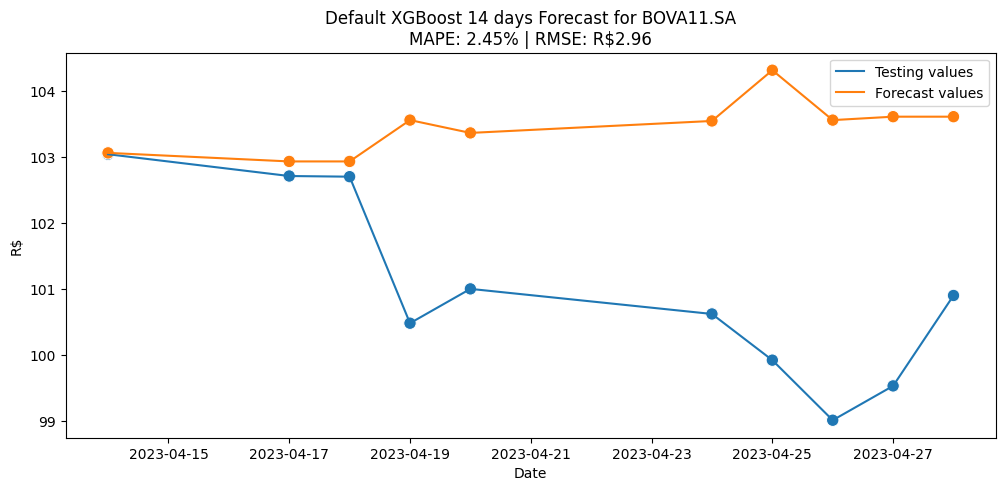

In [28]:
# Execute the whole pipeline
predictions_df = validade_model_one_shot(pd.concat([X_train, X_test], axis=0), pd.concat([y_train, y_test], axis=0), model_config['FORECAST_HORIZON'])

In [ ]:
X_test

## 5.0 Validando 